<img src="yelp.png" alt="Drawing" style="width: 300px;"/> <img src="ikea.jpg" alt="Drawing" style="width: 300px;"/>

# Yelp IKEA Friendship Network Analysis

* using the data set from Yelp: https://www.yelp.com/dataset 
* The Yelp dataset is a subset of our businesses, reviews, and user data. Available as JSON files

The dataset has 
* 8,635,403 reviews
* 160,585 businesses
* 200,000 pictures
* 8 metropolitan areas
* 2,189,457 users

The size of the Yelp dataset was **too big** for analysis. Hense the need for IKEA. 



# Preparation 

* prepare the data by filtering for only reviews completed for IKEA stores and developing a friendship network with other users who completed reviews of IKEA.



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import os
from tqdm.notebook import trange, tqdm

In [24]:
path_to_jsons = "/home/kent/college/Semester3/THUR_1830_SNA/data/"

In [25]:
# list all cities:
# egrep -o "\"city\"\:\"[A-Za-z]+\"" yelp_academic_dataset_business.json | sort | uniq -c | sort -n

# find IKEA businesses

In [26]:
pickle_name = "df_IKEA_businesses.pkl"
filename = path_to_jsons + "yelp_academic_dataset_business.json"
try:
    df_IKEA_businesses = pd.read_pickle(pickle_name)
except (FileNotFoundError) as e:
    IKEA_businesses = [] 
    with open(filename) as f:
        for line in f:
            if "\"name\":\"IKEA\"" in line:
                IKEA_businesses.append(json.loads(line))
    df_IKEA_businesses = pd.DataFrame(IKEA_businesses)
    del IKEA_businesses
    df_IKEA_businesses.to_pickle(pickle_name)

df_IKEA_businesses

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,_WNv5lBB95rOOWG_IlqkRg,IKEA,4092 Eastgate Dr,Orlando,FL,32839,28.483013,-81.427288,3.5,425,1,"{'BusinessParking': '{'garage': False, 'street...","Department Stores, Kitchen & Bath, Shopping, F...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
1,ybwFrX6MqvmVePZUZKk9VQ,IKEA,3320 Jacombs Road,Richmond,BC,V6V 1Z6,49.189088,-123.079062,3.0,191,1,"{'BusinessParking': '{'garage': False, 'street...","Outdoor Furniture Stores, Shopping, Home Decor...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
2,eKSSsmq0JKOtxYHcCEeGAg,IKEA,441 16th St NW,Atlanta,GA,30363,33.788912,-84.404820,3.0,697,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Home & Garden, Shopping, Furniture Stores, Hom...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-21:0', ..."
3,xD8HsAu6Y56G7QtaqhfdPA,IKEA,"1000 Lougheed Highway, Upper Floor",Coquitlam,BC,V3K 3T5,49.234637,-122.866372,4.5,7,1,"{'BusinessParking': '{'garage': False, 'street...","Scandinavian, Restaurants, American (Traditional)","{'Monday': '9:30-20:0', 'Tuesday': '9:30-20:0'..."
4,m_s4YWGvECpvLq7Zg262xg,IKEA,1 Ikea Way,Stoughton,MA,02072,42.137600,-71.068565,3.0,771,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Furniture Assembly, Furniture Stores, Kitchen ...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-21:0', ..."
5,YLNepntdgU5PPN_WSmjIJQ,IKEA,1000 Lougheed Highway,Coquitlam,BC,V3K 3T5,49.234637,-122.866372,3.0,133,1,"{'RestaurantsAttire': 'u'casual'', 'Ambience':...","Food, Home Decor, Mattresses, Shopping, Specia...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
6,ykScDlwKkbHotxZIliIvAA,IKEA,10280 NE Cascades Pkwy,Portland,OR,97220,45.571288,-122.553511,3.0,577,1,"{'BikeParking': 'True', 'RestaurantsReservatio...","Shopping, Furniture Stores, Food, Home & Garde...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-20:0', ..."
7,E01vjBU47-VMZPWxCBithg,IKEA,1900 Ikea Way,Columbus,OH,43240,40.150546,-82.967140,3.5,204,1,"{'GoodForMeal': '{'dessert': False, 'latenight...","Kitchen & Bath, Shopping, Outdoor Furniture St...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-21:0', ..."
8,iJHHadqILp7kVl6K6GGBTA,IKEA,1500 Ikea Way,Norfolk,VA,23502,42.135360,-71.068810,3.5,118,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Lighting Stores, Office Equipment, Home & Gard...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-21:0', ..."


# where are they located?

In [27]:
df_IKEA_businesses = (df_IKEA_businesses
 .assign(map_label = df_IKEA_businesses.city + ", " + df_IKEA_businesses.state ))

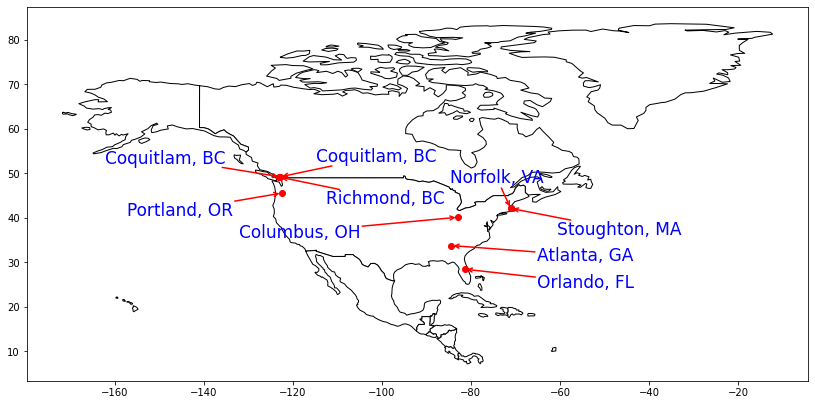

In [28]:
import geopandas
from adjustText import adjust_text
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(14,14))

gdf = geopandas.GeoDataFrame(
    df_IKEA_businesses, geometry=geopandas.points_from_xy(df_IKEA_businesses.longitude, df_IKEA_businesses.latitude))

# We can now plot
gdf.plot(ax=ax, color='red')


texts = []
for x, y, label in zip(df_IKEA_businesses.longitude, df_IKEA_businesses.latitude, df_IKEA_businesses.map_label ):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color = "red")
    texts.append(plt.text(x, y, label, color = "blue", fontsize=17))
adjust_text(texts, only_move={'pdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAy8AAAGVCAYAAAD3484KAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzddVxU2fsH8M/Q3d3dqEgqBooJNrp2rLmua2F3rrrqrt3dri4moigGKgqCIqKAdHfHUDNzfn/sl/uTBREUGNDzfr3O616YmTvPHVDuc885z2ERQkBRFEVRFEVRFNXWCfA7AIqiKIqiKIqiqMagyQtFURRFURRFUe0CTV4oiqIoiqIoimoXaPJCURRFURRFUVS7QJMXiqIoiqIoiqLaBZq8UBRFURRFURTVLgi15pspKSkRPT291nxLiqIoiqIoiqLakdevX+cSQpTre6xVkxc9PT2EhIS05ltSFEVRFEVRFNWOsFispM89RoeNURRFURRFURTVLtDkhaIoiqIoiqKodoEmLxRFURRFURRFtQs0eaEoiqIoiqIoql2gyQtFURRFURRFUe0CTV4oiqIoiqIoimoXaPJCURRFURRFUVS7QJMXiqIoiqIoiqLaBZq8UBRFURRFURTVLtDkhaIoiqIoiqKodoEmLxRFURRFURRFtQs0eaEoiqIoiqIoql2gyQtFURRFURRFUe0CTV4oiqIoiqIoimoXhPgdAEVRFEVRFNX2cTgcvHz5EhEREaisrKzVqqqq6nyvvlZVVQUAEBISalITFhZu8msa08TFxaGjowNNTU0ICgry+ROmGoMmLxRFURRFUVS9srKycO/ePfj4+ODBgwfQ09ND586dISYmBlFRUaZJSkrW+vpzTUREBCwWCxwO54uturq6Uc+rqqoCm81u1HP/28rKypCUlITc3FxoaWlBT08P+vr6dbZqamoQEKADltoCmrxQFEVR1FcihKCoqAiFhYVM+/TroqIi5qKKy+V+cVuzTwiBqakp7OzsoKysjKKioka34uJiEEJqXVzW7De0bcxzGrOVlJSEhIQEWCwWv388P5SKigpERkYiPDwc7969Q3h4OMLDw1FWVgYhISEICgpCUFCw1v5/v/7vYyUlJUhMTESfPn3g5uaGXbt2QUNDg9+n2iIqKiqQnJyMxMREJCYmIiEhAd7e3khISEBiYiIKCwuho6NTb2Kjp6cHFRUV+jvfSliEkFZ7Mzs7OxISEtJq70dRFEVRzaGwsBC3b99GYmIikpKSmJaSkgIRERHIyckxTVZWttbX4uLizBCVTy8Q/7v9dJ8QgoiICISEhKCwsBCysrKNbjIyMmCxWKisrERFRQUzXKdmvzm39X2vtLQUHA6n3thqPh95eXno6+vDxMQEJiYmUFRU5PePuN0ghCApKalWkvLu3TskJCTA0NAQHTp0gLW1NTp06AArKyvIysrWSZC/9HXNvqioKDp37gxhYWF+nzbfsdlsJCUlMYnNf7dsNht6enqf7blRUFCgyU0TsFis14QQu3ofo8kLRVEU9SP4NCEQEhJieggkJSUhKSkJPT09yMnJ1XndkydPMHnyZHTu3Bnm5ubQ1dVlmo6ODiQlJVv/ZNq4qqqqWr1BNb1QNS0/Px/x8fGIjo7Gx48fISQkxCQyJiYmMDMzw5AhQ+hFM/5NnC9evMgkKe/fv4eUlBSToNQkK2ZmZhAVFeV3uD+sml6qT3tuEhMTERsbi/DwcEhJSUFPTw8zZ87E3Llz+R1um9dQ8kKHjVEURVHfJUIIoqOj8fjxYzx+/BhPnjyBlJQUHB0dAQBlZWVgs9koKytDaWkpEhISYGZmBldXV/Tu3RsODg7Ytm0bzp07hxMnTmDAgAF8PqP2Q0REBMrKylBWVv7icwkhyMnJQXR0NJPMTJo0Ca9evYKlpWUrRNsyKisr8e7dO7x9+xby8vIwMzODkZERxMTEmnScESNGoLy8HGPHjsXo0aNhbW1Ne6raICkpKVhYWEBSUhJsNhuJiYnIzc1FQkICTExM4ODgAHt7e7i5ufE71HaP9rxQFEVR7QohBGVlZcjJyflsy87ORmhoKISFhdGrVy/06tULLi4u0NXV/exxKysrERQUhIcPH+LRo0d49eoV+vXrh5MnTzbqIpxqutLSUrx//77OECglJSW8e/euyRf6hBCw2WyUlJQwrbi4GCUlJWCz2eDxeMzzalpDXwOAhoYGevToAXFx8c++L5fLRVRUFIKDgxEcHIxXr14hIiICRkZGsLGxQXFxMSIjI5GQkAAtLS2YmZnVaubm5vUmJNnZ2dDW1saHDx9gZGTUpM/ie5OSkoI//vgD5ubm4HK5qK6uZib0/3e/vu9VVVWhtLQUJSUlEBYWhqCgYL3P5XK54PF4tYbUNabxeDywWCxoaGgwiYq9vT3s7Ozq7dGlGkaHjVEURVFtWmlpKTPU4tNWc/fyv6VWxcXFmTv7NU1FRaXW15aWltDX1//qceZVVVUQFham49S/EY/HQ35+PrKyshAZGVkrScnIyICFhQUzBMra2hrW1tZQVVUFIQQFBQVISUlBamoqUlNTkZKSgrS0NBQUFNRKUGpaaWkpREVFIS0tXadJSkpCQECA+XmyWCymNfR1TEwMwsLC0L17dwwcOBADBw6EgIAAk6gEBwcjNDQUqqqqzAWrg4MDbGxsICEhUeuzqK6uRnx8PKKiopgWGRmJqKgoCAsLw9DQEHJycpCRkYGsrCzKy8tx4cIF5vWdO3fGuHHj0KNHD3Tq1OmHGlb34sULODs7N/txVVRUYGBgAH19fRgYGDDzVrS0tCAiIlKrgEFNKy8vR2xsLGJiYhAdHc1sVVRU8Ntvv2HYsGEQEmq9wU1cLhf5+fkQFhaGjIzMd1EVjSYvFEVRVJtFCIGAgACUlJRgb28PfX19punp6UFZWblWNSsREZHv4o9ze8fj8RAeHo6YmJhaPV6fbnNycpCXlwcZGRmoqKjAzMys1oRyIyMjCAoKIicnB3v37kVKSkqtZEVYWBhaWlrQ1tZmtpqamlBQUKg3QZGSkmqRi8aCggI8ePAAd+/eha+vL1gsVp276/Ly8l99fEIIsrKyEB8fz1SMq2k1c4R8fX0RGxtb57U6OjqYOnUqpkyZ0mDP4vciPDwcL1++rFUlrzGtpkQz8O/vbnZ2NpKTk5nfuf/u5+bmQlVVFTo6OtDW1oa8vDzi4uIQGRmJvLw8GBsbw9zcnOk5MzU1RUxMDPbu3YukpCTMmTMHixYtavLvY03Pcm5uLnJycpCbm1trv75tUVERZGVlweFwUFpaChkZGcjLy0NOTu6L2w4dOkBLS6slflTfhCYvFEVRVJvm6emJjx8/Yvny5XBwcKATj9uo2NhYzJkzB0+ePGEWGxQVFWV6u5SUlKCsrAwDAwOMGjWK+d6XegiSk5NhY2ODvn37YurUqUyyIi0t3Rqn1a6w2WxER0cjKCgIZ86cwcuXL5nHwsLC0KFDBz5G9/2oqqpCeno6k9Tk5+fD0NAQ5ubm0NHR+eyClm/evMGECRNQUVGBwMBAqKioAPh3gc/ExETExMQgKSmpThLy6T6Lxar170lJSanW/n+3CgoKTDwcDgfFxcUoKChAYWFhg9uCggK8fv0a+/fvx+jRo1vts20MmrxQFEVRrapmTHpVVRWz/XSfy+XCzMyMuagtKyvDpk2b4Ofnh48fP8LR0REuLi5wdXWFk5MTHbrVRhw/fhwzZswAAHTs2BHq6upgs9kIDg5GeXk5AEBMTAy9e/fG7du3P9tDxuPxUFhYiLy8PKb5+vri2LFjePr0Kezt7VvtnL4XhBD674SPoqOjsWbNGty4cQODBg1Cz549kZiYyAwrS0pKgpqaGoyNjZl1YT6XkPx3uGFLCg4OhpubG8aMGYO9e/e2md8hmrxQFEVRLY7NZkNXVxf5+fkghEBERATCwsL1brlcLthsNmbNmoUZM2ZATU2NOU5hYSGeP3+Ox48f486dO5CUlMTq1asxdOhQOlysDagpbPDo0SM8evQIb968gY2NDXr37o1evXrBycmp1kT7qqoqfPjwASEhIQgJCcHr16/x/v17iIuLQ1FREQoKClBUVGTa1KlT0bFjRz6eIUU1zdGjR/Hrr7+Cy+VCXV0dJiYmMDY2hrGxMbNvaGjY5AIUzYkQgvT0dISHhzNFMsLDwxEVFQV1dXXY2tri7NmzfI3xUzR5oSiKolpEXFwcjhw5gpiYGOTn5yM8PBwFBQUYMWIEvLy8GnxtWFgYDh48iCtXrqB///6YM2cOunXrVuvOH4/Hw61bt7B582ZUVlZi3rx5cHJygrm5eatOiP1RcTgcxMTEMBc8gYGBePnyJczNzdGrVy/07t0bzs7OkJKSAvDvhPSatXRqEpUPHz5AX18fdnZ2sLOzg62tLTp27Niqd5cpqiWlpqYiJycHRkZGbWKoY1FRUa0EpWZfSEiIKYphbW0NKysrWFpaMv9+25JvTl5YLNZCANMBEADhAH4GIAHgbwB6ABIB/EQIKWjoODR5oSiK+j4EBQVh27ZteP78OaZNmwYHBwfIy8tDQUEB8vLyUFFRafQdvMLCQpw5cwYHDx4EAFhaWtZZnVpXVxcBAQE4c+YMQkNDkZKSAgsLC9jY2MDGxgadO3eGtbX1Zy+IeTzeZ0uo1uxzOByIiYlBRkYG0tLSEBUVbTNDKFoDIQQvX77Es2fPmAue6OhoaGpqMhc6dnZ26NGjB+Tk5MDhcBAZGVkrUQkPD4euri6TpNjZ2aFTp050IU+KagE1C+++ffuWSVTCw8ORn58PS0tL5t9tTbJSM/+mPfim5IXFYmkCeA7AghBSzmKxrgDwAWABIJ8Qso3FYi0HIE8IWdbQsWjyQlEU1b7l5+dj8eLFuHfvHtauXYuJEyc224Upj8dDWFgY4uLiapVKrtlKSUkxq9qrqalBQEAA5eXlzEJwsbGxTMWd/675wOPxICwsDGFhYQgJCdW7LygoiIqKCmZdEB6PV6eaVU0Vn3379n03a78QQnD37l1s2bIFmZmZGDp0KHPBY2FhUSchfPPmDXbs2IHbt29DS0urTqLSFu48U9T3qLq6mqlCd//+fRw+fBgFBQVwcnKqlaTo6em1+yG2DSUvje1zFwIgzmKxqvFvj0s6gBUAXP73+BkATwA0mLxQFEVR7dfNmzcxe/ZsjBw5Eh8/fmz2i1QBAQGmJ+W/akrJJicnMy0lJQUZGRlIT09HVlYWtLW1cfz4cZiamiIqKgpr166FqKgoxMXFISoqCiEhoQablJQU9PX1YWhoCD09PURHR+PevXu4e/cuwsLCoKenB0NDQ3Tv3h2ysrLNeu78wOVy4eXlhS1btoDH42HlypUYOXJkvcPxCCG4f/8+duzYgY8fP2LBggU4ePDgN5UHpqgf3Z07d7BhwwaUl5ejvLwcFRUVtbb/7WAQFBRkbqLY2tpi+/btcHV1bfeJSlN9MXkhhKSxWKydAJIBlAO4Twi5z2KxVAkhGf97TgaLxWo/fVEURVFUk507dw4KCgpYsmRJq99dZ7FYUFNTg5qaGhwcHOp9zrFjxzBy5EhcvHgRHTp0QGJiInr06IGhQ4cyw8I+16qrq1FSUoI7d+4wPT/a2tpwdnbGihUr4Ozs3CbXQvga1dXVOH/+PLZt2wZ5eXls2rQJgwYNanCIXHJyMiZMmIDc3FyYmZnh2bNnSEtLg4GBAdP09PTazGRfimoPahY5/RwhISFwOBwAwKFDhzBr1qwfaijr5zRm2Jg8AC8AowEUArgK4B8A+wkhcp88r4AQUucWDIvFmglgJgDo6OjYJiUlNVfsFEVRVCvicrnYvn07du3ahb/++gujRo1qc+uxPHnyBGPGjMHatWvRtWtX9O3bFwcOHICbm1ubnJTa3LhcLvLy8hpc0C4gIAAmJiZYuXIlXFxcmnQxVFRUhISEBMTHx9dpycnJUFJSYpKZoUOHYvjw4S14thT1/crIyMCCBQsQEhKCgwcPon///vwOqVV965yXUQAGEEKm/e/rSQCcALgCcPlfr4s6gCeEENOGjkXnvFAURbV/wcHB8PT0RHh4OPr06YPBgwfDzc2tzcwBiY2NhYeHB/Lz82FhYYHs7GzExsbCzs4O/fv3R//+/dGxY8d2P9SCEIKKigp8/PgR169fx7Vr1xAZGQl5efk660Z8um9paYlOnTo1ezxcLhdpaWnw9fXF7NmzcfDgQcycObPZ34eivmdcLhdHjhzBunXrMGPGDKxevfqHrMz3rcmLI4CTAOzx77Cx0wBCAOgAyPtkwr4CIWRpQ8eiyQtFUVTDnj59infv3kFBQaFOk5WV/eyqzvyQnZ0NHx8f3L59G35+ftDW1oawsDAIIfU2Y2Nj3Lhxo1ViI4QgJiYGDx48wLlz5xAUFAQ9PT106NABUVFRKCwsxOLFi7FkyZJWiacx1qxZg82bNzNfS0hIQEZGBrKyshAWFmbGxde0yspKiIiIQEtLC8OGDcOIESPg4ODQKiWkeTwe0tPTmV6Xmt6YhIQEfPjwAdu3b2cWs6QoqnGysrLw008/MQmMpaUlv0Pim2+asE8ICWKxWP8AeAOAAyAUwFEAUgCusFisafh3Psyo5guZoijqx9SzZ08MGTIE4uLiKCgoQH5+PtOKi4shIyMDFRUVZmiOoaFhrW1rlqRVUVHBlClTMGXKFFRUVCAyMpJZ5ZvFYuHevXtYs2YN9PX1MXr0aIwbN65V4vrw4QN8fX0RGBiIoKAglJaWYuDAgXB0dMS4ceMgJSUFJycnqKqqtko8jWVsbAwtLS2mmhCbzQabzUZmZiZOnjwJZ2dniIuLQ1xcHBISEhATE2vR3qPCwsJaScmniUpSUhIUFBRgYGAAfX19GBgYwNXVFQYGBjAxMam16ChFUV8WEhKCESNGYPLkydiwYUO77xluSXSRSoqiqAYkJCTg/v374HA4UFFRgba2NkxMTKCgoNAi7zdw4EAQQuDq6gpbW1t07twZcnJyAP4dTlBUVITMzEzmQjIuLo7ZJiQkQFZWtk5CY2dnBwsLiwbf9+3btzhz5gzExMQgKioKMTExpikrK0NbWxtGRkZNOu9Zs2ZBV1cXK1asaPFJphUVFfDy8sKhQ4cQHx8PV1dXaGlpQVJSEqWlpbU+Ly6Xi3nz5tXq5Whr1q1bh40bN2LKlCnYtm1biyRabDYbiYmJtcpR15SoTkhIQHV1da3k5NN9PT09iIuLN3tMFPUjOnfuHDw9PXH48GF4eHjwO5w24ZsXqWwuNHmhKKqtI4TA398fd+7cwZ07d5CXl4f+/ftDSkoK2dnZSExMRExMDERFRWFmZsa0cePGNcvd5qysLNy/fx+vX79GcHAwAgMDoa+vj/nz52Pu3LkNvpbH4yEjI6NOUvPw4UOMGDECW7ZsYRKh/zpz5gz++OMPTJo0CRUVFUxjs9nIzs5GcnIyYmJiYGpqCjc3N7i5ucHe3r7BYWwrVqyAl5cXZs2ahQkTJrTIBXhsbCyOHDmC06dPo2PHjujQoQPu37+P/Px8mJiY1EriavYVFRXbRcWeO3fuYP78+bC2tsauXbugp6fXpNdXVlYiOTm5zno5NdvCwkLo6urWWRBUT08PBgYGUFJSahefE0W1ZxEREejZsyceP34MKysrfofTZtDkhaIoqpHu3r0LNzc3AMCAAQNga2tbq/u+uroaMTExePr0KXJzc6Gnpwdzc3Ns2rQJnTt3bpYYIiIisHfvXty+fRvp6ekwNDTE9OnTYW1tzaxJUrPAor6+PtTV1Rs8XkFBAZYvX47bt2/jr7/+wujRo+tclIaHh2PgwIEICwuDoqJivceprq7Gy5cvmcQuKysLbm5u2LdvH2RkZOo8nxCCZ8+e4dSpU7h+/Tp69uyJSZMmwdTUFHJycpCTk4OkpGSTL5Crq6tx+/ZtHD58GG/fvsWUKVOgoqKCw4cPQ0BAAH/99Rfc3d3b/YV3aWkpLl++jHnz5sHKygqvXr1q8PllZWVYuHAhIiIikJiYiJycHGhpadWbnOjr6zMLfVIUxT+hoaGYOnUqQkND+R1Km0KTF4qiqEZKTU3F8ePHmUXCalpVVRWEhIQgLy+PDh06wN7eHqampi1SBcbX1xeXLl2qtUL8p+uR1OxXVVUhJiYGIiIizBCzmq2Wlladi/cXL15g6tSpGDduHNauXVvrMUIIVqxYgevXr8PHxweGhoZfjHPXrl3Yv38/3r1798W5NiUlJbh69SouXbqEtLQ0FBUVobCwEJWVlUwiU9NqFoAsKysDm81mtjX7paWlcHBwwC+//AIPDw+Iiorit99+w5s3b5CcnIzs7GyoqalBV1cXOjo60NXVxahRo+pd/LItKS8vR0REBMLCwvD48WPcvn0b3bp1w8SJEzF48OAv/q5duHABhw8fxubNm6Gvrw8NDY1WmbxPUdTXi4iIwMiRIxEREcHvUNoUmrxQFEU1oKaH4NixY/Dx8UFRURFkZWUhLy/PVPqSlJRERUUFUlNTkZKSgvLycmhpaUFLSwuLFi3CoEGD+BZ7cnIyXr9+jTdv3uDNmzd4/fo1CCEwNTWFoqIiFBQUmHOpqqrC77//jt27d+O3336rc7xDhw5h6dKlcHBwwMCBAzFw4EDIyMggNjYWsbGxiIuLY/YTExPx8OFD2NrafnX81dXVTCLzaWOxWJCQkICEhAQkJSXr3QIAh8OBn58fkpKSkJKSAklJSRgZGUFGRgZCQkJIT09HdHQ0Tp48CWtra6xYsQI9evTge68Mj8eDn58f3rx5g7CwMISFhSEhIQEmJibo2LEjnJycMHLkSKioNH7958mTJyMgIAD9+vVDhw4d0LFjR1hZWbX6gqIURTVeXFwc+vXrh7i4OH6H0qbQ5IWiqB8CIQQFBQWQl5dv9MXp1atXsXr1ahQXF2Pp0qUYPXr0F4fTlJeX4+3btzh69Cju3buHBw8etKmxyoQQpKenIyYmhqlYVlBQUGtfT08P27Ztq/f1paWlePToEe7evYt79+6hqqoKhoaGMDIyQmJiIl68eAFBQUEICQlBQECgThMUFISVlRX69OmDPn36oGPHji2WLERERMDS0hIeHh7o0KEDSkpKEBkZiYiICGRkZMDQ0BDm5uYwNDTE69ev8eTJE9jZ2WHFihUYNGgQX4ZNlZSUYMKECUhMTGQ+n44dO8Lc3BwiIiLfdNzXr18jLCwM7969w7t37xAREQE1NTUmmenQoQM6dOgATU1NiImJ8T2Jo6gfXWpqKpycnJCamsrvUNoUmrxQFNXupKen49atW0hNTa334pjFYiE3NxdpaWlITU1FWloa0tPTUVlZCW9vb7i7uzfqfW7cuIGzZ8/i5cuXIITAyckJjo6OcHJygoGBAeLj4xEVFYWPHz8y24yMDBgYGMDS0hLbt2+Hvr5+C38abUdqaip69OgBVVVVSEtLQ1RUFKKiohAREWH2hYSE8PbtWwQEBAD4d9X7nj17tlhMCxYsQHZ2Ni5evFjr+2w2G9HR0YiIiEBkZCST1MTExIDD4cDCwgJ3796Fjo5Oi8VWo2bdmaCgIGzfvh1OTk44cODANyUrjcHhcBAbG4t3797VSmoyMzMBALKyssxQvU+39X3vv4/JyMjQOTMU9Y3Kysqgp6eHsWPHYs2aNW1msV9+o8kLRVHtQnR0NK5fv47r168jOjoa7u7uMDU1BY/HA5fLBY/Hq7WvqKgILS0taGpqMs3GxgbXrl1r8uJehBCkpKQwa4MEBgYiISEBhoaGMDMzg6mpKbPV19f/oecSZGVlISgoiJkP9On8oJp9DocDWVlZdOvWDa6uri16h5/NZsPGxgabN2/GqFFfXnKsuroacXFxiImJQa9evSAlJdXsMVVUVODhw4cICgrCq1ev8OrVK0hLS8PR0RGDBw/GhAkT+N7rUVFRwQzZS09PZxKbmlZVVdWo44SEhHzT0EGK+tFlZ2dj06ZNuHTpEhYuXIgFCxa06ppdbRFNXiiKapMIIXj9+jWTsBQWFmLYsGEYPnw4XFxcICws3KTjsdlsKCkpoaioqMmvpRrm7++PUaNGgcPh1FoD5r9NUlISzs7OcHNzg7GxcbNeoOfl5SExMRFJSUlISkqqtR8TEwMnJyf4+fk12/t9iwsXLuDnn39Gnz59YGNjAxsbGygoKKC6uhpVVVXMULxOnTq1WkyVlZXw8fFhPrfk5GTm8ysrK4O2tjZ0dXWZQgc6OjpQUFCo07NW87WQkBB4PB4MDQ35nohRVHvF4XBQWVmJyspKREREYMmSJUhKSsKGDRswbdq0H7Z3kyYvFEW1KfHx8Thw4ACuXLkCCQkJDB8+HMOHD4e9vf1X/0fNZrOxZ88eXLlypdVLTubl5SEoKAhqamrQ1tb+7tbHCA0NRf/+/XHu3DnY29vXWgfm01ZZWYnCwkI8fvwYPj4+EBMTg5ubG/r06VOrlHJ9f3fk5eUbnBvz5MkT9OvXD5aWlswFtp6eXq19BQWFNvO5V1dXY+TIkUhKSoKIiAhEREQgLCzM7GdlZUFQUBAvX75stZgSEhLQr18/xMbGQk1NDZ6ennBxcYGOjg5UVFTazGdHUd+j6upqREZGIjQ0lGlv375FaWlpvcNvxcXFcfPmzR9qWPKnGkpeftxxDxRFtSpCCJ4/f45du3bh6dOnmDp1Knx9fWFubt7kiyZCCCoqKlBSUoL8/HxcvHgRhw8fRpcuXXDy5MkWOoO6Mfj7++Po0aPw8fGBra0t8vLykJKSgrKyMmhpaWHz5s0YM2ZMq8TzJSkpKXjx4gVevHiB7Ozseit47dmzBx4eHtiwYUOtClUXL15EWVkZDh06hNjYWPTp0wcmJiaf/bmNHTsWhBCEh4fDx8cHBw4cQGVlZa3n/Pe1ycnJEBUVxc8//4yJEyfWWfDT1NQUUlJSCAkJaXBhzLZCWFgYN2/eBABwuVx8+PABL168wMuXL/HixQvk5ORg/PjxrRqTvr4+oqOjERQUhHPnzmH79u24efMmJk6ciJ9++gny8vKtGg9F/QiWLFmCJ0+e4MOHD9DR0WF6YgcNGoROnTpBSUmJ3yG2O7TnhaKoFlVVVYWrV69i165dKC4uxvz58zF58uRGzzOorKxEaGgoAgICEBAQgKCgIGRnZ0NAQAAyMjKQkZFB37594enpCRMTEwBAZmYmfHx84O3tjeDgYKiqqtYaDvPp/testp6eno5evXoBAH799VdMnDgRCgoKzONlZWV4/fo1PDw88PLlSxgZGTXp+E0VFBSEkpISiImJQVRUFGJiYmCz2QgMDGQSlsrKSnTt2hVdu3aFpqZmrXVTarZKSkqIjY3FgwcP8Ndff2HUqFHMZ5OVlYVHjx7Bz88PDx48AACYm5tDVla2wWZqagoNDY0vngMhBAEBATh16hS8vLywfv16LFiwoNZzOnbsiPz8fEhISNQawvRpk5aWhpKSEpSVlWs1JSUlcDgclJSUoLi4mNl+ul/fVlpautacqk+bmppavcMTCwoKEBgYiJcvX+Lly5d49eoV1NXV0aVLF3Tt2hVdunSBubk535Owqqoq3Lt3D+fPn4evry/69OkDDw8P9O3bl04apqhmcvToUXh5eeHFixews7ODm5sbBg4cCEtLS9rb2QA6bIyiqFZXVVWFn3/+GRcvXkSvXr3g6ekJNze3Lw4Ly83NxcuXL5lkJTQ0FMbGxujatSucnZ3RpUsXaGhoQFRUtM5r79y5gw0bNiAmJgb9+vXD4MGD0bVrV+Tk5NQa3//peP+qqqo6SU2XLl3Qo0ePz15cVlVVwdPTEzdu3MCRI0c+W9lsz549OHfuHB4+fMgsvNgS5OTkYGVlBUIIKisrUVFRARERETg4ODAJS1PmJTx//hwzZ87ErFmzMH/+/DqP11TOSkhIQFFRETPpu2b/0/bu3Tv07dsX8+fPR5cuXb4YQ1lZGSwsLHD69GkmQaxRUlKC3NxcZnz4f1tNb1xubi5ycnKYbc2+kJAQpKWlISMjU2db3/ekpKRQXFyMtLS0eltOTg6UlJSYZEZaWhpv3rxBSkoK7O3tmWTFyckJioqKjf+B8kFhYSH++ecfeHt748mTJzA0NES/fv2YoXpVVVXM0MBPhwn+d7+qqgocDgdcLrfW4qqftk8fExISgpiYGMTFxWu1T7+noKCADh061PtvnqLai7KyMmZIrY+PD3g8HgYOHIhBgwZh0KBBNJH5D5q8UBTV6lJTU6GtrQ0AkJSUhKmpKczNzWFubg41NTVkZ2cjMzMTGRkZyMzMZPZZLBYcHR3h7OwMZ2dnODo61povUZ/y8nIsXboUt2/fxoEDB9CvX79GT9gvLi6uldjULLyYmpqKESNG4KeffvpsIvP48WNMmzYNPXv2xK5duyAnJ1frcR6Ph/nz5+PZs2fYsWMHMjIy8PbtW4SGhiI7O7vWIowyMjL4448/oKur27gP+BP6+vrw8/ODoaFhk1/7Ofv370dkZCQOHDjwTccpLi7GqVOnsG/fPigoKGDx4sX46aefPvv8wMBA9OnTB6qqqujcuTNsbW3RuXNn2Nvbt7lhTRwOB5mZmUwyU1RUhE6dOsHa2rpdV6Orrq5GYGAg7t+/D19fX8THx9fq1fvc/qcT+T/XatYHqtnncrlMpbr/Vq6r+To7OxvR0dGwtrZmypg7OTlBT0+PXvBR7RIhBFFRUbh79y727NmDI0eOYMCAAfwOq02hyQtFUXxVWFiIqKgoZq2NrKwsqKqqQl1dHWpqalBXV2f2ZWRkmnRBEh4ejnHjxsHS0hKHDx+uk0B8rdjYWPzzzz+4cuUK0tLSPpvIlJaWMonT0aNHMXDgwFrHIYTgr7/+wokTJ9CpUyemaWhooLy8HGVlZSgrK8OlS5egoaGB7du3NzlWBwcH7N27F05OTgD+7RkqLS1FaWkpSkpKoKmp2eTP5cSJE3j8+DHOnz/fqOfXrCdS0wPxX1wuFz4+Ppg+fToePXrUYClrLpeLmJgYvH79Gm/evMGbN28QGhqK3r17Y8qUKejVqxckJCS+etgVm81GfHw84uLikJiYiKKiIubnUDOE7tN9NpsNERERSEpK1ts6d+6MIUOG/PClTVsSm83G69evERgYyAzJ43K5tZIZe3v7en/3KKot+/3335GTk4Pdu3fzO5Q2hSYvFEV9dwgh2LdvHzZt2oSdO3di0qRJLXYX9r+JjKmpaZ0L2JCQEAQHB2PatGk4evRok6umhYWFwd3dHSkpKU0+j2HDhiEgIABcLhelpaUghEBaWhpSUlKorKzEqFGjsH///kYfj8PhwM7ODkuXLsW4cePqPF5aWop3797h7du3TPvw4QNUVVVRUFCAkSNHYtasWbCzq/t3Z+rUqbCzs8Ovv/7apHMsKirC1atXcfr0abx58wYVFRUQFBRkhhfVlGmumWsjIyPD7EtISCA1NRWxsbGIi4tDfn4+9PT0YGhoCH19fcjLy9cqXFDTPi1oUFVVxSQ1n7bS0lL4+/vjxYsXcHd3x7hx45rU80d9HUIIUlNTmWQmKCgIoaGhMDAwwIwZMzBv3jx+h0hRjRISEoKJEyciMjKS36G0KTR5oSjqu1JUVIRx48bh/fv38Pb2hrW1dbO/R03t/ZoL5BoJCQlITk6u9yK2rKwMALB27domDRtKT0/HqFGjoKamBi8vrybHWjO/REpKClJSUrVWbd+9ezcSEhKwZ8+eRh9v9+7duH37Nvz8/OokUmfPnsXcuXNhampaqyfJ2toa0tLSyMzMxMmTJ3Hs2DEoKCjg0KFDcHBwYF5/+fJl7Nu3D8+ePfum9QsIIaiurmaGGVVUVKC0tBTFxcUoKipitjW9KpqamjA0NIShoSE0NTWbfbJ8Tk4Orl69iosXLyI6Ohp+fn7o0KFDs74H1bCqqiqcPn0aV65caTPr/VDUfxFCkJubi+zsbGb49KRJkxAXFwcdHR1+h9dm0OSFoqjvSkxMDH777TcmkZCTk4O+vj709PSgrq4OLpdbayJ3VVXVZ7/+3GM8Hg8AYG9vj1evXn11rDWT6GsSnJokp2Y/Ozsba9euxZw5c7BixYpmX5Bs27Zt8Pb2xtSpU2FiYgITExMoKyuDxWKBx+OhtLQUhYWFTMvJycGsWbPw/PlzmJmZMcfh8XhYs2YNLl26BG9vb1hYWDT4vjweD1euXMGcOXNw/PhxDB8+HMC/Q8K6du2KGTNmYPr06c16rm3Fvn37cOfOHdy7d4/fofxw7t27h+nTp2PVqlUYPHgwtLS0+B0SRdVy9epV/PTTT1BUVISVlRVUVVWhpqaGtWvXtvnCHq2JJi8URX23eDweMjIykJiYiISEBGRmZkJYWPizq4J/uh8bG1tr6FNeXh46deoER0dHODg4wNHREUZGRnUSCkIIUlJS8P79e7x//x4fPnxAbm4uk5D8N0ERFBSElJQUJCUlmd6RT7+eOnUq+vbt2yKfT3x8PC5duoTo6GhER0fj48eP4PF4EBAQQHFxMSQkJCArKws5OTmmDR8+HFOnTq11HH9/f7i4uMDOzg79+/eHo6MjHB0doaKi8tn3Tk1NhaWlJYYPH47Tp08z3w8LC0Pfvn0xffp0psJbTcW39j5vJDExEXv27MHevXuRlpZWZ70aqmVVV1fj+vXruH37Nnx8fKCnp4chQ4ZgyJAh6NSpE53gT/EdIQRHjx7F6tWr4enpiSVLlrTrAh8thSYvFEVR/xEaGgo7OzuMHTuWSVY6depUqxwrIQTZ2dlMkvJpsiItLQ0rKytYWVnB0tISqqqqdZKSmv22Nv8hPz8fACAjI9OkP5o5OTl49eoVgoKCEBQUhFevXkFKSgqKiopMieGaJi4ujr///hvz5s3D8uXL6wzTevjwIV68eFGrfHVKSgqkpKRqJTSfJjbKyspQVFSEhIREs30WVVVVn133paysDAoKClBTU2OauLg4gH/n/cTGxiImJoZpNcnh5MmT8euvvzZr9Teq6TgcDgICAnDr1i1cu3YNjo6OOHPmDC25TLUJSUlJmD59OgoLC3Hq1ClYWVnxO6Q2hSYvFEU1q+rqarx58+azPQ1f+r64uDgMDAxgYmICY2Njpmlqajb7sKnP4XK50NPTg4ODA1gsVp21KMrLyxEdHQ0ej8ckKZ8mK58uSvmj4vF4SEpKQkFBAUpKSuq0nj171jtpv6HjZWdn10poPk1scnNzkZubCwEBASgqKkJJSQmKioqQk5ODqKgouFwueDxerfbp99hsdp0Ehcvl1lnnpaaJi4ujoKCAKeWdmZnJlAQuLi6GoaFhrd9fY2Nj2Nvbt/veo+9RRUUFJk6ciOzsbNy4caPNld2mfhw8Ho9ZH4nNZuPAgQPYvXs31qxZg+XLl7fa38C2jiYvFEU1K39/f/Tu3RvCwsLo168fU9mqvqFR9X2/tLQUcXFxte5Yx8TEIC8vD2JiYhAWFoaIiAhERESY/f9uRURE0KlTJwwePBhdunT5qm73Dx8+IDw8vN61KERFRWFiYgJVVVU61KSRKioqEBAQgHfv3qG8vBxCQkIQFhZmPtdP90VERKCurg49PT1oaGg0egI9IQRsNptJZPLy8lBQUAAOhwMBAQEICgpCQECg3iYpKVknQREVFW30z5cQgsLCQrDZbKirq9OLjHaGx+Nh8eLFuHfvHu7evftVaypRVFPt2rUL27ZtY4qLVFdX16qSWLMvJSWFmzdv0qGm/0OTF4qiml1oaChmzpwJCQkJHDlypNbk7q9Vs1J3dXU1qqqq6mw/3a+oqMDLly/h7e2NpKQkDBgwACNGjMDgwYNrVdui/sXlchEXFwddXd1mHTaTkZGBy5cv4/79+3j+/DmsrKxga2sLGRkZVFdXMz1Z/92vqqpCWloaEhMTkZ+fD21tbejp6TGFF/T19dGzZ09oaGg0W6yEEJqIUti9ezd27tyJ27dvw8bGht/hUN+50tJSXL9+HZcuXcKzZ88wePBgjB8/npZU/wKavFAU1SK4XC4OHDiAjRs3Yvny5Vi8eDFf4khNTYW3tzcuX76MyMhITJo0CdOnT4epqSlf4mmswsJC5ObmMklbzVACQggcHBwgIyPzze+RmZmJEydO4OjRo+DxeMjNzYWhoSGsra1hbW0NCwsL8Hg85OfnIy8vD/n5+bVaZWUlDh06hI4dO9Y59rNnz/DTTz/Bzc0Nbm5u6N2791cNxykvL0dycjISEhKQkJCAffv2ITIyErt27cKCBQsadYyysjKkp6cjLS0N6enptfY//d7JkyfrXbvmv3g8HlJSUhAREYHIyEhEREQgMTERP//8M8aNG1crCcrJycHvv/+OmJgYZGRkMHdRG2pycnJwcXGBsrJykz8v6tt5eXlh9uzZOHfuHPr378/vcKgfRE5ODi5evIhFixbh0KFDmDFjBr9DarNo8kJRVIsJCwvDiBEjMGLECOzYsYPf4SA6Ohrbtm3D6dOn0a1bN5w8eRJGRkb8DquW+Ph4/Pbbb/D394eamhozdEBUVBRiYmLgcDgIDQ2Fvb093NzcMGPGDMjKyjb6+IQQ+Pv749ChQ7h//z5GjRqFX375BZ07d0ZFRQWioqLw7t07hIeHIzIyEiIiIlBQUKi3hYWFYceOHQgLC6t1oX3mzBksXboUZ8+ebbaLvw8fPmDu3LnIy8vD/v370b17988+NysrC6dPn8bly5cRHx+PqqoqaGhoQFNTExoaGrX2BQQEsHDhQri5ueHQoUO17nZyOBzEx8fXSlIiIyMRFRUFWVlZmJubw9zcHBYWFlBWVsbvv/8OWVlZHDhwAJaWlgD+vRDetm0b1qxZA01NTWbNmf+2kpKSWiWynz59ik6dOmH48OEYPnw4XeOhlQUEBMDDwwNbtmypU12PopoDIQRFRUVISUlBamoqUlNTcevWLbBYLHh5edGelwY0lLzQ2mwURX0VQgiOHz+OlStXYs+ePY26m90SuFwugoOD8ejRI4SEhCAkJARFRUWwtbWFsLAwFi9ejNTUVJibm8PGxoZZVLG1JtxXVVUhJiYGHz58QFJSElMOuLi4GEpKSpgzZw6mT59ep5elrKwM06dPx9q1a9G9e3c4Ojo2+j2fPn2KXr16YejQoUhMTKyV+IiJiTGfQUMqKipw+PBhbN++Hd26daszFG/Lli24du0anJ2dGx3X5xQXF2PDhg04e/Ys1q5di9mzZ9c7h4nH48HPzw/Hjh2Dn58fRowYgX379sHS0hJycnL1DgmLjIyEm5sbZs+ejdWrV9d6zpkzZ/Dbb79BWVmZSVB69eqFOXPmwMzMDHJycnWON3z4cBw+fBguLi6YMmUK1q5di7KyMhQVFUFERASdO3du9NC08vJy+Pn54fr169i0aRP09PQwfPhwjBgxAubm5o3/AKmv4uzsjKdPn2LgwIGIj4/Hpk2b6LBCqkkCAgIwd+5cEEJQ0xlQs62oqEBaWhoEBQWhpaXFNCcnJ3h6etLE5VvUfOCt0WxtbQlFUe1fVVUVmTx5MrG0tCSRkZGt/v7Z2dnk3LlzZNy4cURRUZGYmZmRIUOGkGHDhhFHR0ciKSlJrK2tyaxZs8iZM2dIQEAAOX78OPntt9+IjY0NAUCePHlS57hcLpekpqaS4OBgUllZ2ahYoqKiSG5ubr2PDRs2jIiJiRETExMyfPhwsmDBAjJixAhibm5OREVFiZaWFrGwsCBycnLE09OTJCUlEUIIKS0tJVOmTCFmZmYkPDz8qz6ju3fvEmNjYzJ48GASGxvbpNdevHiRaGpqksGDB5PQ0NB6n6Ojo0MSExO/KjZC/v2s4+LiyPHjx4m6ujqZMmUKyczM/Ozzq6uryaBBg0iHDh3IoUOHSFFRUaPeZ8aMGcTa2rrW83k8HtmwYQPR09MjHz58+Kr4MzMzyeTJk4mmpia5ePEiuXDhArGysiK2trbk2rVrhMvlNul41dXV5NGjR2Tu3LlES0uLjB079qviopouKyuLODo6knHjxpHy8nJ+h0O1I2w2m2zevJlIS0sTZ2dn4uvrS0JDQ8nbt29JREREo/+fouoCEEI+k0/QYWMURTUJl8vFxIkTUVRUhKtXrzbrmhufw+PxEBISAh8fH9y9excfPnyAsbExZGRkkJ6ejqysLDg6OqJr165wdnaGo6NjvcOscnJyMGDAACgrK+O3335DYmIi4uLimJaQkABpaWkoKSkhOzsbo0ePxoQJE+Do6FjrjiwhBL6+vti5cyfev3+P8vJy9OrVC+PHj8egQYOYtUD++usvXLt2Df7+/nWqaVVXVyMyMhL37t3DiRMnkJeXh6qqKgwcOBDv37+Hra0tDh48CCkpqS9+PleuXMH169chJydXa8FJcXFxnDp1Cv7+/vDw8MDZs2cb9fPaunUrjhw5AkIIBgwYgIEDB6J37961eodsbW2xePFijB079ovHA4C0tDScOXMGERERiIiIwMePH6GoqIgOHTpg1apV6NKly2dfSwjBb7/9hpiYGNy5c6dJdywrKyuxYMECPHnyBNevX4ehoSFmzpyJ8PBweHt7f3Nln+fPn2POnDlQVlbG/v37ERUVhd9//x1sNhtjxoyBsbExUlJSmJLPiYmJKCwshJCQEDgcDsTExCApKVlrMVVCCJ48eYLCwsJG/fypb8dmszF9+nS8evUKBw4coPNgqCapmfd2/vx5zJs3D56envTf7jeic14oimoWhBDMnDkTcXFxuHPnDnOR3hKqq6vh5eUFb29v+Pr6QkVFBV27dmVKK7u6uqJr167o2rUrrKysGlVqd8yYMfjnn3+gq6sLQ0PDOk1fXx/S0tIAgISEBJw/fx7nzp0DAEyYMAGjR4/Gy5cv8eeff4LFYmHx4sUYM2YMKioqcO3aNZw/fx5v3rzBwYMHMWbMGPB4PLi6umLAgAFYtmxZg7G9e/cOJ06cwNmzZzFgwABcvHix0UNYJk6cCBEREdjZ2aGwsBBFRUUoLCxk9j98+ICUlBSUlpY2eg0SQgiioqKYsrIvX76EnZ0dfv75Z0yaNAkhISFwd3dHSEgItLW1GzzWlStXMHfuXHh4eMDR0RHm5uYwMzNrdEGC3bt34/jx4wgICGjS3J9PnTx5EsuXL4eRkREUFRVx+fLlZluPhcPhYOnSpYiNjcWtW7dACMHz58/h5eWF1NRU6OjoQFdXF3p6epCWlsa9e/dw8eJFKCkpMQUbrK2tYWZmBhMTE+jo6EBMTAwDBw6k5ZhbmY+PD3777Te4uLjg5MmT/A6HamOKi4uxf/9+5Ofnw8HBAfb29tDT02P+r05ISMCaNWvw6NEjvHv3DkpKSnyOuP1qKHmhw8YoimoUHo9HFi5cSBwdHUlxcXGLvs+tW7eIiYkJcXFxIYcPHyZRUVFk2bJlREFBgWzevJmw2eyvOnZ5eTmpqqpqcjyBgYFkzpw5REVFhfTr14/cv3+f8Hi8ep//9u1boqysTF68eEEIISQxMZEoKyuTt2/fNur9kpOTiZKSEomIiGh0jDt37iSysrLE2dmZ7Nixg0RHRzf6tY1VWlpKfv/9d9K9e3fme1u2bCE9e/YkHA6n3tcUFBSQ8ePHExMTE/Lq1auvet8bN24QDQ2NbxqiViM4OJj8/vvvpLq6+puP9V/r1q0jy5cvr/W96upqEhsbS+7evUv27NlDRowYQeTk5Mi0adPImzdvmOclJyeTy5cvk3nz5hE7OzsiISFBnJycyKJFi4iXl1eDw+mo5hUeHk709fXJ+vXr+R0K1cacOnWKKCoqkp49e5JNmzaRoUOHEnV1daKkpETc3NzIunXryJ07d0h2djaxsbEhr1+/5nfI7RrosDGKor4FIQRLly6Fn58fHj161GKrU4eFhcHT0xOZmZn4888/MWDAABQUFGDo0KFQVFTEgQMHmnXdj5Zy584dzJgxA4GBgdDR0cHZs2exY8cOBAcHQ0xM7IuvP3jwIC5cuIBnz541+s57RUUFHj9+jBs3buDWrVtQUFDA0KFDMWzYMNjZ2TXLHfw//vgDmZmZ2LVrF4B/hxD27t0bTk5OGDJkSK0F16KjozFr1iwMGjQIO3bs+OrhhXp6ejh27Bj69u37zfG3pH79+kFDQwOKiopM72BiYiLU1NRgbGwMExMT2NnZYejQoV8sFlFWVobg4GC8ePECAQEBePHiBaysrDBmzBiMGjUKKioqrXRWP5Y7d+7g559/xq5duzB+/Hh+h0O1MSdOnMC1a9cQFhaG0tJSdOjQAZ06dYKKigq0tLQQHR2NV69eISQkBMXFxXj16hXs7OrvOKC+jPa8UBT1TZYvX060tbVb7A5wVlYWmTZtGlFRUSEHDhxg7ownJycTCwsLsmDBgiZPgOa3nTt3ko4dO5KSkhJy8OBBoqCgQFJSUhr1Wi6XS7p160b27dv3Ve/N5XLJy5cvyfLly4mZmRlRV1cns2bNInfv3iUVFRVfdUxCCBk1ahQ5d+5cre8lJSWRrl27Ej09PaKvr090dXWJlpYWMTY2Jrdu3frq96oxcuRIcuLEiW8+TktbtGgRmTZtGtm2bRu5du0aef/+fbNN/q6srCS3b98m48ePJ7KysqRv377k5MmTpKCgoFmO/6Pj8Xhk586dRF1dnekxpaiG5OTkED8/P7Jz507i4eFBFBQUyNKlS0l6ejrhcrkkMTGx3f3NamvQQM8LTV4oivqitWvXEisrKyIpKUl69uxJVq5cSe7cuUPy8/Ob5fhz5swho0ePrnUxFh4eTrS0tMjOnTub5T1aG4/HIz///DPR09Mj5ubmJCYmpkmvj4yMJEpKSiQtLe2bY/n48SPZvn076dq1K5GVlSULFy4keXl5jX49m80mT548IZqamrWGs2VmZpLx48cTHR0dsmPHDrJy5Uoyfvx40q1bN6KtrU2EhYWJjY0NOXny5FdfyF+4cIEMGjToq177PSorKyN///03GT58OJGTkyNxcXENPv9zwxup/zd79uxvrp5H/dgSEhLI3Llziby8PJkxY0aLDN390TSUvNBhYxSqq6tRUFAAZWVlWuOealBhYSECAwOZ4SyvXr2Cjo4OnJ2dmUpfRkZGTfo9qqysxKRJk9CnT59aqw336dMHz58/R5cuXWBiYgJTU1Nmq6en1y5q5FdVVWHfvn2YPn36V000nz9/PiQkJLB169Zmiyk9PR2bN2/G1atXsWzZMkyaNAmKioq1Ch7k5+cjICAAz549w/PnzxEWFgZra2sMGDAAa9euBSEER44cwbp16zB16lSsXbu23snv1dXV8PPzw549exAaGopffvkFs2fPblKFr8LCQujo6CA9PZ1W7/mPmTNnQldXF0OGDKlVzaxmPykpCSUlJVi5ciUWL14MUVFRfofcJq1atQqXLl0Cl8vFoEGDYGVlhYSEBMTGxiI2NhYpKSlwcXHB1KlTMXDgwHrXIKK+P5WVlbh16xbc3d0bPew1NzcX+/btw8GDB9G/f3+cOXOmUcVkqLpotTGqDh6Ph6dPn+Ly5cvw8vICl8tFVVUVjIyMYGhoCCMjI2a/S5cuLVpVimq/OBwO3r17x4zL9/f3h4uLC06cOFHv70xWVhbCwsLw7t07hIWFISwsDDExMdDX18exY8dqLXjI4/GQlpaGjx8/4uPHj4iOjma26enpUFdXB4vFAo/HA4/HA5fLZfYnTZqEHTt2tOZH0SLi4uLg5OSEpKSkZi9JHRUVhRUrVuD58+coLCyEgoICVFVVweFwkJqaCicnJ3Tr1g3du3eHg4MDk5zExsZi3LhxEBUVxaFDh2BlZdWo94uMjMTevXvx999/Y9u2bZg5c2ajY+3Xrx+UlZWho6PDJMYsFgssFgt2dnYYNmxYk8//e3D//n2MHDkSWlpaTDUzXV3dWq2mVHR0dDQOHDgAV1dXfofdJhFCEBkZCW9vb8TExNT6O6iqqgofHx+cPHkS8fHxmDRpEqZMmUIXEv3OFRUVQVNTE+Li4pg3bx7mzJnT6MWNS0tL0atXLyxfvhweHh4tHOn3iSYvPyBCCCorK2tNDiaEICQkBJcuXcLff/8NZWVljB07FqNHj4aenh4KCwuZ9S5q7jhFRkYiKysLBw8exIABA5jjlJeXQ0xMjJbxpGopLy/HtGnTEBcXh927dyM+Pp5JUsLCwlBZWYmOHTvWahYWFo1KjsvLy/Hq1Su8f/8eISEh8PX1RUZGBlRUVGBtbQ0rKyumdejQoVXWn2kNw4YNg76+Pjw9Pb9YkvhrcTgc5ObmIjs7GzweD1ZWVp+9u7xixQoUFBTg4MGDX/XvPzo6GkOGDEG/fv3w119/Neou9vv37+Ht7Q1CCKqqqnD16lV8+PABBgYG2LJlC0aPHt3kOH40t27dwrx589C1a1esX78eRkZG9P/vrxAVFYVTp07h/Pnz0NTUxKRJkzBmzBhaEvc7tXz5crx69Qp6enq4ceMGJk+e3Oj/i2/cuIHNmzcjODiYjmr5CjR5+QFwOBy8ffsWz58/Z1p+fj4EBQWhoKAARUVFlJSUQFhYGGPHjsWYMWMafdfo3r17+PXXX2Fvb4/u3btj//79SEhIQHV1NURERCAuLg5xcXFISEhAXFwcCgoKuH//Ph2i8IMihGDr1q24cOECLC0tmSSlQ4cO0NbW/ur/xI8cOYJffvkFPXr0wMiRI2FlZQVLS8vvvvJSTEwMNm7ciLt370JTUxPu7u4YNGgQHB0d+TIcYdasWbCxscEvv/zy1ccoLCxkEo6///4bcnJyjXrd0aNHsWHDBpiammLBggVwd3enQzKaoKysDL///jvOnTuH/Px8mJmZwcLColbT19enw6L+x8vLC3v37gWHw2GaqKgo9PX1oaOjg/j4eDx79gy5ublwd3fHpEmT4O7uDhEREX6HTjWTzMxMGBoaIjIyEgICAti9ezdOnjyJESNGYOXKlTAwMPjsa3k8HiwtLbFv3z706dOnFaP+PnxT8sJisUwB/P3JtwwArAVw9n/f1wOQCOAnQkhBQ8eiyUvzKSoqQnBwMJOo1NwZ6NatG9N0dHRQXl6OvLw85OXlQVBQEJaWll918chms/H7778jNjYWv/76K3r06MH07pSXl6O8vBxsNhtJSUno27cvJkyYAG1tbWhpaTFbLS0tiIuLIyMjg2k5OTlQVVWFiYkJjI2Nv5u75e1Feno6KioqoKur2+YvAgkhOH36NJYuXYqJEydCUVERQkJCEBQUZLaCgoKoqKhgfh8//d38dCsiIsIsHPhp09DQaLOfA5fLRVBQELy9vXHnzh2kpaVh4MCBcHd3h6urK5SVlVsljpEjR2L06NEYNWrUNx2Hw+Fg0aJF8PX1xa1bt2BiYvLF1+zbtw+///47rK2tMXfuXJq8fIPi4mJERUUhIiICERERiIyMREREBDIyMmBkZMQkM0OHDkXHjh35HW6r+/jxI7p164ajR49CRUUFQkJCEBISApvNRkJCAtPi4+ORkJCAtLQ0EEKgqKiIdevWYe7cufw+BeoblJSU4Pjx49i9ezd0dXVx4cIFprclPz8fu3fvxoEDBzBs2DBMmDABeXl5SE1NRWpqKtLS0mptFy9ejC1btvD5jNqfZut5YbFYggDSADgCmAMgnxCyjcViLQcgTwhpcAlpmrx8ndDQUJw6dQrx8fFITk5GcnIyOBwObGxsmESla9euLbb2RlMQQvD06VMkJiYiJSWF+cdcs89ms6Gurg51dXVoaGhAWVkZmZmZiI6ORlxcHJSVlZmJ2Z9O0tbS0qJ3s5pZeXk5DAwMICQkhNzcXBgbG2P8+PGYO3dum04i4+Pjce7cOVRVVYHD4YDL5TJ3RblcLrPOSE1PoICAAIqKiiAlJQV5eXkoKCiAEILMzEwkJSUhMjISz549Q2FhIYSEhKClpQUjIyNcuXKlTfyb+pzk5GT4+PjAx8cHT58+hZ6eHlxdXeHq6ooePXq02OT23r17Y9WqVc02d+Lo0aNYs2YNLly40Ki7k5WVlbh69Sr279+PmJgY6OjoQFVVFWpqakxTVVWFuro6DAwMoKWlRYdHNQGbzcbHjx8RERGBd+/e4fz587C2tsayZcvg4uLyQwx/qaqqgoODA+bMmVOriEhDKisrkZSUhISEBCgoKMDe3r6Fo6RaQlpaGvbu3YsjR46gS5cuWLZsGbp27QohIaE6/4/UJDEPHjyAuro6c5NWU1OT2dfQ0KBzhr9ScyYv/QCsI4Q4s1isjwBcCCEZLBZLHcATQohpQ6+nyUvjEULw6NEj/PHHH4iIiMDs2bNhbW0NHR0d6OjoQF5e/rv7I8LlcpGcnFxrYnbNZO2MjAwICAhASkoK0tLSdbYyMjIwMjKCpaUlLC0tISEhUW/1HSkpKXTu3Bm2trbo3Llzq92tbg35+fnM5/Vpq6ysxKZNmzBmzJhavzP79++Hn58fbty4gbKyMoSHh+PPP//EixcvsHbtWkydOrXBil4lJSXYv38/ysrKsHnz5tY4xXqVlZUhKioKUVFRSEpKYhLmmqS5uLgYampqIISgoqKCaRwOB2JiYuDxeNDT04OBgQEMDQ1hYGAAY2NjuLm5tZuLXg6Hg+DgYDx8+BAPHz5EcHAwbGxs4OrqigEDBsDJyalRxyksLMSmTZtQUVGBvn37wsXFpc6Qro4dO2LZsmUYO3Zss/wfxOPxMG/ePBw5cgRZWVmNnhALgOnBzczMRFZWFjIzM5n99PR0xMfHIy8vD3p6eswE7E+3enp6LX5ThBCC27dvY8+ePXBxccGsWbPa1VDHyspKXLhwAdu3b4e0tDROnz4NS0tLfofVomJjY9GrVy8kJyd/d39nqYaNGzcOfn5+tYYKcjgcVFdXg8ViQUhICMLCwkxPnLCwMCQkJJgmKSkJCQkJaGtr4/Dhw/w+nXatOZOXkwDeEEL2s1isQkKI3CePFRBC6tymZLFYMwHMBAAdHR3bpKSkpsb/w3n+/DkWLFiAsrIyLF26FOPHj//hex1qJuqWlJSgtLS0zrawsBDR0dF4//49Pnz4wAyF+m8FnuLiYrx+/Rpv3rzBmzdvICMjwyQyJiYm0NfXh76+PpSUlNr8H63k5GTcuXMHd+7cQVBQECorK2FqalqnFRYWYv78+VBQUMDKlSsRHByMGzduIDY2Fg8ePEDnzp1rHTc4OBgrV65EYmIiNm3ahJ9++qnWRXxZWRkOHjyInTt3wtHRESEhIUhPT683xtevX+PFixe1kk0pKSkoKSnB1NT0mz/jVatWYcuWLTA2NoaNjQ309fXrDFVUVlauNwnhcrmoqKhgeme+J2w2G8+fP8fdu3exd+9esNnsBuegEUJw+fJlLFq0CIMHD4aRkRH8/Pzw4sULWFpaok+fPnB3d4eDgwOOHz+OPXv2gM1mY/To0Rg7diw6duz4VT/Lx48fY/HixRASEsKff/6Jbt26fctp16tmmE9sbCzi4uLw8eNHPHv2DPn5+cjPz4eMjAxkZWUhKysLOTk5KCgoQF5eHnJyckyreey/+zW9W2VlZcjPz0deXh5z3Jp279495OXlYfny5Xj69CmuXr2KoUOHYvjw4VBUVIS8vDzk5eWhqqrapofA8Xg8nDhxAuvWrcP9+/cbXWWuPSopKYGamhpKS0u/6vc6KioKN2/exKtXr/D333/TOUTfAUIIeDxenaSmqqoKycnJuHTpEi5duoSioiIMGDAAEyZMwMiRI/kddrvWLMkLi8USAZAOwJIQktXY5OVTtOfly6qrq2FiYoKNGzdi/Pjx391FVVvC4/EQHx/PJDIxMTHMOGYOh4PS0lL0798fZmZmTFJT01piSE5ycjL8/f3B4XCgrKxcq0lJSYHL5SIwMBB37tyBt7c3MjIyMGDAALi7u6Nnz55M6eD6cDgcHDp0CMePH0ePHj0wbNgw9OjRo8GelYcPH2LFihWorq7G1q1b0bNnTxw+fBjbt29H9+7dsW7dOlhYWEBOTg6xsbG1erFKS0tx6tQpbNq0CR4eHigvL0dpaSmTcNbMtenbty/69++Pvn37ftXd6JycHCxYsACBgYE4evToD18Gtrq6ulZiHxISgr179+L169f1Pr+wsBBeXl44deoUSkpKcPjwYXTp0oV5vKKiAi9evMD9+/fh7e2NnJwc/PTTT1i/fj3S0tJw6dIlXL58GWJiYli0aBF+/vnnRl+Ar1mzBps3b4a+vj5mzZpVK+HU0NCoVSmxOX38+BHdu3fHnDlzUFhYiJycHOTn56OwsBCFhYXIz89HQcG/0zelpaUhLS0NUVFRCAsLQ0xMDOXl5SgsLERRURHKy8shICAAYWFhpjCKgoJCrWZlZYUxY8YwF7B5eXk4duwYM1SxoKAA+fn5kJWVxZ49e5iqjm3VpUuX4OnpCV9fX3To0IHf4bQYaWlpvHz5slHzRDkcDl69eoWbN28yPdk2NjZ48+YNUlNT2/yNMKrp0tPTcf36dXh5eeH169fo378/Ro4cCTc3N7oeVTNpKHmpd+XK+hqAoQDuf/L1RwDq/9tXB/DxS8ewtbX9mkU2fxg8Ho/s27ePuLq68juUH15BQQEBQI4cOUJ27txJ5syZQ9zc3Ii5uTkRFxcnSkpKxMHBgcyfP588fPiQVFVVNfk9MjMzyaVLl8iMGTOIoaEhUVZWJiNHjiSTJk0iAwcOJHZ2dkRXV5dISEgQUVFRIiUlRTp16kRWrVpFXrx4QTgcTguceW08Ho94eXkRMzMzIiUlRYYNG0bCwsJqPadbt25k0qRJZNy4ccTJyYmoqKgQcXFx0qNHDxIbG/vZY8fGxpJDhw6RYcOGEVlZWWJjY0OWLVtGfHx8SGJiIuFyuY2O09vbm+jo6JCff/6Z5Ofnf/X5tkdbtmwhioqKRFRUlAgKChI5OTmipaVFzM3Nib29PTl16lSd14SEhJDhw4cTGRkZ4uHhQf75559G/Q7Hx8eT3377jaipqZGLFy8SHo9HeDweefbsGenWrRvp1KkT8ff3b1TcSUlJ5OrVq2TXrl1k0aJFZPTo0cTZ2Zno6uoSERERoqysTE6fPt3Uj+OLgoODSefOnRt8Do/HI0VFRSQyMpI8evSInD9/nnh6ehI1NTXi4OBADhw4QPLy8kh1dTWpqKholri8vb2JkZERGTJkCImLi2uWY7aUv//+m6iqqpLQ0FB+h9JiVq9eTdTV1Ymuri6ZPn06uXz5MsnOziYcDofExcURb29vsmPHDuLh4UHk5eVJhw4dyOrVq0lwcDDh8XjkwIEDZPLkyfw+DaoZJSYmkj///JN07dqVyMnJkQkTJpDr168TNpvN79C+SwBCyGfyiab0vFwG4EsIOfW/r3cAyCP/P2FfgRCytKFj0J6X+iUkJODChQs4f/48OBwOLl++DDu7+pNNqvWIiooiKSmpzmrghBBkZWUhLi4Ojx8/xq1btxAbG4sBAwZg6NChGDBgQIOrqb958wZbt26Fn58fevbsid69e6N3794N3uFjs9morKzk2wRyDoeD9PR06Ojo1Hns5s2bCA0NrTVnRE1NrUl3G6urq/Hq1Svcv38fL168QFRUFPLz82FiYgIzM7NazcTEpN4JkDUriXt5eWHOnDnIz89HYmIiEhISUFlZCRsbG9ja2sLW1hY2NjaQlpb+ps/ka5WUlCA+Ph7FxcUoLi5GSUkJiouLweFwYGhoCDMzM2hraze61zUrKwtLly7F/fv3sWfPHvz0009ffI23tzdWrlyJrKwsjBo1CqNGjUK3bt0a3WsSGBiImTNnQl1dHYcOHYKBgQEIIbhy5QqWLl0KBwcH7NixA3p6eo063n/xeDysXr0agoKC2LRpU61z3bBhA8TFxbFixYqvWlvj8ePH2LBhA548edLk13I4HDx48ABnzpzB3bt30adPHyxZsqTRc4q+pLKyErt27cLOnTvxyy+/YMOGDW12KNlff/2F33//HS9evICpaYPTXdst8r+FK/38/ODn5wd/f39UVVVBRUUF5ubmMDMzg62tLfr06QN1dfVarx0xYgQ8PDwwfvx4PkVPfSsej4eQkBD4+PjA29sbiYmJGDp0KDw8PODq6kqXg2hh3zxsjMViSQBIAWBACCn63/cUAVwBoAMgGcAoQkh+Q8f50ZKXtLQ0lJeXo7q6mmk1E7+qq6vx8eNHXLhwAVFRURg9ejQmTJgAR0dH2sXcRoiKiiIlJaVRw5nS09Nx+/Zt3Lp1C8+ePYOjoyM6deoEFRUVqKqqQlVVFVwuF3v37sX79++xePFizJgxg1m1nKqrpKQE0dHRzGT8qKgoREZGIi4uDmpqasxwvpo5TTXbuLg4XL58GcrKylBSUoKsrCyUlJSQlpaG169f4/Xr1wgPD4e2tjYGDBiAP/74o0X+CNUMS3z37h3evXuHsLAwvHv3DpmZmTAwMICsrCxTbEJaWhqCgoKIi4tDVFQUCgoKmMSt5iJJX18fqqqqUFFRqXdI1fbt27Fp0yZkZWU1ulrcx48f4eXlhatXryIjIwPDhw+HiooK4uPjERcXh/T0dFhaWqJLly7o0qULHBwcmKTv9evX6NOnD9zc3HDhwgXmmOXl5di6dSt27tyJnJycr/4d37BhA7hcLjZu3Ijq6mrs378fW7ZsweTJk1FZWYlLly5hwYIFWLhwYZPe49atWzh27Bhu3779VXHVKCwsxMGDB5lhI80hPz8fJ06cwIEDByApKQl/f/82s/hhWloaHj9+zLSysjK4uLhgw4YNMDMz43d4raK6uhpVVVVf/H27evUq5s+fj3fv3rWZnx/VOAUFBbh//z58fHxw9+5dKCsrw83NDW5ubujevTudv9SK6CKVrYwQgmXLluHYsWPMWhTCwsJMhYqafQ0NDYwdOxb9+/f/4Sfkt0UiIiJITU1t8lyM0tJS+Pn5ITo6GllZWcjKykJ2djbYbDamTJmCiRMn0js234DD4SAxMRFRUVFITExkqsnV7BcXFzMlk2smQ6elpcHW1hZTpkzBsGHDICwsjMjISGzcuBE5OTm4fv16g1WuCCEoLS1FUVFRva1mDkRNi4uLw/v376GoqMgs/GdgYAAdHR0oKCigsrISOTk5TMyZmZlwdHSEu7s7bG1tUVZWho8fPzIJW8255uTkICsrC6KiolBRUWGSY2VlZdy4cQOXLl366nk/sbGxuHbtGsrKymBgYAADAwOoqqri/fv3ePnyJV68eIG3b9/C2NgYOjo6CAoKwrp16zBz5sw6f9DPnTuHM2fOwM/P76tiAYD169eDEIJu3bph/vz50NbWxp49e5gL5djYWKxZswb+/v5Yu3Ytpk2b1uAcrhqHDh3C8+fPayVcXysrKwuWlpbIzc395mMBwMGDB7FixQqUlZWhR48eTPXEmtaUSmzNISAgAGfPnsXjx4+Rn5+Pnj17olevXujVqxcsLCzojbb/SElJwe3bt7Fhwwbcv3//h1wfp70hhCA8PJwpO//27Vv06NEDbm5uGDhwIPT19fkd4g+LJi+tiMvlYvbs2QgLC8Pdu3db/Y8N1XxERESQnp5O75y1M2w2G0JCQrVuCFRUVODmzZs4ffo0goKCMHLkSEyZMgWOjo5YtmwZbt++DWdn51rDuD7dLy0thaioaK2qVDX79TV9fX0oKytj7969uHDhApSUlGqtPSMhIQFFRUXo6elBT08PSkpKeP78Oe7cuYOCggKMGTMGK1eurDdxJoSguLgY2dnZTKu5iO7evfs3f3ZhYWFMEYv09HR07twZTk5OcHR0hKysLEJDQxEZGYnhw4fXKaNcE5+NjQ22bt2KgQMHfnUs69atw6FDhyAtLY1du3Zh8ODB9V4sv379GnPnzoWBgQHOnz/f4DEjIiLg4uKCa9eufXNls6qqKqxatQr//PMP4uPjm+1CnhCCtLQ0fPjwAR8+fEBERASzlZCQYH7Ow4cPh7W1dYsmEKdPn8aff/6JqKgoDBs2DAMHDkT//v2hqanZYu/ZniQlJeHJkyfw9/eHv78/ioqK0LNnT6xYsYIO/W6jiouLmSUZfH194ePjA2FhYbi7u8PNzQ0uLi50XZY2giYvrWjDhg3YuHEjtmzZgv79+8Pa2rrNjlmmGiYsLIyMjAyavHxnXr9+jTFjxiA2Nhb79+/HnDlzcPv2beTk5NQaxvXfbVOGCxw6dAiLFy/GzJkzsWrVqib9DsXFxWH//v04d+4c5s6dC09Pz1aZn5OXlwdNTU1YWloy5cPV1dXx5s0bBAYGIigoCIqKinBycoKTkxPc3NxgaGhY5zh+fn6YP38+3r9//00X1n5+fnj9+jXmz5//xcpjY8eORZcuXTBv3rzPPicnJwdOTk5Yu3YtJk+e/NVxAf8Otxs3bhw0NTVx4sSJZl8vqrCwkFmnicvlYujQoZCXl0dqairev3+PBw8e4Pr16xAUFMSwYcMwfPhwdOnSpcWqU6alpeH+/fvw9fWFn58f1NTU0L9/f/Tv3x/du3f/4S727t27h9mzZ4PNZqNnz55Ms7CwoBVC+YjL5SIjI4NZzDspKYnZr2lVVVXQ1dWFvr4+XF1d4ebm1ixl+6nmR5OXVpSdnY07d+4gICAAAQEBSE9Ph6OjI7p27Yrhw4fTbuR2RFhYuMmL5lFtU1FREa5fv44LFy4gJCQEQ4YMwbhx4+Dq6vrNY5hLS0vrlMb09fXFmjVrkJOTg19++QVTp05t8gVuQkIC1qxZg4cPH2LZsmXQ1NSstZZISUkJOnTogN69e8PMzOyb//hyuVzIysoiLS2t3oITPB4PUVFRCAwMxI0bN8Dj8eDt7Y0nT57g6tWrEBcXh5iYGO7evYs5c+Zg6tSp3xRPY+Xk5MDY2BgJCQmfLWhRWVmJPn36oHv37tiyZcs3vV9sbCw6duyI1atXY/ny5c160XPx4kUsXLgQbDYbpqamMDExQVVVFR48eAAXFxdMmjQJI0aMAIvFAiEEYWFhuHbtGq5fv47c3FwMHToU69atqzN5vDlxuVy8fv0avr6+8PX1RVhYGJydndGzZ0+YmJgwC4B+r+Viw8PD4erqiosXL8LV1ZVe9LaS0tJSeHl54fr16ygtLa1Veaq6uhqpqanMSAldXV1mQe9Pm66u7ne5wPf3iiYvfJSbm4uXL1/i2bNnuHDhAszMzODp6YmBAwfSOzRtHE1evg/79u3DkiVLUFlZCUdHR8yZMwdmZmbQ0dGBiopKvX/IeDweysrKarXS0lJmGx0djZCQEAQHByMtLQ2urq7YuXNnnYX7goODsXv3bnh5eWHDhg1YtmxZk+MPDQ3F9u3bUV1dzawjoqioCAkJCYSEhODRo0eorKyEi4sLevfujV69esHQ0LDOeZWXlyM9PR3p6enIzc2FgIBAndWiZ8yYgePHj39x+Jm3tzcOHz6MnTt3onv37li8eDEEBARQUVEBYWFhLFy4sNXmde3evRu+vr64e/duvY/n5OTg559/hpiYGK5cufLN/+9WV1dj0aJFuHPnDq5cuQJbW9tvOl6N8PBw9O7dG3fv3oWtrW2tn19xcTGuX7+OJUuWwM/Pr971VWJjY3H06FFcvXoVPj4+MDc3b5a4vqSwsBCPHj1CQEAA4uLiEBsbi/j4eMjIyMDQ0BBGRkaws7PDrFmz2v3czszMTDg5OWHr1q0YO3Ysv8P57vF4PPj7++PMmTO4efMmunXrhrFjx0JZWRksFotpwsLC0NTUhKamJp1P+h2hyUsbUVVVhStXruDPP/9EeXk5Vq5ciYkTJ9K7AG2UsLAwcnJy6h3XT7UfaWlpePnyZb1DCUpLS6GtrQ1hYeFaiUpFRQUkJCQgKSkJKSkpSEpK1moGBgawt7eHnZ0ddHV1cfToUWzatAkjRozAhg0boKqqiuLiYhw9ehS7du2CtbU1Nm/e3GLj4BMSEvD48WM8evQIjx8/hoCAABwdHVFcXIz09HSm8qGGhgY0NDSgpKQEQghT/fDTFaN3794NBweHBt/v1q1b+PPPP5GVlYUlS5Zg2rRpLXJejfH+/XuMHDkSnTt3xoEDB2r1vnh7e2PmzJmYOHEiNm7c2KwXNlevXsWvv/6KnTt3fvMwtLKyMtja2mLVqlWYOHHiZ5/XpUsX/Pnnn+jatetnn3PmzBksX74c7969a/bhbI3F4/GQmZmJ2NhYxMXF4Z9//kFSUhKOHTtWaxHU9qS8vBy9evXCgAEDsH79en6H891LTk7GmDFjUFpaiilTpmD8+PFQVVXld1hUK2qWRSqbo9FFKv/F4/HIo0ePSMeOHcnQoUNJdnY2v0Oi6iEkJEQKCgr4HQbVgkpLS0lkZCQJDw8n8fHxJCsri5SVlREej9fkY+Xn5xNPT0+iqKhIJk+eTBQVFcnYsWNbfSE/Ho9HPn78SC5evEju3btH3r17R3Jzc7/qnD7nxo0bBACZPXt2sx3zW5SVlZHffvuNaGtrk4cPH5Li4mIyffp0oqenR54+fdpi73vx4kXi4uLyzcdJTU0l0tLSn/3/pqSkhOzYsYPIysqSlJSULx5v4cKFZNKkSd8cV3Ph8Xjk8uXLRE1NjcydO5cUFxfzO6Qm4XK5ZPTo0WTs2LHN+u+Iqp+Pjw9RVVUl27dvb9JixdT3Bc2xSGVz+NF7Xv6rsrISa9euxblz53DgwAEMHjyY1hBvQ4SEhJCbm0t7XqgmiY2NxdWrVzF69GgYGBjwO5wW8erVK2zcuBHXrl1rU0OBfH19MW3aNHC5XLi5uWHXrl2QkZFpsffz9PSEjIxMs9yJnzJlCuTk5DBq1ChmiGJZWRk+fPiAEydOwMXFBZs3b27UgpDXr1/HqFGjkJOTw7eFbeuTn5+PxYsXw8/PD4cOHYK7uzu/Q2qUHTt24Pjx4wgLC/ti8Qjq63E4HKxbtw5nz57FpUuXvrkiINW+0WFjbZy/vz88PT2RnJwMd3d3DB06FP369aMLGPKZkJAQ8vPzW/Tih6Ko5pWXl4fY2Fg4Ojq2yPHT0tJw6dIlXLhwATk5Obh//z4sLCy++bgJCQmYMGECANQarqihoYGZM2fWW9ntv7hcLjZs2ICTJ0/i/PnzcHFx+ea4WsLDhw8xa9Ys2Nraom/fvpCUlGSGadY0OTk56Ojo8DtUAP/GO2fOHKirq2Pr1q1wcnLid0jfnYyMDIwdOxbCwsK4cOFCk9dXo74/NHlpJ5KSknDr1i3cvHkTr169gouLC1auXEn/o+QTmrxQFAX8W63u2rVrOH/+PEJDQzF8+HBMmDABPXr0aDOl8DMyMjBu3DgICgriwoULbX5+AJvNxp49exAbG4uysjKw2Wymt6m4uBiRkZFITk6GtrY2v0MF8G+vwJkzZzBr1iy8e/euWRJW6t/P9e7du5g1axZmzZqF1atXt5l/UxR/NZS80DFKrSg9PR1BQUF4+fIlAgMDkZGRwTwmIiKCJ0+eYO7cuZg7dy4KCgpw7do1DBkyBCtXrsT8+fPpxH4+oBXhKOr7ER4ejpUrV6J3795wd3eHsbFxvf+vEkJQVFQEf39/XLhwAb6+vujduzd+/fVXuLu7t7mhQw8fPsTEiRPxyy+/YNWqVa168VdzA7Spf58kJCSwYsWKeh+7evUq9u7d22YSF+Dfm1nq6uowNzeHmZkZv8Np16qqqvD48WP8888/uHnzJnR0dHD27Fn06dOH36FR7QTteWkhFRUVCA0NRWBgINNKS0uZBd6cnJygq6sLFouFnJwcDBgwAHl5eRAWFq51nISEBIwcORL6+vo4ceJEvesvUC1DUFAQRUVF3+16BRT1IyGEoHv37rC3t0dpaSl8fHwgLi4Od3d3yMrKIjU1FSkpKUhNTUVqaioAoHPnzhg/fjxGjhzZZkum79+/H1u2bMH58+fRu3fvFnuf8vJy7Nu3D0lJScjIyEBmZiazNTMzw8GDB5utkliXLl2wZMkSjBgxolmO1xwIIejatSsWLFiA0aNH8zucdqeiogIPHjzAP//8A29vb5iamsLDwwMeHh7Q09Pjd3hUG0R7XloBh8NBYGAgvL298fjxY7x//x5mZmZwcnLCoEGDsHnzZhgZGdV7d+rt27cQFhbGhAkTUF1dzZQurdkHAC8vL6Snp+PFixetfWo/NNrzQlHfh+PHj6OyshI7d+6EoKAgs8jj3bt3UVlZCWdnZ2hpaTGtPdwoCgkJwaZNmxAcHNzi80Pu3LmD8+fPY8aMGejVqxfU1NSgrq4ONTU13Lp1Cx4eHhg0aBC2bdv21Ykem83GqlWrkJ+fj6FDhzbzGXyboKAgvH//Hv369eN3KG0em81GUVERCgsL8eHDB3h5eeHu3bvo1KkTPDw88Pvvv0NLS4vfYVLtGO15+QaFhYXw9fWFt7c37t69Cy0tLQwaNAh9+/aFnZ1doyfcZ2dn4/79+8xiccLCwkz79GtVVVXo6uq28FlRNQQFBVFSUgIJCQl+h0JR1DfYvXs3du7ciWvXrsHCwuK76E2trKxEx44dsWHDhlbpCVi8eDHk5eWxatWqeh8vKirC6tWrcfXqVWzduhWTJ09u0s2fp0+fYtq0aXBwcMDevXuhqKjYXKE3CzabDU9PT/j4+ODo0aMYMGAAv0Piu+rqanz8+BFhYWEICwvD27dvERYWhqKiIsjJyUFWVhZ6enoYMWIEhg0b1ubnYVFtC52w3wL27t0LT09PWFtbY+bMmXB3d28zlVGo5iEoKIiysrI2N76doqjG4XK5WLRoEfz8/ODj44Nhw4YhIiICYmJi0NbWxvr16+Hh4cHvML8Km82Gra0tpk2bhsWLF7f4+40YMQISEhLYu3dvgz0rr1+/xuzZsyEqKopDhw7BysqqweOWlZVhxYoV8PLywsGDB9tcj8t/+fn5Yfr06XB1dcVff/3VLnrovlVVVRViY2MRERGByMhIZhsdHQ1tbW107NgRnTp1QseOHdGxY0doamrSObrUN6PDxlrAmDFjkJ6ejmPHjuHZs2dwcnKiyQtFUVQbwWazMWHCBBQUFOD58+dITExEfn4+2Gw2CgsL8fDhQ6xatQq9e/eGr68vAMDDw6POvMOWwuPxEBoaioqKCvB4PPB4PHC53DrbkpISFBYW1ts4HA6WLFmCvn37omPHji0a78GDB7F+/XqYmppi+fLl+O233yAqKlrneba2tnj58iWOHj2KXr16YfDgwRg/fjxcXFzqFBJ4/Pgxpk2bhu7duyM8PLzNziv6VJ8+fRAeHo6lS5fC2tr6u+6FSUxMxLRp0xAQEAAdHR1YWFjAwsICbm5uWLx4MczMzOiSDhRf0J6Xb1RcXIxjx45h165dMDc3x4oVK1p00iTVemjPC0W1TxwOB66urtDW1saJEycgKiqKhQsXQlpaGhs3bgTw7wRsGxsbxMbGwsXFBWw2GzExMZgzZw4mTZoEDQ2NFo3R09MTXl5e0NTUhICAAAQFBSEgIFBrX1BQENLS0pCTk/tsk5eXh4mJSavd6Y6IiMCyZcvw4cMHbNy4ER4eHhAXF6/3udnZ2cyCg+np6fjpp58wduxYWFhYYPny5bh16xYOHz6MQYMGtUrsze3hw4eYNm0aRo8ejT/++IPf4TSry5cvY+7cuVi6dCnmzp1L/w5Sra6hnhcQQlqt2draku9VZWUlOX36NNHR0SF//fUXv8OhmgGLxSLl5eX8DoOiqCbaunUrcXV1JVwulxBCSFVVFVFRUSExMTG1npebm0tKS0uZr1+/fk1+/vlnIicnRxwdHcnWrVtJZGRks8e3c+dOYmlpSfLz85v92K3l8ePHxNXVlcjKypJx48aRmzdvkoqKis8+Pyoqiqxfv56YmpoSERER8vPPP5OCgoLWC7iFpKamEnl5ecLj8fgdSrMoKSkhU6ZMIcbGxiQkJITf4VA/MAAh5DP5BO15aWbJycno06cP3N3dMWjQIFhYWEBNTe2r74pVVVXh/fv3CA4ORkhICN68eYOCggJwOBzo6+vD39+/mc+AqiEgIICKigqIiIjwOxSKohqBw+Hg8OHD2LBhA0JCQpgCJ48ePcKKFSsQFBTUqONUVVXB398fN27cwI0bNyAtLY0BAwagX79+6Nmz5zcNlbl48SKWL1+OgICAr1rHJDo6Gunp6ejevXubWMwvMzMTXl5euHLlCsLDwzFkyBCMHz8effr0+ewaOjk5Od/NCuqEECgoKCA6OhrKysr8Duebbdq0CS9fvsSVK1e+i8IWVPtF57y0Ih0dHfj7+2Pz5s3YuHEjIiIiwOFwmLGi5ubmEBISQk5ODnJzc5ltbm4uxMXF0a9fP/Tv3x/W1tZYvHgxLl++DH19fdjb28PGxgaVlZW4evUq3N3dmeEPFEVRP7rHjx9j3rx5UFZWxuPHj2tVZnz//j1sbW0bfSwRERH07dsXffv2xb59+/DmzRvcv38f27dvx+jRo2FnZwd3d3csXLiwSQlERUUFpk+fjiFDhoDD4TTp/AghzForZ8+ehbi4OEaMGIFRo0ahR48efEtk1NTUMGfOHMyZMwdpaWn4559/MG/ePBgbG+PgwYN1SuKyWKzvJnEB/j0fU1NTfPz48btIXoqLi+Hi4kITF6pNo8lLC1BXV8eBAweYr3NycpgKHREREQAAJSUlWFtbQ1lZGUpKSlBSUkJBQQF8fX3h6emJ0NBQTJkyBenp6Uw1k+joaKxbtw5KSkpwcnKCsbExX86PoiiqrUhKSsLixYsREhKCnTt3YsSIEXXu+EdGRsLS0vKrji8gIAA7OzvY2dlh5cqVKC0thb+/P+bNm4cuXbrA2dm50ccSExPDmzdvcOTIEdjb28PBwQF9+/ZFaWkpiouLv9iEhYUhIyODPXv2oFu3bvjnn3+waNEipKWlMYlMz549+ZbIaGpqYv78+fjll1+wZcsWODs7Izw8HDIyMnyJp7WYmpri7du36NatG79D+WbV1dWtVrSCor4WHTbWRpWXl9c7CbK6uhpPnjzBsmXL4OnpiQkTJvAhuh8DHTZGUfxXVVWF06dP48OHDygtLUVZWRlKS0uZlpiYiPnz52Px4sX1/p9ZUlKC7t27488//4Srq2uj3zczMxObN29GRUUFdu/eXedO9MyZM8HlcmFmZoa0tDQAwC+//AIzM7NGHb+8vBxXrlzB69evISMjAxkZGcjKyjL79bXPXVTGxsbin3/+wZUrV5CRkYGffvoJY8aMgZOTE19L1s6cORMsFgtHjhzhWwytISAgACNGjEBgYCD09fX5Hc5X4/F4cHV1xeTJkzFlyhR+h0P94Og6L/XIy8tDfHw8bG1tay2kxePx2sWq6leuXMGePXsQEBDA71C+WwICAqiqqoKQEO2gpKjWxuPxcOnSJaxZswZmZmbo378/pKSkICkpCSkpKabp6urWO1yHy+Xi9OnTWLNmDfr27YsjR440qmJScXExdu7ciQMHDmDy5MkoLi5GYGAgbty4ASMjI+Z5Dx8+xLFjx6CpqQlNTU0UFhbiyJEj6Nq1K1auXAl7e/tm/Twa6+PHj/j7779x6dIllJeXY8yYMRgzZgw6duzY5EQmKysLhBCoqal9VSxFRUWwtrbGqVOnmpQ4tkd79uzBmTNnEBAQ8Nnqa23d5s2b4evri0ePHtHeF4rvaLWxegAgIiIiRENDg4wdO5b06NGDKCkpEWlpaTJmzBjyzz//kLKyMn6HSUJDQ8ndu3fJhw8fSGlpKQkPDydz5swh8vLyZMyYMfwO77vGYrFIdXU1v8OgqB9Ofn4+6dSpE3FyciJPnjxp8utfvXpFOnXqRAAQFxcXMm3aNDJs2DDSq1evzx4vKyuL7Nixg6ioqJBJkyaRxMREQgghPB6PHDp0iCgqKpKBAweShQsXksOHD5MnT56QzMxMpspUdHQ0Wbp0KREQECDdu3f/+pNvJjwej7x9+5bMnTuXACCHDh1q8jEOHTpEBAUFibOzM/nzzz9JfHx8k49x584doq+vT0pKSpr82vaEx+OR0aNHEw8PD1JcXMzvcJrs/v37RENDg6SlpfE7FIoihNBqY3XweDyIiIhg27ZtSEpKgre3N2RkZGBubo4ZM2YgJiYGXl5eePXqFSwsLGBoaAgDAwMYGBige/fuMDQ0bPEYc3JysHz5cty9exdWVlZISkpCcnIyFBQUMH36dEyfPv2rKtVQjUd7XiiKPx4/foxVq1YhICDgq4Y9nTt3Dk+fPoWCggIUFRWhoKAABQUFZGRkYM+ePQgPD4eoqCjKy8tx8+ZNnDt3DgEBARgyZAgWL16MDh061DlmcnIy3r59i48fPyIqKgofP35EZGQkuFwuVFVVUVRUhNGjR2P8+PGwt7dvMyuMOzs7Iz8/Hy9fvoScnFyTX//y5UvMnj0bYWFhAAAbGxuMGDECw4cPh4WFRaPOc8KECTAwMPjui8yw2WzMmzcP/v7+uHDhAhwcHPgd0helpaVh+/btOH/+PLy8vODi4sLvkCgKAK02VoeAgABu3bqF69evQ1hYGOPGjYO8vDxKSkowfvx4WFtbw93dHZs2bUJ1dTX8/Pxw6NAh5OTkYPz48Th//vw3vT8hBFu3bsWbN2+QmZmJrKwsAECXLl3QrVs3lJeX4/fff8eECRMQFRXFTHasyTjbw7C270FrJvYURf2/9PR06OnpfXUCMHHiREycOLHex3x9fbFw4UJUVlbi2rVrcHBwwMSJE3HlypUGSyDr6OhAR0enzvdzc3ORmpoKKyurNnmjY+XKldizZw9MTEwwadIkzJw5EyYmJo1+fZcuXRASEoKDBw9i/fr1kJCQQFJSEgYOHMhUPBsxYgTs7Ow++/PKz89H9+7dm+uU2iwJCQkcP34cV69exaBBg+Dp6YklS5a0iZLW/5WUlIQ//vgDly9fxrRp0/Dhw4evHh5IUa3th+x5aQibzca9e/dw9+5d3L17F2w2GyIiIujfvz/69++PYcOGQUJC4pve4/jx49i/fz9WrVoFVVVVqKqqgsPh4MWLF3j+/DmKi4uxadMmWFlZNdNZUV+DxWKBy+XSZJGiWlBmZibCwsKQmpqK1NRUpKWlITAwEP3798eOHTua/f3i4uIwffp0uLu7Y9y4cdDQ0Kj3eRkZGThw4ADKy8shICDANBaLBUlJSSxfvrxNXpR+TlxcHI4dO4bTp0/DwsICY8aMQd++fZs0wTw9PR2LFi1CYGAgdu/eDQ0NDVy/fh3Xrl1DWVkZBgwYAEdHRzg6OsLCwgKCgoIIDQ3F4MGDERcXB1FR0RY8w7YlOTkZEydOhICAAM6dO1enZDS/xMfHY+vWrbh27RpmzpwJT0/P76LEM/X9oRP2vxIhBGlpadDQ0Gi2C9jo6Gg4OzvjyZMnX126k2odNHmhqJbD4/Fw6NAhrFu3DjY2NtDS0oKmpiaz7dq1KxQVFVs9Li6Xi8OHD2P9+vUYO3YsdHV1wePxmPb06VPcu3cPJSUl7XItjKqqKty8eRO3bt3CgwcPIC0tzaxp06tXr0YNLfPz88O8efOgra2NXbt2wcLCApGRkXj06BGCgoIQFBSEjIwM2NraorCwEJMmTcLChQtb/uTaGC6Xi23btmHv3r04dOgQRowYwddYZs6ciZs3b+LXX3/FggULoKCgwLd4KOpLaPLSBhBCcOHCBXh6emLr1q2YNm0av0OivoAmLxTVMuLi4jBt2jRUVlbi1KlTjS4v3NK4XC5MTEygoaGBw4cPMzeYCCHw8fHB1q1bkZGRgbVr12Ly5MkNHufDhw+QkJCAtrZ2vT0OFRUVuHfvHq5evYonT55AW1sbZmZmMDc3Z7YGBgYNDkXj8XgIDg5GeHg43NzcPtuL9DmEEISHh+PBgwe4f/8+Xrx4AWtrayaZcXR0/GzVqerqahw8eBCbN2/GuHHjsH79esjLyzOP5+fnIzg4GO/fv8fs2bO/ecRCexYYGIjx48fD1dUVu3fv5stnweVyYWpqil27dmHw4MGt/v4U1VQ0eeGznJwc/PLLL/j48SPOnj2Lzp078zskqhFo8kJRzYvH42H//v3YuHEjVq5cifnz57epoVelpaWQlpbGsWPHYGBgADExMSQkJGD79u0AgBUrVmDkyJENJhQ5OTkYO3Ys4uLiwGKxICgoiJs3b8LCwoJ5TlFREfT09GBjY4NRo0ahX79+yMzMRGRkJKKiohAZGYnIyEhkZGTAwMAAhoaGUFdXh5qaGtTU1CAvL49nz57hxo0bkJWVhZWVFR48eMDM3xk+fHiD83c+p6KiAs+fP8eDBw/w4MEDxMTEwMjICCYmJjA2NoaJiQnTau7a5+TkYM2aNbh+/Tru3bsHGxubJr/vj6C4uBg///wzxMXFv3ne7Nc6d+4cjh49iqdPn7aZghIU9Tk0eeGjxMREdO3aFRMmTMDGjRsbtc4A1TawWCw6aZ+imklOTg48PDzA4/Fw8uTJJk0ab03+/v7Yvn07ysvLUV5eDllZWcybNw8DBw784gVfaWkpdHR0MGvWLGzevBmCgoIYNGgQdHR0cPDgQeZ5PB4PCgoKiI6OhoqKymePV15ejujoaCQkJCAzM5NpOTk5sLOzw/Dhw5leKzabzVROCwwMxLRp07Bw4cIm98Z8qqioCDExMYiOjma2NU1ISIhJZIyNjREcHAwWi4UbN2589ft979hsNjp16oStW7fCw8Oj1d+fy+XCysoKu3fvRv/+/Vv9/SmqKWjywic8Hg99+vRB//79sWzZMn6HQzURTV4oqnkUFBSgd+/e6NevH7Zs2dKmeluaU2VlJRwdHeHm5oZly5bB398fc+fORWhoaJ35BX379sX8+fMxaNCgZo8jJSUFf/75J86ePYuRI0diyZIlMDY2brbjE0KQk5PDJDI1iU1FRQXu3LnTbO/zPQoMDMSwYcMQFhYGVVXVVn//DRs2IDk5GSdOnGj196aopqDJC58cOHAA58+fx/Pnz7/bP9bfM5q8UNS3Ky4uRt++feHs7Iw///zzux+ukpWVhXHjxiEoKAg8Hg8PHjyAs7NzneetXr0aLBYLmzZtarFYcnNzsW/fPhw8eBC9e/fGli1bWmWdMqphK1euxIcPH3Djxo1W/fdQVlYGExMTXL9+vV2sQUP92BpKXuhg/hYUFRWFzMxMeHl50Ytg/Hu3LjQ0FNXV1fwOhaKoVlBWVgZ3d3d07tz5h0hcAEBVVRUPHz5EUVER0tPT601cAMDR0RGvXr1q0ViUlJSwYcMGxMfHw9LSEv3790dhYWGLvif1ZevWrUNSUhJ+/fVX5OXltdr77t69G87OzjRxodo92vPSwh49eoTFixdDREQEx44dg7W1Nb9DanVsNhvnzp3Dnj17kJWVBScnJ1y9erVNV5+pWQyUJp0U9XUqKiowaNAgaGtr48SJE7TwxX9kZWXBzMwMeXl5rfbZzJs3DwEBAbC1tYWkpGStJiEhAUlJSVhaWqJDhw6tEs+PLDc3F+vXr8eVK1ewcuVK/PrrrxAREWnR9zMzM0NgYCCMjIxa7H0oqrnQYWN8xuPxsHz5cuTk5ODUqVP8DqfVpKam4sCBAzhy5AgEBQVhYmKCkpISpKSkwNfXt9F3fyorK/H+/XuEhoaiuLgYI0aMgJ6eXovGTpMXivp6hBAMGzYM4uLiuHDhAh02+xl6enrw9fWFqalpq7xfdXU1rl+/joKCApSVlaGsrAxsNpvZT0xMRHV1NZ4+fdoq8VBAREQEFi9ejNjYWPz6668QExNjeihZLFadfWtr66/qOVm0aBEqKipw4MCBZo2folpKQ8nL5+s91j6AHIDjAKwAEABTAXwE8DcAPQCJAH4ihBR8e7jfHwEBAVhaWuLRo0f8DqVVEEKwZs0aHDx4EFpaWigoKEDHjh3Rs2dPuLm5wcnJqcFSo8C/w03mz5+P4OBgREdHw8jICDY2NhATE4OdnR3Mzc0xYcIEjBo1ii60RVFtTE2Z3bCwMJq4NKBr167w8/NrteRFWFgYP/3002cfv3//Pnbs2NEqsVD/srCwgI+PD3x9fXHjxg3weDwA//4drbl5VrNPCMGGDRtgb2+Pbdu2NboIQ0pKCk6fPo3379+32HlQVGtqVPICYA+Ae4SQkSwWSwSABICVAB4SQraxWKzlAJYD+OFLapWXlyMyMhIVFRVQUlKCtrY2xMXFISUlhadPn+Lo0aPw8PDgy8rRrYEQgoULF+LZs2eIjo7GsGHDcOHCBYwbN67Jxzp//jx8fHzQtWvXWiWm9+/fD19fX5w/fx5Lly6Fi4sL+vTpg27duqFDhw70Yomi+KjmAmv16tWfXeCQ+tecOXMwadIkzJo164s3dFpDeXk5xMXFW+TY1dXV9PehAf37929U+eLy8nLs2bMHXbp0wbhx47B27VooKSk1+JpNmzZh5syZUFdXb65wKYqvvjjQlsViyQDoAeAEABBCqgghhQCGAjjzv6edATCsZUJs+27cuAEPDw+YmppCQUEBU6ZMwaJFi+Dm5gZ5eXloamqiY8eO2L17Nx4+fAgDAwOMHj0asbGx/A69WfF4PMyZMweBgYF4+PAhoqOjkZGR0eCdvs+RlJSEi4sL8vPz66yNIyIigsGDB+Pvv/9GcnIyRo0ahfDwcIwfPx4KCgro168fNm7ciEePHqGsrOyrz0dMTAzi4uKQlpaGnJwcFBUVYWxsjJ9//hlv3rz56uNS1Pfs8ePHyM3NxejRo/kdSpvn7OwMbW1tXL58md+hAPj3wri51yLj8Xj4888/IScnh5s3bzbrsX9E4uLiWL58OSIjI0EIgZmZGf744w+Ul5fX+/yYmBhcu3YNS5YsaeVIKarlNOZWjwGAHACnWCxWRwCvAcwHoEoIyQAAQkgGi8X6/Epb3zlRUVF8+PABhYWF2L9/P0aMGAF5eXkA/96FnDx5Mu7fv49ff/0VQ4cORUlJCQ4cOAAnJydMmDABa9asYXpi8vLymJr5CQkJGDx4MDp37szP02uUkJAQrFmzBiUlJbh//z5kZGSwY8cOeHp6NumOIofDQUxMDOLj4yEhIYE7d+5g5MiRn32+rKwsJkyYgAkTJgD4d1LiixcvEBAQgDVr1uDt27ewtLSElZUVysrKUFRUhMLCQqZVVFTA0tIS9vb2sLOzg52dHUxMTCAgIID8/HyUlZWhoqICFRUVKC8vR0hICG7cuIHu3btDQkIC9vb2uHjxIuTk5L71I6So78KpU6cwf/582gPaSKtXr8a8efMwbtw4vhc10NHRQXR0dLMdLyUlBZMnT0Z1dTXOnj2L6dOnQ11dnVa7agbKysrYt28f5s6di+XLl8PIyAgaGhrM/KWaVlVVhZ07d9Lh1dR35YsT9lkslh2AQADOhJAgFou1B0AxgLmEELlPnldACJGv5/UzAcwEAB0dHdukpKRmDL/t4PF4uHv3Lg4dOoSnT5+iQ4cO6NChA4KCghAdHY0//vgDv/76a63XZGdnY8OGDbhy5QqMjIwQHR0NLpfLrFqsrq6O8+fPo2/fvti8eTN0dHT4dHafFxQUhI0bNyIsLAzLly/H9OnTISYmhpiYGDg7OyMxMfGzVcV4PB5evHiB4OBgvHv3Du/evUNkZCQ0NTVhZGQEbW1tuLm5YdiwYV8dX0VFBUJCQhAZGcn0oNQ0WVlZCAsLIzw8HCEhIQgODkZISAjy8vLQuXNnJpmxtbWFoaFhrTKvHA4HQUFB+P333/HixQusX78eCxYsaHRct27dwr59+2BkZIRDhw599flRVFvj7u6O2bNnt8jii9+j7OxsGBoa4uHDh3y/qK+uroaSkhJiY2OhrKz8TceKjY1F9+7dMXfuXCxbtgyCgoK4desWfvnlFwQEBEBfX7+ZoqYA4MOHDygtLYWkpCSkpKSYKnLi4uI/RIly6vvT0IT9WhPB6msA1AAkfvJ1dwB38O+EffX/fU8dwMcvHcvW1pb8CNhsNrl37x7ZsWMHefbsGamsrGzw+TExMeTZs2ckOzub8Hi8Wo8VFxeTxYsXEykpKVJRUdGSYTdJQEAA6d+/P9HW1iYHDx6sE5u/vz+xt7ev97VJSUlkw4YNRE9Pj1hbW5PffvuNHD16lAQGBpKSkpLWCL9Bubm5xNfXl2zevJkMGzaMaGtrE1lZWeLi4kKWLVtGEhISaj3/+vXrRElJiVhZWZGMjIzPHvfq1aukW7duRF5enigqKpLZs2cTdXV1MmTIkBY+I4pqPT169CCPHz/mdxjtQkxMDDE0NCRr166t838/vwwaNIj8/fff33SMnJwcYmxsTI4cOVLnsX379hFTU1OSl5f3Te9BUdT3DUAI+Vxu8rkHSO0E5hkA0//trwew439t+f++txzA9i8d50dJXprbrl27yIgRI/gdBmP06NFEVVWVHDly5LOJGZvNJpKSkqSwsJC8f/+enDt3jnh6epJu3boRBQUFMmfOHPL69es28wf7S7Kzs8m9e/fIkiVLiIKCApkxYwZJTExkHi8uLibjx48nsrKy5OrVq7VeGxgYSExMTIi8vDxZtGgRCQoKYs47JSWFaGlpkT59+pDq6upWPSeKagmdO3cmwcHB/A6jzQsKCiJqamrk6NGj/A6lll27dpEZM2Z89evLy8uJs7MzWbZs2Wefs2jRImJvb0/y8/O/+n0oivq+NZS8NHaA7VwAF1gs1jsAnQBsAbANQF8WixUDoO//vqZawIsXLz47dCoyMhLXr19v1XiGDBkCHo+HtLS0zz5HXFwcdnZ2UFFRwfDhw3H79m0oKytj9erVSEtLw/79+9G5c+d2052trKyM/v37Y/v27YiOjoaysjI6d+6MWbNmISkpCdLS0jh//jwOHDiAKVOmYPz48cjNzYWrqyt69+6NkSNHIiUlBTt37oSDgwNz3lpaWnj16hVycnKgoaGBv//+m89nSlHfpqSkBNLS0vwOo03z9vaGu7s7jh07hhkzZvA7nFr69OmDhw8fftVreTwepkyZAk1NTWzZsuWzz9uxYwe6du2KPn36tOoK8xRFfR/oIpXtwPLlyyElJYXVq1cD+Hceh5eXF44ePYro6GiwWCwcOHAAEhISOH78OA4cOAAVlf+vn5CVlQUVFRXmgjklJQUPHz7Ew4cPMXTo0AYnxH9OWloafvnlFyQlJcHX17feEowFBQUQEhL6bi9kcnNz8ddff+HIkSMYNWoUVq5cyUx4HTJkCBISEuDm5obdu3dDV1e3wWPxeDwcP34cS5YsgbGxMU6fPg0rK6tWOpMf0Pr1wD//AF9a94DFAq5eBb7i38iPytjYGKKiotDX14e2tnatZmNjAxkZGX6HyFfHjx/HmjVrcOPGDTg6OvI7nDoIITAyMoKMjAysrKxgZWUFa2tr9OvX74vFV1asWIGnT5/i4cOHX6xaRgjB0qVL8eDBAzx48OCb59hQFPV9aWjOC39Lm1CNYmJiglOnTsHDwwPDhw+HtrY2zpw5g3nz5iE5ORk3btzArFmzMHnyZEhKSsLOzg6BgYEoLi7GjBkzoKWlBVdXV8yePRsmJibo3LkzNm7cCG9v76++QJaSkoKIiAjT6iMvL//dJi4AoKSkhC1btuDjx4+Ql5eHjY0NZs+eDXFxcbx9+xbh4eG4fv36FxMX4N+FTGfOnIm4uDg4ODjAwcEB9vb2319J5qwsYP58wNAQEBUFNDWBgQMBH5/WjWPxYsDf//+/njIFoBPMm0VISAhTWcrCwgKFhYXw8fHBkiVLMOD/2LvrsKqyLoDDv4ugEgYqAqIidmKhohiYqNijY+vYrTPmKHb3Z3d3d3eOid0JJtiBQe7vjyMoEoICF3W9z3Mfvefss8+6gHjX3XuvXbEicfmBWXy0du1a0qRJg6mpqb5DCZdOp+PChQvMnDmTMmXK8OTJE/r160flypV5+TLsPtTPnz9n8uTJ5M+fny1btrBx48YolVvW6XSMHj0aV1fXkPsIIUSURDSfLDYesubl+7x580atXbtWrVmzRq1evVrdunUrTJv58+eHLI7csGGDsrCwUDY2NqpVq1bq+fPnat68eWrs2LHq3Llz6vLly8rCwuK7F9WePXtWZcqUSbVv3z5eFRHQtydPnqhevXopc3NzVaZMGTVo0CC1f/9+9eHDh2j39ejRI9WpUydlbGysHBwc1Lt372Ih4jh2965SadIolS2bUitXKnXtmlJXrig1ebJS6dLpN7amTZVydQ17HJT6ag2T+D4BAQEqW7Zsau/evfoORa8CAgLU9OnTVapUqVTPnj2Vj4+PvkP6Jn9/f9W1a1eVOXNmdfnyZRUQEKB27Nih/vzzT5UsWTLVoEEDtWfPHhUYGBjtvoOCgtSAAQNUjhw51KNHj2IheiHEz4hI1rzItLFf1N27d/Hy8qJo0aJhzrm6ulKpUiU6duwYrT59fX2ZM2cOAwcOZPLkydSrVy+mwv2lvHnzhsOHD3Pw4EEOHjzI5cuXKVCgABkzZsTQ0DDMI0GCBJiYmGBubk6KFCkwNzcnV65cZMiQAW9vbxo0aIC3tzcXLlzQ+z4QP6RyZTh3Dm7cADOz0OdevgRzc7h3TxuZ2bNHO16+PEyaBGnTfm47ejSMHw8+PlCrFmTMCAsWgIeHdv6vv+DZM9iy5fM1X08T+/L5wIEwaFDoePbvB2fnsNPG/v0X1q/X4rS0hD//hMGDIfiT5uB+e/SAAQO0OOrUgZkzYc4cGDEC3r+Hpk1h7Fj4mb+f32HBggUsXrz4u9dU/Eq8vLzo1q0b//33H1OmTMHV1VXfIX3TokWL6NatG8bGxlhaWtK8eXPq1asXsq/Zjxg2bBgLFy7kwIEDpEmTJgaiFUL8zCKbNhb13QPFT8XOzi7cOvrBe6vMnz8/yn1dunSJuXPnsmTJEvLmzcvhw4fJnj07Hh4e7Nq1i+fPn2Nubk6aNGlwdHQMtd7md5Q0aVJcXV1D3oy8ffuWY8eO8ejRIwICAsI8/P39ef/+PTdu3ODly5e8ePECd3d3rl69iqWlJRs3bqRw4cK4uLiwe/duPb+67/TiBezYAUOHhk1cQEtclIIaNbREYN8+LXHo2FE7duqU9nzVKujbFyZPhtKltcRi1Cj4kQ3YuneHq1e1GBcv1o5F1J+pKcybp013u3IF2rbVpr8NGfK5jYcHbNyoJU8PH8Iff4CXF1hZwa5dcO2alvQ4OWnnfiMNGzZk4MCBHD9+HEdHR32Ho1dWVlYsXbqU3bt30759e44dO8bQoUP1HVakmjRpQqFChfD398fe3j5G+3Zzc0On01GhQgUOHTokmyoKISIkyctv5urVq6RKleqbCcbDhw/ZtGkTCxcu5MGDB/z111+cOHGCpEmTsmjRIurUqYO3tzcVK1bEwsICDw8PNm3aROvWrZk7d+5P8SliXEmSJAkVKlSI1jUdOnRg0KBBTJo0CTMzM/bu3Uv+/Plp06YNM2fOjKVIY9GtW1pykiNHxG327IHz5+H2bciQQTu2bBlkzgx790K5cjBhgjZq0aaNdt7NTRsluXXr+2MzMwNjYy0JsbKKvG2/fp//niED9OmjjaB8mbwEBsL8+ZAsGeTODRUrautrHj6EhAm1r4GTkxb3b5a8GBkZ8e+//+Lm5saePXt+mmqDsal8+fIcO3aMQoUKYW9vz59//qnvkCKVI7J/wz+od+/evHz5EldXV/bs2RNv1wUJIfTr95qz8Jt78OABQ4cOxcnJKdzzFy5cYPDgwTg4OGBvb8+RI0fo168fHh4eVK5cmd69e5M5c2bOnTvHlClT8PLyYtGiRYwbN46ZM2eybds2+vfvT5UqVThw4EDcvrhfzKBBg1i+fDlXr14FwNramn379rF8+XJGjBih5+i+Q1Smp169CmnSfE5cQJsSliaNNsoR3ObrqZDhTI2MNWvWQPHiWpJjZgb//KNNIftS+vRa4hLM0hKyZtUSly+P/aYLlFu2bMnz589ZsWKFvkOJN1KlSsW6devo0KEDFy9e1Hc4ehO8iD9Hjhz88ccf+Pn56TskIUQ8JMnLb+Du3bu0bt0ae3t70qRJw+jRo8O02blzJ+XKlePVq1eMHTsWLy8vli5diqurK4aGhvTq1YvUqVPj4eHBokWLKFWqVKj1Fw8ePKBZs2YhowURJUgialKlSkWfPn3o2rVryLGcOXOybds2hg4dytKlS/UY3XfIkkWb9vUpGQuXUlqb8ETnE3oDg7DJkr9/1K+PyPHjUK8euLjA5s1w9qw2De7rvo2MQj/X6cI/FhT04zH9hAwNDZkxYwbdunXj1atXgFY4xsvLiyNHjrBgwQJGjRrFrl27ePPmjX6DjUP58+dn4sSJ1KxZkxcvXug7HL3R6XTMmjWLxIkT06RJEwIDA/UdkhAinpHk5RemlGLbtm0UKVIES0tLbty4wbhx48JMGfP396dbt27Mnj2b8ePH4+zsjNFXb7aqVavGx48fSZ48eaj+z5w5Q4cOHcibNy/W1tbcuHGDTp06hbleRF+HDh24f/8+zZo1C9nIrXjx4ixZsoQ2bdr8XKNbKVJob/qnTNEW2n/t1SvImVObWhW88B7gzh149Eg7B9qUq+PHQ1/79XMLC3j8OPSxc+cijy9hQm26V2SOHtXWuvTrB4UKaQmZp2fk14hwOTo6Uq1aNZydncmXLx9JkiQhT5489OjRg3379uHt7c3w4cNJkyYN+fPnp1OnTqxYsYIHDx7oO/RY1aBBA0qWLMnUqVP1HYpeGRoasmLFCry8vOjcufNvX15bCBGarHn5Bfn6+rJixQomTpyIj48Pq1atwtnZOVSbgIAADhw4wOrVq1m/fj0lS5akWrVqEfZZr149HB0dqVWrFl27dsXd3Z358+fz+vVrmjVrxoULF7CxsYnlV/Z7SZgwIceOHaNv377kypWLMWPG0KhRI2rWrMmoUaOoXr06//33H7ly5dJ3qFEzbRoUKwYODtoaEXt7bYRk/36tCpenJ+TNCw0bahXGlIJOnaBAAShTRuujSxdo0kRLHpydtWlcJ06EXmBfpoxWkWzePChZEtat0xKPLyuWfS1DBti+Ha5fh5QptWlfXyfgWbNqydXSpdpUtZ07YfnymP4q/TbGjRvHrl27SJ8+PZkyZQr1wUgwPz8/zpw5w9GjR1m5ciWdOnXC1NSU4sWL88cff+Dq6hrhPlM/q2LFinH06FF9h6F3iRMnZvny5aRLl46///6bLFmy6DskIUR8EVEN5dh4yD4vsevRo0eqX79+ytLSUlWoUEFt3bo1VN19Pz8/tXPnTtWyZUuVKlUqVahQITVq1Ch1+/btKPX/7t07NW7cOJU5c2bVqFEjtW/fvu+q6y+i7+TJkypfvnyqXLly6ubNm0oppXr37q1SpkwZ7r4/8dajR0p17KiUnZ1SCRMqZW2tVMWKSm3bpp339FSqenWlzMy0R40aSt2/H7qP4cOVsrBQytRUqfr1lRowQClb29BtBgxQyspKqaRJlWrXTqnevZXKlSv0+S+fP3miVPny2j1BqeA9kL7e5+Xff5VKlUq7d82aSk2bprWJqF+llOrQQalSpUIfq1tXqT/++PbXS4QSFBSkrl+/rmbOnKlKliypLCws1N9//63Onz+v79BizO7du5Wzs7O+w4gXunbtqho1aqTvMIQQekAk+7xI8vILePPmjWrWrJlKnjy5ateunbpy5UqYNqdOnVIWFhaqSJEiauzYseru3btxH6j4If7+/mrs2LEqZcqUaty4cSooKEh16tRJJU6cWGXJkkUNGTJE+fr66jvMuDdmTNjkRfwWbt26pfr27avSpk2rnJ2d1Y0bN/Qd0g8bN26cKleunL7D0LuTJ08qS0tL9fTpU32HIoTQg8iSF1nz8pPz8PCgWLFiJEiQgLt37zJt2rQwpSw/fvxIkyZNmDhxIsePH6dbt25k+LKik/gpGBoa0q1bN9zd3Rk6dCiPHz9m0qRJPHz4kL///psVK1aQIkUKihUrxqZNm/QdrhCxLlOmTAwZMgQPDw9q1qxJ0aJFGTdu3E+7yPvgwYOMGjXq5yyHHsMePXqEv78/LVu2ZO/evbLuRQgRQheXvxAcHBzU6dOn4+x+v5LLly9z8uRJvL298fb2xsvLC29vby5evEi/fv3o1KlTmD0TAgIC2L17NxMnTiRJkiSsWrVK9lX4RTRu3BhHR0c6dOgQ6viVK1eYN28e8+bNw8jIiHr16jFx4kQ9RRlHxo7VCgF4eGi71z96pO0NI347t2/fpkWLFrx48QIXFxccHR1xdHT8Kdbj3b9/n8KFC7Nw4cJo7wv1q3r37h1LlixhypQpBAYG0rFjR5o0aYJZeBvdCiF+KTqdzl0p5RDuOUle4rerV68yYMAADh8+TPny5bGyssLKygpLS0usrKzImDEj/v7+mJiYYG1tjYGBAefPn2fx4sUsW7aM9OnT06RJE5o2bSq/8H8hGzZsYNKkSezbty/c8wEBAWzatImGDRvy4cOHOI5OT169ggoVtN3sv957Rfw2goKCOHDgAMeOHeP48eMcP36cxIkT4+joSJUqVahTpw4mJib6DjOUzZs307FjRzp27EiPHj30HU68o5Ti4MGDTJkyhf3799O1a1d69OjxyxVrEEJ8JsnLT+jWrVsMGjSInTt30r17dzp06BCy2/DHjx/Zt28fW7ZsYcuWLSilCAwM5NmzZyRLlgwTExMaN25M48aNyZYtm55fiYgNHz58wMrKiiVLllCxYsVwS1N/+PCBJEmSEBAQoIcI49jr11ricvYsrF0LVavqOyIRTyiluHPnDv/99x8rV67k2LFj1K9fP2TvK326f/8+nTt35vLly0yfPp2yZcvqNZ6fwd27d+nUqROenp7Mnj0bR0dHfYckhIgFkrz8JJ48ecLmzZtZv349J06coHPnznTp0oWkSZPy/v17tm/fzqpVq9ixYwf29vZUrVqVKlWqkCNHDnQ6HX5+fjx58oQ0adKE2kBSxAMZMkDHjtC9+7fbLligtQ1vP5QvrFmzhvHjx3P79m3q1atHkyZNKFiwYMj5169fkzx5cnx9fWP/E8ovp27FtTdvtD1kTp/WSidXrx73MYifxr1795g3bx5z587FysqKTJkyYWxsHPJInDhxyN+TJ0+OpaUllpaWpE6dGktLSxInTvzDMQQEBDBp0iSGDx9O586d6dmzZ4z0+7tQSrFq1Sr+/vtv/vjjDzp16kSmTJkwNJTdH4T4VUjyEo+9efOGRYsWsWrVKi5cuECFChWoWbMmrq6umJqasmPHDpYsWcL27dtxcHCgTp061KpVCwsLC32HLoL99RcsXKj9PUECSJMGXF1h+HAwN9eOP30KpqYQlekqUUxegt26dYulS5cyb948nJ2dmThxIm/fvqVMmTIkS5aMOPk3p6/k5e1bqFgRTp6EVaugZs24vb/4aQUGBnLw4EG8vb358OFDuI9Xr17h7e3NkydP8Pb25vHjx+zdu5dSpUpF+34fP35k//79bNu2jc2bN5MlSxamTZsm+5f8gBcvXuDm5sauXbt49OgRmTJlImfOnOTIkYOcOXOG/F2SGiF+PpElL/IvWk+uX7/OlClTWLp0KeXKlaNXr16ULVuWxIkT8/DhQyZMmMCcOXOwtrbmr7/+YuLEiaROnVrfYYuIlCsHixdDQABcuQLNm2trMII3MYzFZDNz5swMGDCAbt260atXL7JmzcqHDx8oW7Ys69ati7X76p2PD1SurG1SuXKlJC4iWhIkSECZ4M1PoyhTpkxYWlpGuf39+/fZunUrW7du5eDBg+TNmxdXV1c2b95M7ty5pYDKD0qRIgXTp08HtGmy169f5+rVq1y5coXVq1dz6dIlfH19cXNzo0mTJrJGRohfhMwtimMXLlygYsWKlCxZEmNjY5YvX07t2rU5efIkjRs3JmfOnOTOnZvHjx+zadMmTpw4Qbt27SRxie8SJQIrK20X9woVoG5d2LXr8/kMGbTRiWBv3kC7dmBtDYkTQ44c2hvwL+3dC7lzayM2pUvD3bufzw0cqJ1buFDr28wMs06dmPq//zEpRw5u+/uz4fBhDLp3h6Cgz9e9fAlNm2ojQsbGWtJ1+fLn8wsWgJlZ5PcGbQd7KyutbZMmUR4lijHv3mmjW8eOaQniH3/E7f3Fb+f169d4eXlFeaSkU6dOZMyYkaNHj9KwYUM8PT05fPgw//77L3ny5JHEJYYZGxuTL18+6tevz5AhQ1izZg3Xrl1jyZIlrFq1iqxZs3L+/Hl9hymEiAGSvMSxe/fusXfvXkxNTZk0aRJdunRhxYoVBAUFUatWLVasWIGXlxfTp08nX758+g5XfI87d2DHDghnET0ASkGlSnDwIMyfr43UjB8PX34q6OsLI0bAvHnaG/RXr6Bt29D9eHjAxo2wZYu2SH31aqhenQIBAUxydYU5c2DyZFi//vM1f/2ljVRs3KhNtTIx0aZdfVmR7Fv3XrUK+vaFQYPgzBnIlk2LP668ewdVqsCRI7B0KdSpE3f3Fr+tCxcukCdPHhIkSBCl9h06dCB79uwEBgbi6uqKefAUUhGnnJyc2LVrF507d6Z///76DkcIEQNk2lgcq1KlCsePH8fIyIhs2bKRKFEifYckYsKOHdooRGAgfPyoHYvoDf2ePVpScPmyNuICkDFj6DYBATB1KmTLxpMnT9iROjWN9u7l/t27vPvwARMPD9L5+bGiXDnqZs+OYe7cWhJy8CDP16xhxh9/kLJ4cboUK4bB/v3ayMTNm7Bpk5Y0lSyp3WfxYkifXksCWrYMc29AKzLQrJk2gmNgABMmaKM3bdpo593cYP9+uHUrxr6cEXr/XqskdugQLFmijXAJEQe8vb1JmTJllNtnz56dkydP0qVLFwoWLMjOnTuxs7OLxQhFZNq1a8fo0aO5fPkyuXLl0nc4QogfICMvelCwYEHs7e0lcfmVlCwJ585poxmdOmlrMTp3Dr/t2bPadLHgxCU8iRKFJA/79u3jwI0bGAQGUrlYMWrVqsW+fft4nDAhjTt25N27d9o1lpaQNStFS5Xi6NGjbN++nV3nzvE0eFrY1ata8lG06Of7JEsGefJooz/h3BvQChD4+2sjMMH9fNkHhH0eGz58gGrV4MABbbpc/fqxf08hPnF2dubIkSPR2jfJ2NiYWbNmUbVqVaZOnRqL0YlvMTY2pnPnzowZM0bfoQghfpAkL0LEBBMTbVf3PHlg0iRthGDIkPDbRqXC3xfVcXx8fEibLh0Aly9e5Nq1azRv3hzz1KkpWLAgyZIl0xrqdCFT1bJly8bOnTvJlTs3p06coHHjxrx4/jzi+305//7ryjzB575cOxPXPnzQSiDv26ety2nUSH+xiN9SqlSpyJcvH3v37o32tU2bNmXNmjXEZXVPEVb79u3Ztm0bJUqUoF27dkydOhUPfZR3F0L8EElehIgNAwbAqFHw6FHYcwUKwOPH2ghGFNSpU4ezZ8+GOe7j4xPppnY6nY506dJRoUIF0qZNS+XgxfvHjn1u9OYNXLwIOXNGKRZAGzE6fjz0sa+fx6SPH7VKYnv2aOtwmjSJvXsJEYkaNWqwcePGaF+XJ08eEiVKFDdly0WEkidPzrVr1xg8eDA5c+bkzJkzODo6yvdFiJ+MJC9CxAZnZ8iVC4YODXuubFkoUkRbh7Jzp1bJa/du2LAh3K6SJUtG3U9rOzZs2BDy6e07Hx/KlSv3zVAMDQ0ZMWIEuqxZeebkpK1VOXxYS1oaNYKkSaFBg6i/ti5dtGlbs2dr62hGjNCKAMQGX1+oVUv7Os2ZoxUcEEJPqlevzqZNm/gYvK4tinQ6HXXq1GH16tWxFJmIqhQpUlC6dGk6derE3LlzmTlzJpUrV+bKl1NnhRDxmiQvQsSWrl1h7lzw9Ax93MAAtm8HJycteciRQ0sI/Pwi7KrRp2lS48aNo2XLlvj6+vLx40ecnJyiHE6RIkVYUrYsFC6srR0pXFib3rZjh1Y2Oarq1tVKNbu5Qf78WhLUtWvUr48qX18twdu+HWbN0vbOEUKPMmbMSIkSJRg8eHC0r61du7ZMHYuHqlevTuXKlTkem6PHQogYpYvLX6QODg5KhmeF+H7v37/HycmJP/74g7lz59K+fXt69OgRpWtXrFjBvHnz2LhxI8bRSVb0wc9PK4G8aRPMmPG5spkQeubl5YW9vT27du2KVjl7pRRZs2ZlxYoVFCxYMPYCFNHWtWtXbGxs6Natm75DEUJ8otPp3JVSDuGdk5EXIX4iJiYmbNiwgalTp9K8eXMWLFhAr169ovRpboUKFQgKCsLa2poGDRqwfv36aFVOijN+fvDnn1riMnWqJC4iXrGysmL06NE0b96cgICAKF8XPHVszZo1sRid+B7Jkyfn5cuX+g5DCBFFkrwI8ZOxtbVl7969LF++nEyZMrFt2zZat25NYGBgpNelSJGCPXv2cP36dUqUKMHkyZNDEpl4M9/b3x/q1dM20ZwyBdq313dEQoTRtGlTUqVKxbhx46J1nYeHB0mTJo2lqMT3Mjc3l+RFiJ+IJC9C/IRy5szJqVOnSJYsGQ8ePGDOnDkMGjQoStdaWlrSrl079u3di3fBgtQ5cIDjW7fGcsRR4O+v7d2yfj1MnAgdOug7IiHCpdPpmDlzJmPGjGH79u1Ruub8+fPs37+fTp06xXJ0IjoCAwN58OABr1+/1ncoQogoMvx2EyFEfGRqasqiRYu4fPkyHz58IGPGjNHrQKcjkZMTVfft06qimZpC69Zh93mJCwEB0LAhrF0L//tfxBt8ChFP2NnZsXr1alq0aEHRokWZMGECFhYWEbZ3c3Ojd+/emJmZxWGUIiJKKdavX0///v1JliwZU6ZM0XdIQogokpEXIX5iOp2O3LlzU6hQIVKmTBnt619360ZhQ0MMChTQRjoKFoSDB2Mh0kgEBEDjxrB6NYwbB3//Hbf3F+I7lS5dmosXL5ImTRpy587NokWLwl1/dvToUS5dukQbWb+ld0FBQaxdu5YCBQowdOhQ3Nzc6NatG2/fvsXLy0vf4QkhokCSFyF+Y0mSJMHU0ZEZtWtrycOrV9oeNfXqwf37sR9AYCA0bQorVsDo0bFTclmIWGRqasqYMWPYtm0bEyZMwMXFhTt37gDw9u1bpkyZQsOGDRk8eDCJEiXSc7S/J6UUN27cYM6cOdjb2zNixAhq1apFlixZaNeuHXPmzKF+/frUqVNH36EKIaJAkhchfmMGBgbMnDmTAQMH8rBoUbh6FQYM0BbMZ8umTSeL5oZ8URYYqG06uWyZttFlFEs+CxEfFSxYkJMnT1K+fHkKFy5M/fr1sbW15eDBgyxcuJDGjRvrO8TfxvPnz9m+fTsDBgygYsWKpEyZkgoVKrB79246dOjA27dvWbNmDSVLlsTDw4MJEybg7+8f7QIMQgj9kH1ehBD079+fy5cvs3btWu2Ahwd0766tQbGzg/HjoXp10Oli5oaBgdqmk4sWwbBh0KdPzPQrRDxw+/ZtNm3aRJ06dUibNq2+w/ltrFmzhr59+/L48WMcHBwoUqRIyMPKyor//vuPmjVrMn78eBo0aIBOp+PFixc4OjrSs2dPWrZsqe+XIIT4JLJ9XiR5EeI3tW7dOt6+fUuhQoWwtbWlQIEC2NvbU6pUKZycnMiTJw+GBw9Cly5w+TKUL69VAcuR4/tuuHkznDwJgwZBixawYAEMHgz9+sXo6xJC/F68vLzo0KEDly9fZvr06ZQsWZIECRKEarN9+3aaNm3K4sWLcXFxAcDPz48KFSpQqFAhxowZo4/QhRAR+OHkRafTeQBvgUAgQCnloNPpUgArgQyAB/CnUirSQumSvAgRP3z8+BFra2sqVKiAu7s7T548IU+ePJibm+Pn54enpyePHz+mcOHClHB05M/nz8m+bBm69++hUydtalmyZFpnFy5AzpzfrlJWoAAYG2vJz9y5MHCg1o8QQnwHpRSLFi2iR48etGrVin79+pE4ceIw7Tw9PSlYsCCbN2+maNGiIcc7derEvXv3WLduXZhkRwihX5ElL9GpiVpaKfXsi+f/AnuVUiN1Ot2/n573+oE4hRBxxMDAgJQpU1K3bl1WrlzJ8+fPOX36NMePH+fQoUM8fPgQGxsb3r59y5adO1nw7Bn+Hz+yIF06yk6YgG7pUm2dSqNGkC+ftplkZKVG79yBs2ehSBEtcenXTxIXIX4hT58+xcvLi5cvX4Y8Pnz4gE6nC/UwMDBAp9Nhbm5OmjRpsLa2xsrKioQJE0b5Xj4+Pty5c4devXrh5eXFzp07yZ8/f7htlVK0adOGrl27hkpcVq1axbZt23B3d5fERYifTHRGXhy+TF50Ot11wFkp9Vin01kDB5RS2SLrR0ZehIg/jh8/TvXq1Tlz5gw2Njahzvn6+nLjxg0ePHjA/fv3uX//PkuWLCFHjhz4/vcfi5Ilw+bePShUSFsTs2oVHDoEJUqEf7PRo6HXp882nJzgxQuoVg1GjozlVymEiG2TJ0+mX79+pE2bFnNz85CHsbExSqkwj8DAQF68eMHjx495/Pgx3t7eJEuWLCSZCX4kSZIEb29vvLy8Qtp6eXkREBCAtbU1LVq0oGfPnhgZGUUY26JFixg/fjynTp0KaXfjxg0cHBwoXbo0ZmZmVKtWjcqVK5MkSZK4+pIJIb4hJqaN3QVeAgqYqZSapdPpXimlkn/R5qVSyjyca1sDrQHSp09f0NPT8/tehRAixo0aNYqBAweSOXNm8uTJQ+7cuSlQoAAVKlTAwCB0MUJPT0+cnZ1p1KgRp0+dIue5cwzx9cXk1SswM4PUqeHSJW1q2NesrSF4DwUDA60c86BBULx4rL9GIUTsCAwM5J9//mHv3r1s3bqVDBkyRNj25s2bFCpUiNSpU5M9e3by588f8rCxseH58+chCUrw4+3bt1haWmJlZRWS0FhZWZE0aVJ0USge4u3tTZ48edixYwcFChQA4MOHDzg6OnLp0iUaNWpE0aJF2bRpEwcPHmTixImyaF+IeCImpo05KaUe6XS61MBunU53Lao3V0rNAmaBNvIS1euEELGvV69edO7cmWvXrnHx4kUuXrxI586d+eeff2jXrl2otra2thw4cICyZcvSpnlzWj94gPedOyQ2NMTKxwedjw80aAC1a0ObNvDunXahgQEYGUH69NCzp3be0lIPr1YIEVN8fHyoX78+Hz584OjRoyRPnjzS9m/fvuX169ckTJiQjBkzEhAQwOzZszl79iwfP37EycmJVq1aUblyZQy/tX4uijp16kTz5s1DEheAx48fU6BAAVasWEGOT8VHlFJcvnyZMmXKhHmNZmZmMRKLECLmRLvamE6nGwj4AK2QaWNC/HKuXLlC8eLFqVatGi1btsTJySnUp5wPHz7EpWxZhhsZUdLCgqAXL3hz/TqWvr4EpUyJyYsX6IKCwnbcrh1MmxaHr0TEpaFDh/LgwQPatm1Lvnz59B2OiCVXr15l+fLlLF68mHLlyjFt2rRIp219KSAggMWLFzN48GCyZMlC+/btKVGiBAEBAezYsYMZM2bw8OFDWrVqRcuWLbG2tv7uONevX0+vXr04f/48xuGNBn+hbt267Nixg/Lly1O9enXs7e0ZP348y5cvx87OjurVq1O9enUcHR1lfYwQceSHpo3pdDpTwEAp9fbT33cDg4GywPMvFuynUEr1jKwvSV6E+Dk8efKExYsXM2fOHJRSdOzYkQ4dOoQkMS9evGDGjBnMmDEDGxsb2rVrR/LkySlUpw7Wfn7hd5ogAQQExOGrEHElKCiIBAkS4OjoyIsXL7h+/bq+QxIxyNPTkxUrVrB8+XKePn1K3bp1qV+/Pg4ODuh0Om7fvs2tW7dCLdYPfiil6NKlC/b29iH9+fn5sXDhQtasWcOxY8ewtbWlZMmSlCxZEjMzM5YtW8b69es5cOAAhQsXjna8r169IleuXCxfvpySJUtG6ZqnT5+yZcsWNm7cyKlTp2jRogVdu3bl1q1bbNy4kY0bN+Lt7c2CBQuoVKlStGMSQkTPjyYvGYH1n54aAsuUUsN0Ol1KYBWQHrgH1FFKvYisL0lehPi5KKX477//6NChA/Xr16dXr9AFBQMCAti2bRvTpk3j0qVL3H/0CF0Ev1MUkOt794gR8d61a9d4/Pgxtra2eHl5fXMakYj/AgMD6dKlCytWrOCPP/6gfv36lChRggQJEvDx40fWrl3LrFmzuH79Ovb29qEW6wc/Xrx4wfjx46lSpQpDhgwhTZo0oe4REBDA2bNnOXToEIcPH+bo0aN8/PgRY2NjFixYQOXKlaMV8/nz56lfvz6urq4xundLYGAgmTJlYuXKlRQpUiTG+hVChE82qRRC/JAHDx7g6OhI4cKFcXFxwcXFJczi3OlubjQYNYpkgYHh9hFkYMCS+fPjIFoRkagscv5eKVKkwNXVFScnJ54+fcqYMWMoWLAgadKkCVP8QcR/vr6+NG7cmKdPn7Jx40aSJk0KwOXLl5k9ezZLliyhYMGCtG7dmqpVq0Za6vjVq1eMHDmS2bNn07dvX/7555+oB6LTwerV2lq5SAQFBTFp0iSGDRvG+PHjadSoUYz+vG/ZsoVBgwZx7Ngxrl69Ss6cOWUKmRCxKKb2eRFC/KbSpk3LuXPn2L59Ozt37qRfv36Ym5vzV8GCNHr2DJvbt2l35w6gjbCE95bBoE0bmjRpEqdxi7i3detWhg0bRtu2bXn58iWBgYGYmJhgbm6OhYUFWbNmpXDhwtSvX5/UqVPrO1zx9Km259K2bfD4MSRPTkCOHPR/84aADBnYd+cO/lOmsNDGhtmzZ3Pnzh2aN2/OqVOnsLOzi9ItkidPTrly5Vi8eDFv3ryJ2fg9PMDOjn+KFeNEYCAnTpwgY8aMMXsPYNq0aTx8+JCUKVPi5+fH6tWrqVKlSozfRwjxbTLyIoSItqCgII4fP875GjWo+/w5d5Qir1IYAm8yZiSZtze8e4cCggDVujWGM2fqOWqhD+/fv+fhw4dcv36da9euceHCBc6fP8+1a9ewsbGhQoUK9OrVCzs7O548ecLu3bs5ceIEWbJkoU6dOlhZWYXbb1BQECtXrmTx4sVUqFCBzp07ywjP9yhZEt6/h1GjIHNmXt24wcLmzUmcOTN/rltHkK0tEwMCcC9dmlatWuHq6hrlBfqgjeD06dOHlStXsmDBAsqVKxe9+L418vIpeXGrUIHlN28yb948nJ2do3ePKFi+fDnGxsaUKFGCqVOn4uPjw+jRo2P8PkIITWQjL+FuIBVbj4IFCyohxK9hw4YNKmuWLOp8nTpKgbpnZKQUqA4FCqh+/fqpmzdvKqWUcnZ2Vhs2bNBztCK+ef78uVq4cKGqUKGCSpQokUqSJIkyNDRUdnZ2qlKlSipXrlzKyMhIpUyZUuXOnVs1btxY/e9//1MDBgxQDg4OKmnSpMra2lq1atVK2dnZqaRJk6oKFSqoU6dO6ful/TxevlQKlNq9WymllKenp8qWLZv6999/1c2bN9UJExPt/JePYGvXKpU7t1IJEyqVNq1SQ4cqFRT0+bytrfIZOFDly5dPVa9eXT19+lSpUqWU6tDhcxsvL6WqVlUqcWKl0qdXat48pXLlUmrAgM9tQKmZM5WqXVspExOl7OyUWrw49PkvHrfSpdOOBwYqNXiwFlvChFqsX/4euntXu2bNGqXKlVPK2FipHDmU2rXrm1+2AwcOKHt7exX05esVQsQo4LSKIJ+Qj6mEEN/FxdmZkd7e2K9eDfXrky5TJgLy5cN1yBBevHhBzZo1CQgIoGTJkpw8eVLf4Yp4JkWKFDRp0oSdO3fy7Nkzzpw5w4cPH7hz5w7btm3j0qVL+Pj4sGPHDtq2bYufnx+LFi1i9+7duLq6cuTIER4+fMisWbO4ffs2u3fvxsbGhlKlSpEhQwbc3Nz4+PGjvl9m/GZmpj02beLauXMUL16c1q1bU65cOZycnLg0aBCkTQv9+2tTyh4/1q5zd4c6daBWLbh4EUaOhBEjYMqUUN2/fvOGJ0+esH79elKlShX2/k2bgqcn7NsHGzfCkiXa868NHgzVq8P581C3LjRv/rndp98tnbJk4cSGDWQ6d047PnEijBmjjShdvAg1a2rxBp8P5uYGnTtrfRcqBPXqgY9PyOmgcMq+lyhRgqCgILZv3x6Vr7IQIqZFlNXExkNGXoT4RTx7plSJEkqBGpc8uQr8+FEpCwvt01ilVFBQkCpVqpSaOXOm2rBhg6pUqZKeAxa/Cx8fHzVv3jxlb2+vTE1NVcmSJdXhw4f1HVb8tWaN8jMzUx9APcmUSbmXLq0qpkih9u3bp523tVVqzJjQ1zRooFTp0qGPDRiglI3N5+e2tipo9GhlY2Ojrl27ph37cuTl2jVt5OPYsc/X3LunlIFB2JGXf//9/NzfXxslCR59+TSC0q9SJTVjxgw1d+5ctXDhQvXO3FxdrFNHrV27Vm3cuFFt3bpVPcmVS91ydFQTJ05UE//5RylQJ5o3V48ePdL6evBAu9/hwyooKEjNmjVLGRsbKxcXF3X//v1QL3f16tWqUKFCMvoiRCxBRl6EEDHm+nVwdIQTJ2DpUhZnyMCBo0e1T2Vr1QK0qlbjx49nwIABZM6cGXd3d1Qcrq8Tvy9TU1OaNWvG+fPnOX78OLly5aJixYrY2toyaNAg/CLah+g3pJRi9O3bZDUz48rIkRxNlgzd8eNsf/ECnz59QtrdvXuXJUuWfL7w6lVwcgrdWfHi8PAhfLEgX6fT4erqypYtW8Le/No1MDAAhy+mtKdLB1+VUgbgiz1iMDQECwt48iRUEzMzM9zd3Tly5AhHtm3D5OVL1nl7s2TJEubMmcPkyZM54O9Pghs3uHXrFv7+/gCsu3WLXLlykT17dtoOHgzAB09PGjZsyKRJkzh27BiXL1/mcfCo0yeVKlXiwoULPH36NLwvrRAiFknyIoSIugMHoGhRePVKm+rRoAFNmzZl4cKF2iaUXyhQoAAVK1akYcOGES66FiI25c6dm2nTpvHkyRMGDBjAypUrSZUqFZUrV+bq1av6Dk+v3r17R/369Vm9ejVrtmyh8+bNzE+blga2tqwzN8fl+HHsbGzwvHePufPm8ffff5M9e3ZtA1KltIX04Qk+bmAASuHq6srWrVu1Y58SBkDrI6q+LhCg08FX07l69uzJrFmzmDdvHrNmzQKg/4ABrFu3jk2bNrF9+3bq1KlDhgwZmDRpEt26dQNg5Lhx3Lx5E3Nzc3bv2aP11b07ZmZmnDx5ktSpU/Pu3TsKFCgQ6n4LFizAxcVFKuYJoQeSvAghomb+fChfHqystFGXT5+81q9fn40bN+LzxTzxYEOHDiVt2rRs3749VvcYESIyJiYmNG/enCtXrrB3715SpEhBgQIFyJ49O6tWrdJ3eHHuzp07FCtWjIMHD1K8eHFq1qyJs7Mzt2/fxtTUlMo9emCk0zG8f3+s0qdnyIABeHp64uTkRNmyZSFnTjhyJHSnR45o62OSJNGeW1jA48eULVuWU6dO8eLRI9S1axw6dIjevXtDjhxaAuLu/rmPBw/g0aMI437//j2tWrUi8MvEJXh/mS/3l0qaVBvBCS/GnDlDHTp9+jR58uTh3bt3tGjRAoA///yTWbNmYWxszN69e3F2dg61p4u/vz+jR4/WXocQIs5J8iKEiFxQEPTurS2SdXaG//6DL/ZRsLS0xMHBgX379oW51MbGhi1btoTZVVsIfSlUqBBLlizh4cOH/PXXXzRv3pyAgAB9hxWnqlevzsuXLymXPz+dN2xgV5MmXFmxgswJEnC4c2cST5yIrmxZ6rdpQ6KsWdEdOYLpq1e0//NP7WvVrRscPAgDB8KNG7B0KYwbBz17fr5JmTKwdCmmp07RvlQpvFxdef/6NU+fPWP+/Pksc3cHFxdo2xaOH9cW0jdrBiYm4Y7qBAQEUK9ePebMmRMy5QuA1KnB2Bh27gRvb3j9WjveoweMHQvLl2sx9u8Phw9rsX/h2bNnFC9eHGtra/777z9AW5Af7NSpU9y8eZPJkydz8+ZNHj9+zJQpU8icOTOOjo4x9S0RQkRHRIthYuMhC/aF+Mm8e6eVKAWlWrdWys8v3GadOnVS48ePj+PghPhxTk5OClBDhw5V1apVU/7+/voOKdaFvMaPH5Xq3Vt5p0+vXup0KsjYWKnMmZX65x+lnj/X2hw7ppS9vVKJEikFytLSUjseXCrZyCj8UsmvXytVr55SSZMqXwsL5ZYihTplZqbOlSihzpw5o1KmTKl6NW2qPPLkUYEJEyo/a2vlOWiQ+mBjo263aaPevn2r9QMqaNUq1apVK1WhQgXl6uqqfCwsQhcRmD1bqXTptMX+pUppx74slWxkpMW6fv3na4JLJX9dWhuUWr065OmbN2/U6tWrVfPmzZWNjY1KnTq1ypMnjzr2ZaEBIUSMI5IF+7JJpRAifF5eUK0anD6tfYL5zz8RznOfOHEiN2/eZMpXpVKFiO+UUqROnRqlFD4+PsydO5eGDRvqO6w4lStXLpo2bUrPL0dOwnHixAmqV6+Ol5dXtO9RtGhRatSowfjx48mTJw9Zs2YlZcqUPHz4kPPnz+Pj44OVoSG7r1yhPtBs8+aQHeyHDBnChg0bOHDgAD179iRFihQMHTpUpqIK8QuLbJNKmTYmhAjr4kUoUgQuX4b166Fr14gX6AIZM2bkzp07YU8sXQoZMmiLdzNk0J4LEY/odDqePn3Ks2fPmDRpEq1atSJ16tQ0aNBA36HFiXv37nHnzh3++uuvWL3PyJEjmT17NqlSpSJdunQ8fvyY8//7H2nd3enxxx+s6d6dxf7+vDAwoMnSpSGJy9y5c1mwYAFbt24lSZIktGnThk2bNlG6dGncv1wvI4T4bcjIixAitO3btY3gkiSBzZvhqyo74bly5Qo1a9bUKhEFW7oUWreG9+8/HzMxgVmz4Df7ZFv8PDw9PVm6dCmDBw/m/fv3GBj82p/xlS9fHmNjYzZt2vTNtlEeedm3T1uHUrRoqMNKKQ4dOsS8efPYuHEjf+fMSdtbt0j+4gXvgevJkrG/enVeW1jw5MkTvL29OXPmDIcOHSJr1qwh/QQEBNCgQQNWr17NuXPnyJs37/e8dCFEPCYjL0KIqJkyBapUgUyZtIpiUUhcAOzs7PD09CTwy4o/bm6hExfQnru5xWDAQsQsW1tbSpcujY2NDRYWFrRs2ZI3X+xd8isZM2YMp0+fZtq0aVFqb2Zmxtu3b9m5c2f4DV68gCZNoGxZmDMnzGmdTkepUqVYuHAhnp6epPnrL/7IkoXCOXNSt3RpplSsyLPkyTE3N6dEiRJ06NCB06dPh0pcjhw5QunSpbl8+TLr16/H/ss9YIQQvwUZeRFCQECANjVs8mRtncvSpWBmFuXLlVIkSZKEhw8fkixZMu3gp30ewghnjwYh4hulFLt372bIkCGcPXsWZ2dnNmzYgKGhob5D+yEvXrxg8+bNTJ8+nYsXL7J582bKlCkT5etnzZrFP//8w6hRo+jYsePnE5s2QZs2qGfPCOrVC9/u3fHX6fDz88Pf3x9/f3/Mzc1JmjTpd8V94cIF+vTpw6VLlxg0aBCNGjUKVb5YCPFriWzkRZIXIX53b99CvXqwbZuWwIweHWbDyW95/vw5mTJl4uXLl58X0WbIAJ6eYRunSKFNK8maVZtaIkQ8d+HCBcqXL8+YMWNo0qSJvsP5boMGDQrZe+nPP/+kWbNmZM+ePdr97N69m1q1alGmTBkym5tTZfduSj96xMUECWgSGMjFBAkwMjIiYcKE6HQ6Xn8qX9ymTRtmzJgRpXt8+PCBw4cPs3v3bnbv3o2Xlxd9+vShTZs2JEqUKNoxCyF+LpK8CCHCd++eNk3syhVtyljbtt/VzalTp2jTpg1nzpz5fDC8NS9f0unAzg769tX2dxAiHmvRogUvX75k3bp1ern/mzdv6N27Nxs3buT9p39Twf9/f/1nRD5+/MiSJUuoU6fOD8dz5swZxhUvzixDQ4zfv8e7VSsM+/YlpbU1BgYG+Pr6snDhQkaNGoWNjQ19+vTBxcUlwgphQUFBnD17NiRZOXnyJPny5aNcuXKUL1+ewoUL//SjXkKIqIsseZHfBEL8rk6dgqpV4cMHbdSlQoXv7urOnTtkypQp9MHgRflublqSlD49mJtrm9GBVs0sXbpoTU8TQl9Kly7NwIED9XLvcePGMXDgQOzt7ZkwYQK5cuVCp9OFPAwMDEI9j4ihoSHp0qX74Xh8Hz4kefv2LP3wgRe2tpgePoz1p0XzPj4+zJo1i3HjxpE3b14WLFgQatPHL71+/Zo1a9awc+dO9u3bh4WFBeXLl+fvv/+mVKlS3z3FTAjxa5PkRYjf0bp10KgRWFrC3r2QK9cPdXfnzh3s7OzCnmjYMHRlsTt3IFs27XH8OHz8CHny/NC9hYgLJUqU4PHjxwQFBcVZBbJnz57h4uKCh4cHq1atolKlSnFy34i8fPmSA506UXz5ctIpxa2mTck0axYkTAjAhAkTGD58OM7OzmzZsoX8+fOH28+ZM2eYMWMGq1evpmzZslSpUoXx48eTNm3auHw5QoiflFQbE+J3ohSMGgV//AF582oVxX4wcYEIRl7CkzEjtGoF16/DzJlw/75W0Wz27PAX9wsRT6RPn57EiROzf//+OLnfnDlzyJw5MxkzZuTmzZt6S1z8/PzYvn07nevX54ClJTWXLsU0WzaMzp8n84IF6D4lLgD9+/dnx44drFq1KtzEZcuWLRQuXJhatWqRIUMGrl69ypo1a/jrr78kcRFCRJmMvAjxu/Dzg3btYN48bR+X+fNjbMH87du3qVu3btQa9+sHR45A/vxw4QI0baqtjdm+XUtiUqaMkZiEiEk6nQ4nJydWrFhB2bJlY+0+AQEBODs7c+nSJebMmUPt2rVj7V4R+fDhAwcOHGDNmjVs2LCBdqlSMfLhQ4wBhg3DpEcPMDIKc52pqSlWVlZhjnt7e9O5c2dtncy4cbi6ukqlMCHEd5ORFyF+By9fQsWKWuLSrx8sWxajlb7u3LlDxowZo9bY2lpLWgoVgjRpYOdOGDMGtmzRRoPi6JNtIaKrXLlynDhxIlbvUaFCBd6/f8+NGzfiLHFRSnHt2jUmTJhApUqVSJ06NcOHD6eQrS33HR0ZeuMGJjlyoDtzBvr0CTdxAW0fGB8fn1D9Lly4EHt7e+zs7Lhw4QLVqlWTxEUI8UOk2pgQv7pbt8DVFTw8tI3jGjeO0e69vLzIli0bz549wyiCNzVRcuYM1K8PN2/Cv//CoEERvkkSQh/c3d2pUKECz58/j9Z1T548YejQoezYsQNfX18g/MpgQUFB+Pv7c+HCBSwtLWMk5m8JCAigdu3a3Dx1inLly1OyalXKlilD8l27oEMHrZT6oEHQvTt8o9pXgQIFsLOzI3v27FhbW7N582aePHnC3LlzKRDFDW+FEAKk2pgQv6/Dh6FGDa0s8Z49EEHVnx8xZ84c6tWr92OJC2hrX86cgb//hhEjtHiXLYPMmWMkTiF+1LVr175rjxF7e3tMTEzo27cvadKkibQyWK5cueIscVFK0a5dOwLfv+eSiQk6gOLFoWVLrahH4cLa9NKcOaPU35w5czhz5gyPHz/mypUruLi40KlTpx//3SCEEF+QkRchflVLlkCLFtpmkVu3xkoSEBAQgJ2dHZs3byZfvnwx1/GaNdrC/oAAmDpVGy2KpASsELEtMDAQOzs7OnbsSM+ePaN17axZs+jZsycvXryIs0plUTFo0CA2b97M0Ro1SNSvnzbiOWsWvHsHgwdrm9bK3ipCCD2IbOQl/vwWFULEDKWgf3/tDb+Tk1aSOJZGL7Zs2UL69OljNnEBqF1bWxdToIC2oL9hQ/i0S7cQ+jBjxgx8fX3p3r17tK9t0qQJvr6+XLhwIRYi+z6bN29m3rx5bF+wgESjRmll00eOhCxZ4OxZ6NlTEhchRLwkyYsQv5px42DIEG3UZccObWPIWLJq1Srq168fO52nSwf79sHQobBqlZbIfNpZXIi4tHfvXnr16sWiRYuiNXKyZcsWihUrRsqUKcmRIwfp06ePxSijqH17MDSkSrVq3H3wAIuKFcHHB5480RKXFy9gwAB9RymEEBGS5EWIX02pUtqUsdmzQzaPi71blWLv3r2xd4MECcDNTSutXLmyTB0Tce7atWvUrFmTYcOG4eLi8s32N2/epFGjRlhZWdGkSROKFSuGu7s7Z86cIUWKFHEQcSTat4fp0yEwEB1gEBQEDx9q51KkgOTJtYp/et4MUwghIiNrXoQQ383Hx4f06dNz/vx50qVLp+9whIhRgYGB5MuXD3t7e5YuXRrm/KFDhxg9ejSenp68ePGCV69eERQURJkyZWjfvj0uLi4YxqepV4aGEBgY5rDS6dAFBekhICGECJ+seRHiVzJwIOTO/e12Op228D0WmZmZ0ahRI2bOnBmr94m2DBlg7NjYv8/Ysdq9xC9p2bJleHt7s3jx4lDHly5dStasWalcuTI2NjZ07NiRpUuXcuvWLd6/f8/WrVtxdXWNX4kLhJu4AKAULVu25L1MyxRC/AQkeREiqry9oUsXyJQJEiUCGxttesW2bXEbR/fucPDg5+d//QVVqsRtDF9wcXHhzJkz3274119aQqXTafu3ZMyovZZ3777/5lFN5IT4Dqampnz48AE3NzeePXvGiBEjSJs2LV26dKFNmzY8fvyYmTNn0qZNG5ydnbG2tg63/HG8EcHmkIHA3LlzWb16ddzGI4QQ3yGefSwkRDzl4aFV7kqSRNuDJG9eCAqCvXuhbVu4dy/uYjEz0x7xhKmpadQ/sS1XDhYvBn9/bQ+ali215GX69Ojf2N8/+tcIEQ21atVCp9PRr18/xo4dS4YMGRg+fDj16tUjYSyvJ4sVrVujpk/ny/RKATM+/b1IkSJ6CEoIIaJHRl6EiIr27bUSxKdPw59/QrZskCMHdOwI589rbe7dg5o1tQQnSRKoVQsePAjdz+jRYGWlJR9NmmgjB19OOwpvFOXr0YUvnw8cCAsXavu4BI9qHDgQ/mv4918tbmNj7Z49e8LHj2H7XbhQO29mBs2agZ8fTJumVf9KmVLb++GL+fEmJiZRT14SJdJef7p00KCBVgJ5wwbw9dU2p7S0hMSJwdFRW6Qf7MAB7bVt26ZtnJcwIcycqe38ffny59e+YEH49x0/HuztwdRUGzFr2RJevfp8fsEC7fXu3at9DUxNoXRpuHs3dD9ff/98fKL2usVPq2bNmly6dAl/f39u3rxJkyZN4n3iEhgYiLe3NxcvXmT37t3MmzeP7t27U8TdnVkGBgSgJS1BwM6MGUkwbRpXr14le/bseo5cCCG+TUZehPiWFy+0ksNDh4Y/4mFuriU2NWpob7z37dPeSHfsqB07dUp7vmoV9O0Lkydrb4xXr4ZRo7QqP9+re3e4elWLMXhefkT9mZrCvHnam/crV7QRo0SJtLLKwTw8YONG2LJFq0L0xx/g5aW9Yd+1C65d05I3JyftHJA4ceLvnytvbKyNoPTsqX195s3TppONHw8VK8LNm2Bt/bl9r15aKejMmbWpZx4eWqzBCVuyZOHfx8AAJkzQ+vb0hE6dtMeXaxl8fbVRtXnztO9j06ba12jnTu18bHz/hIghfn5+7Ny5kxkzZrDtq6msrq6uFC1alNGjR1O4cGEMEyYEIyN0SlHxjz+0n/P4PN1NCCG+IMmLEN9y65aWnOTIEXGbPXu0EZjbtz+PpCxbpr3J3rtXmy41YYL2hrhNG+28mxvs36/1/73MzLQEIHhEIzL9+n3+e4YM0KePtuD8y+QlMBDmz9eSgNy5tQTi4EEtkUmYUPsaODlpcX9KXi5fvkyWLFmiH/vJk9rXqHRpbdrYnDng6qqdmzFDSwKnTtWSxmADB0KFCqFfv6Hht1/733+Hfu2jR0P16tooU/C+HQEB2v2yZdOed++ujTwFBX1OfmL6+ydEDFi+fDkNGjQIeW5paUmePHl48eIFt27d4vjx40yZMoUMwb+b7t3TfqcBjBmj/X30aElghBA/hShPG9PpdAl0Ot1ZnU635dPzFDqdbrdOp7v56c/Y2wlPCH2KSjnxq1chTZrQU8AyZtSOXbnyuU3RoqGv+/p5bFqzBooX/zzt6Z9/wq7VSZ8+9OiFpSVkzRp6vxhLS21Du0/27NlD2bJloxbDjh3avRMn1l57yZLaCIi/v5YUBUuQQDsf/LUL5hBu1cRv27cPypeHtGk/T+nz89NGlYIlSvQ5cQHte+fv/3l6mb6/fyLuLV2q/Zs2MND+DKdcsj69efMGQ0NDFi9eTPXq1Rk0aBCtWrXC0tKS//77DyMjI5o2bcqkSZNImzbt5wuDE24DA23z17FjteRFCCF+AtFZ89IFuPrF83+BvUqpLMDeT8+F+PVkyaJ9Inn1asRtlIr4U8vofJppYBA2WYqJhenHj0O9euDiAps3w9mz2ojG130bGYV+HlwZ7Otjn9a8KKXYvXs35cqVi1ocJUvCuXNw/bq23mbdus/JUnhfp6+PmZpG7T5f8vTURnRy5NCmerm7a1PDQEtggn1d1jb43rL/xe9p6VJo3Vr7+VFK+7N163iVwLi6uhIYGMiHDx9IkSIFDx8+JE+ePMyePZsXL15w/PhxJk2aRIMGDUKXbQ5OXkqU0KacDh4c6xvaCiFETIlS8qLT6dICrsCcLw5XBxZ++vtCoEaMRiZEfJEihfamf8qU8Bdov3oFOXNqU6s8PD4fv3MHHj3SzoH25vn48dDXfv3cwgIePw597Ny5yONLmDDi/RuCHT2qrXXp1w8KFdISMk/PyK+JAh8fHx4/foyBQRQ/BzEx0abS2dp+TooyZ9Zew5cL9AMD4dixz1+7iETltZ8+rSUp//ufNlKSNav2fYmuqHz/xM+nQwdteuTo0VpiG/zz5OYGX6/lev9eOx5PDB48GDMzM8aNG8e8efOYOXMmnTp1onDhwiRKlCjiC01MtJLvjRtrv7MqVdJGYoUQ4icQ1ZGXCUBPtOIkwSyVUo8BPv2ZOmZDEyIemTZN+/TVwUH79P76dW3x+vTpWhWrcuW08skNG2pvgE6f1v5eoACUKaP10aWLtsZi9mxtIfqIEXDiROj7lCmjjYrMm6d9Ojp6tJZ4RCZDBrh0SYvp2bPwR2qyZtWSq6VLtaRq+nRYvvyHvyxJkiRhxowZlCtXjjt37nxfJ6am0K6dVg1t2zZthKtdO21fnfbtI782QwYtCTtzRnvtvr5h22TJoo2eTJigVQ9bvlz7e3RF5fsnfj45cmjTJ3v10v59m5ho/w4jKn8el2XRvyFNmjQkTZqU/PnzR+/CRo20n+FatbQPEVatip0AhRAiFnwzedHpdFWAJ0op9++5gU6na63T6U7rdLrTT58+/Z4uhNA/OzvtDXL58tqbHHt77Q3Opk1ayV6dTiv5a2EBzs7aInQrK+1Y8PSjunW1BedubpA/P1y8qJUd/pKLCwwYoLUpWFD7VPRbb+BbtdLegDk4aPcPL9mpWhV69NAWrtvbw+7d2lSRGNCiRQv69OlDmTJl+O5/46NGaVXMmjWDfPngwgVtfcyXlcbC88cfULkylC2rvfbwEjJ7e5g4UatgljOnVhhg7NjoxxiV75+I/5TSPhhYtkz797BsmZbQB/Pzg5cvtfVf4YnouB5s3ryZKlWqfN/GmDqdVimxfHkteYnK2j4hhIgHdOobv7B0Ot0IoDEQACQGkgLrgEKAs1LqsU6nswYOKKWyRdwTODg4qNOnT8dI4EL8EsaO1aajfTnd7CdVvXp1GjRoQN26dfUdihCfPX2qVbb78vHihXbOxET7kCBbNq1ioKentneQm5uWCLduHXrqmIkJzJqljarGoevXr5MiRQosLCxCjl24cIHy5cuzYcMGiv5I4YiFC7X9pY4fB9mkUggRT+h0OnelVLhVer5ZKlkp1Rvo/akjZ6C7UqqRTqcbAzQFRn76c2NMBSyE+PnkzZuXy5cv6zsM8Tt7/14bIT15UpvSd/Lk5w8GDAy08t81a2pv0osU+bymKkMGbT3b5s2fy3UHJyhubtpUsfTpYdiwOE9cAHr37s369evZtm0b5cqVw8PDg0qVKjFp0qQfS1xAKxluZKQVz5DkRQjxE/iRfV5GAqt0Ol0L4B5QJ2ZCEkL8jHLlysXKlSv1HYb4XQUEaMUfggte2NpC4cLagvwiRbT1Z+FVq1NKq7xXvLh2/ZcaNtRLsnLs2DH27t1L3759ARg6dCjr16+na9euJE6cmJcvXzJ48OCYGeVMnlwbAc6Y8cf7EkKIOPDNaWMxSaaNCfHrun79OiVLluTcuXNYf2utihCxYc0abb+ewoW1/Yh+UpUrV+bRo0ec+6LSYIkSJciTJw/Lly9nwIAB/P3lxqtCCPGLiWzaWHT2eRFCiAhly5aNzp074+LiwsuXL/UdjoiqBQu0jUPjQoYM31csIapq19aKU/zEicuTJ0/Yt28ft27d4ssPFzds2IC7uzujRo2K/cTFywsqVNBGqqJaDODrn6OBA7VpekIIEcMkeRFCxJg+ffpQtmxZqlSpwvuv98gQscPbWyvjnCmTNupgY6Pt27Ftm74jE98hVapUpEyZknfv3uHt7R1yPGXKlDg4OPDx40dtgb1Op013+9KBA9rxZ89+LIixY7W9kM6dC7vvlBBC6JkkL0KIGKPT6Rg3bhyZM2emdu3a+H25g72IeR4e2lqOnTu1fWcuXNCqZrm6Qtu2+o5ORIOPjw86nQ5nZ2dy5MgBwD///MPbt28BuHr1KqtXr6ZYsWLaBYkTa/tAxeQWBMH/Xm/d0qqwZcmilXwXQoh4RJIXIUSMMjAwYM6cOZiYmODs7My9eLSp3y+nfXttwfnp09o+OdmyaXv+dOwI589rbe7d0ypsJUmiPWrVggcPIu4zvOk+EU0JWrhQmwpmZqbt0ePnp23omi4dpEyp7YMTFBS6Lx8fbZNEMzPtjfHX08h0Om3type+nm42c6a28WrixNr+Pi4u2oL9n5ipqSktWrTg8OHD7N27l2TJkmFqaoqDgwOnT5+mevXqjBo1CgeHT1PAS5fWvi5DhkTc6aFDWrGCxIm1qXT//PM5QQFtT6p27aB7d+3r6OSk9blxIyxapH0v/vpLaxvdn6Ov3bsH2bND06Y//fdKCKFfkrwIIWKckZERq1atokaNGhQqVIj79+/rO6Rfz4sX2kaeHTuGv2bF3FxLbGrU0KaW7dsH+/dr04Fq1PjxTQk9PLQ3uVu2wNq1sHq1Vnb31CnYtUvbDHTyZFi/PvR148drCdaZM9qeKn36aGV6o+r0aa2C2IABcP26NtJUseKPvZZ4QKfTMWfOHAIDA1mxYgVGRkbMmTMHU1NTSpYsScmSJWnWrNnnCwwMYORImDEDbt8O2+HDh9r0wfz54exZmDtX27umd+/Q7ZYs0X4WDh/WEpZTp6BcOS0ZfvxY2+D1R3+Orl7VEqPKlbVE2PBHCp0KIX538htECBErDAwM6NmzJ/PmzePZs2ekS5dO3yH9Wm7d0t44fppiFK49e7QRmNu3tU/UQdtRPnNm2LtXe5P6vQIDYf58SJZMG4WpWBEOHtTeNCdMqMXl5KS90f3jj8/XFSmi7Z0C2ujJqVNaQlOrVtTue++etpC8WjVtBMDWFvLm/f7XEc8YGBhQvXp1mjZtyunTpzl79iy2trZMmDAhbOPKlbWvsZsbrFgR+ty0aWBtrf1pYKB9P0aOhDZttNEaExOtnZ0djBsX+tpEicDY+POUsd27v//n6ORJLc5//vn8fRdCiB8gIy9CiFhVoUIFpk+fru8wfj1R/cQ7TZrPbzhB288jTRq4cuXH7p8+vZa4BLO01JKRhAlDH3vyJPR1X2+qWLRo9GIpX15LWOzstD1YFi6ET+tCYpSzszaqpQeJEiXC39+f9u3bA7By5UrMIqoIN3q0Nur19TYEV69qX1uDL/6bL15cmzZ269bnYwULfjug7/05evgQypaFXr0kcRFCxBhJXoQQsWrw4MFs3ryZU6dO6TuUX0uWLNqahKtXI26jVMSlbiM6bmAQNjHy9w/bzsgobH/hHft6zcu36HSR3z9JEm3K2apVWgI1YoS2luLRo8j7PXsWEiTQRiq+FJeloqN4L51Oh6mpKfnz52fYsGEUKVIk4saFCmkjW716hT4e1e99eBt3fu17fo4AUqUCR0dtVEjKpwshYogkL0KIWJU8eXJGjhxJhw4dCIruG1kRsRQptIXqU6Zoi+C/9uoV5Mypffrt4fH5+J072hv9nDnD79fCQlvb8GUC8cVmiT/s+PGwz7+c+mZhEbo8r7d32HK9hoZQpsznCmvv3mlrbyIze7ZW4ODSpcgTvngie/bsbN++nRIlSny78fDh2pqVHTs+H8uZE44dC508HjmijYxlyhS9YL7n5wi06WebNmnrr8qXlwRGCBEjJHkRQsS6xo0bY2RkxNy5c/Udyq9l2jQtyXBw0KYOXb8O167B9Olgb6+tRcibV5te5e6uTS1q2FArr1ymTPh9OjtrxQCGD9fWOMydG7b61484flxLOm7e1BKKRYu09RDBypSBqVO1WM+e1apdJU78+fyWLdoi8rNnwdNTW3vx9m3ka38+fNDatWqlbWQZ/HN44IBWJe3dO20EQafTKqmFZ8kSbZQjSRJInRrq1NHe0AcL3mNl715tXY+JifZ9OXPm2/cKp+8T69bRuXNnZs+e/e2vaebM0Lq19nUJ1r69lly0b68la1u3wr//alPhgte7RNX3/BwFMzaGzZu1KYbly2tJtRBC/ABJXoQQsc7AwICpU6fSt29fnj9/ru9wfh12dtqb4/LltWlD9vbam8lNm7RywjodbNigjWY4O2vlda2stGMRTffJkUNLfmbN0vrbvVurCBZTunbVRkvy54e+fWHwYC2hCDZunLaewtlZO96ypfaGPljy5Fr85cpp08XGjtUqm0U2QrFmjbZOxt4eGjfWEiZ/fyhWDCZM0N7MP36sPbp3D78PPz+tOtr581oC9ewZ1K8ftl3v3trC+DNntHLRDRtqCWZk9wqnb12DBlSvXp2DBw9G7evav3/oKl42NrB9u5bk5csHzZtr8Q4fHrX+vvQ9P0dfMjbWXpckMEKIGKBTP1ouMxocHBzU6a8XFQohfhudOnXi/fv3zJkzB11U3vQIERNKlYKqVbVkQanPFbb++ENbh9KxY9ipd87OWhW1KVPC7/PaNS3Ru38f0qbVRlZKl9ambrm4aG2OHtUWyQe3ieheEfQdcPcuZtmz8/r1axIlSvRjXwMhhPiJ6HQ6d6WUQ3jnZORFCBFnhgwZwsmTJxk6dKi+QxG/i1u3tCSiQQPtuU6njYbMmRO9fs6c0faxsbXVpncFbxb59Sas9vaf/54mjfbn1xXXoti34aNHpE+fnrt370YvViGE+IXJPi9CiDiTPHly9uzZQ6lSpTA2NqZ7RFN0hIgpc+Zoe9KkT//5WPCMg6hunvrunTaaUq4cLF6sTWN79kybqvbljvUQuuJa8OhiZIUqvtF3pkyZuHXrFtmzZ49arEII8YuT5EUIEacsLS1DEpjEiRPTUU97aYjfQECAtg/MiBFQpUroc40ba5tsZs6sJTeRuXZNSyiGD9emnAGsWxf9eBImDHuvb/RtZmbGva9Hd4QQ4jcm08aEEHEubdq07N27lzFjxjAnutN3hIiqrVu1xKBVK239ypePevVg3jxt48WPH7XCBM+ewfv3n69/80b7M316rezvlClaieCtW6Ffv+jHE969Iul7x44duLu7U/vLggZCCPGbk+RFCKEXGTJkYM+ePfz777/cuXNH3+GIX9Hcudoi+pQpw56rU0crtezjA23bapW4LCy0HetBKzO8eLG2z4yFhTaCs2GDtq/JoEEwfnz04ylWLOy9Iul7xowZbN26ldRfVlsTQojfnFQbE0LoVb169ahcuTJNmjTRdyhCaN6906aTZc4Mhw5FrRxwDHnz5g27du2iQ4cOLFu2jLJly8bZvYUQIr6QamNCiHjL0dGRDRs24O/vr+9QhNBMnAheXjBqVJwkLteuXWP06NGULl0aGxsbZs+ezezZsyVxEUKIcMjIixBCr54/f07jxo05f/48WbJkwcbGBhsbG7Jnz06TJk0wNJS6IiIO3b+vTd8yNNQ2VLx+XZteNm8e1KoV47ebPn06AwcOpHbt2lSuXBlnZ2dMTU1j/D5CCPEziWzkRZIXIYTeKaW4desW9+/f5+HDhzx8+JDt27ej0+kYPXo0NjY2pE6dGqMvy9AKEROWLgU3N22/lrRp4e1bbQd4AwPImBGyZ9ceXbuCtXWM3VYpRd++fVm9ejU7duwgY8aMMda3EEL87CR5EUL8dAIDAxkxYgSrV6/G29sbf39/rl69KouXRcxZuhRatw5dYczAQFtUP368VgUsBgUFBbF3715u3rzJnj17ePjwIVu2bMHCwiJG7yOEED87SV6EED+9v/76C29vb+rXr4+rqyspw6sgJUR0ZMigTQn7mq0teHjE6K0ePXpEkyZNePbsGY6OjmTJkoW2bdvKFDEhhAiHLNgXQvz0xo8fT9WqVdm4cSP58uXjwoUL+g5J/Owi2vwxhjeFPHv2LAUKFKBkyZK4u7szY8YMunXrJomLEEJ8Bxl5EUL8dFasWEHnzp1ZsWIFZcqU0Xc44mcVRyMvtWrVwtnZmc6dO8dYn0II8SuTkRchxC+lXr16rFq1inr16rFr1y59hyN+VsOGgYlJ6GMmJtrxGODl5UXTpk05c+YMzZs3j5E+hRDidyfJixDip+Ts7MyECROYMGHCN9u+evWKEydOICO/IpSGDWHWLG2kRafT/pw1Szv+A/z9/Rk/fjy5c+fGysqKixcvYmZmFkNBCyHE702mjQkhflpv377F2tqaihUr8vLlS96+fcv79+/58OFDqEdAQACBgYGAVsXMwEA+txGxY9++fXTs2JH06dMzceJEsmXLpu+QhBDipxPZtDHZ/U0I8dNKkiQJ2bJlY+3atfz777+kSpUKc3NzzM3NsbCwIHXq1KROnZpkyZJx8OBB6tevj7m5OTly5KB58+Y0b95cNsEUMUIpxahRo5gyZQpTp06lWrVq6HS6qF2cIQN07Ajdu8dqjIwdC1OmxHglNSGEiEvyv7YQ4qc2bdo06taty5AhQyJNRJydnXn06BEXLlxg1apVjBgxgq5du5IlSxYaNWpEu3btMPl6/YMQUeDn50evRo0osW8fHkZGGNapAxYWULkyDBigbX4phBAiRsjcCSHET61IkSKkT5+etWvXRtpOKYW/vz958+Zl2LBh3L17F3d3d+rUqcOcOXNImTIlOXLkoFu3bjx69CiOohc/O6UUvf78k36bNlE9UyYMlyyBW7dgyRK4fBkKFYp4pMPPL05jFUKIX4EkL0KIn163bt0YO3Yska3hW7RoEalTp6Zfv348e/aMoKAgMmXKRJ8+fbh69So3b96kU6dOnDx5kowZM2Jra0vDhg05d+7cd8e1e/duzMzMSJIkSYSPwoULExAQ8N33EPo1ceJE/ti3j+QpUpBg/34oWxbSp4fSpWHPHjAwgA4dtMbOztCunTY9zMICnJzC73T8eLC3B1NTsLGBli3h1avP5xcsADMz2LsXcufW2pUuDXfvhu5n9GiwstLaNmkCPj6hzwcFwZAhkC4dJEoEefLAxo0x9JURQojYIcmLEOKnV7VqVT5+/MiGDRsibDN9+nSGDh2Kt7c3mTJlwtTUlDRp0jB58mT8/PxImzYt7du35/Dhw3h7ezN69Gg+fvyIk5MTlpaWuLi4sHHjRnx8fHjz5g2vXr3ixYsXPHv2jCdPnuDl5cWjR49CPdzd3UmXLh1Xr14N93Hu3DmCgoLIly8f79+/j7svmIgRR44cYcbw4Tj5+GDQsWP4ZZfbt4ft2+HlS+3YkiWgFBw+DIsWhd+xgQFMmKCN3CxbBidPQqdOodv4+sKIETBvHhw7piU3bdt+Pr9qFfTtC4MGwZkzkC2blhR9aeJEGDMGRo2CixehZk2oVQt+IGEXQohYp5SKs0fBggWVEELEhj179ig7Ozv14cOHcM+bm5srDw8PpZRSL168UD4+PurcuXPKxcVFZc6cWW3evDnc63x9fdXu3btV27ZtlYWFhUqQIEHIw9DQUBkaGiojIyOVMGFClTBhQpUoUSKVOHHikEeNGjUijfvt27eqfPnyKnny5Grq1Kk/9kUQcapZs2ZqZdeuSoFS69aF32jdOu38iRNKlSqlVJ48YdvY2io1ZkzEN9q+XamECZUKDNSez5+v9Xnt2uc2S5YoZWT0uU3Rokq1bBm6n7JltXsFS5NGqUGDQrcpVUqphg0jjkUIIeIAcFpFkE/IyIsQ4pdQtmxZ8uXLx/ivP13+pGbNmiHrYszNzTE1NSVv3rzs2LGDMWPG0KJFi3CvS5gwIeXKlWP69Ok8efKEgICAkIe/vz/+/v74+fnh6+uLr68vHz9+DFWmef369ZHGbWZmxs6dO5k9ezb9+vXDwcGBN2/e/NgXQ8SJEydOkDdvXu1JRJXFgqcyBp8vWPDbHe/bB+XLawv9kyTRRkP8/MDL63ObRIm00ZRgadKAv//n6WVXr0LRoqH7/fL5mzfw6FHYqWvFi8OVK9+OUQgh9ESSFyHEL2Ps2LGMHz8+3AX3NWrUYPv27eFelz9/fr2WTNbpdNSuXZvbt29jZWWFnZ0du3fv1ls84ttev36Np6cnmSpW1BKTy5fDb3j1qnY+Uybtualp5B17eoKrK+TIAatXg7u7NjUMQi/w//rnNTg5CgqK3gsJL+mKaolnIYTQg28mLzqdLrFOpzup0+nO63S6yzqdbtCn4yl0Ot1unU5389Of5rEfrhBCRCxjxoy0bNkSNze3MOeyZcvGnTt3wr3O2toa4IcW58eE5MmTs3nzZgYPHkz16tU5dOiQXuMREfPx8SFx4sQksLAAFxeYNg2+Xrf0/j1MnQqVKkGKFFHr+PRpLUn53/+0kZKsWbURkujKkQOOHw997MvnSZNqozVHjoRuc+QI5MwZ/fsJIUQcicpHjb5AGaWUj06nMwKO6HS67UAtYK9SaqROp/sX+BfoFYuxCiHEN/Xp04ds2bJx5swZChQoEHLc1taWBw8eEBgYSIIECUJdkzBhQv7++29Gjx7NsmXL4jrkUHQ6HR06dOD169c0aNCAe/fuYWAgg+QAAQEB7Nixg6NHj+Lt7Y23tzevXr3C2toaW1tbMmTIgKWlJd7e3jx48IAHDx5w//593r59S82aNWnevDlpY2jPFRsbG5IlS8bly5fJPWUKFCsG5crB0KGQJQvcvg1ubtq0sSlTot5xliza6MmECdp0sePHtb9HV5cuWoWxQoW0Kmdr1sCJE6GTqB49oH9/7Z4FC2rFBA4f1kZ7hBAinvrm/4if1s0E11c0+vRQQHVg4afjC4EasRGgEEJER9KkSRk0aBD//PNPqNLJiRIlwsrKitOnT4d7XevWrdm5cyd3vy43qyc9evTA1NSULl266DuUeOHBgwekS5eOYcOGYWJiQrFixWjbti0jR47kzz//xNLSkqtXr7Jq1SquXbtG8uTJqVixIoMHD2by5Ml4eXlhb29Po0aN+PjxY5j+3759y7x58zh16lSkJbe/VLp0afbv369NCTt9GnLlgsaNIWNGaNBAG/04dQrs7KL+Qu3ttSpg48drIyBz5sDYsVG/PljdujBwoJZA5c+vVRPr2jV0m86dtQSmZ0+t5PL69bB2LeTLF/37CSFEHNFF5Ze0TqdLALgDmYGpSqleOp3ulVIq+RdtXiqlwkwd0+l0rYHWAOnTpy/o6ekZU7ELIUS4AgMDKVSoED179qRevXohx1euXEmvXr04ceIElpaWYa7r378/ly5dYu3atejiwbz/PXv2UKdOHZ4+fRrpmpygoCB8fHzw8fHh3bt3GBgYkCl4jUU88ebNGxIkSIDpt9Z8RMDf35+iRYvSuXNnmjRp8l19vHv3jhYtWvD8+XM2bNiAqakp9+/fZ9KkScybNw8nJycuX75MqlSp2LRpU7g/I19as2YNM2bMYM+ePd8VjxBCiPDpdDp3pZRDeOeiNBdBKRWolMoHpAUK63S63FG9uVJqllLKQSnlYGFhEdXLhBDiuyVIkIDJkyfTvXt3fL7YmK9u3bo0adKEypUr8/Tp0zDXubm5cefOHebOnRuX4UaobNmyWFhYMHTo0AjbfPz4EVtbW8zNzcmYMSP58+cnV65cZM+enVOnTsVhtJ+9fv2adevW0aZNG/LkyUPSpElJkyYN1tbWVKtWjfnz53P9+nX27t3LjBkz6N69O4MHDw53RCSYkZERtWvX5nJEC+OjwNTUlKVLl5I2bVpKlSpF/fr1yZs3LwEBAbi7u7Np0yZu3rxJxYoVqVixIq++3BgyHFWrVuX8+fNhR+tOn4YHD747TiGEEBGL1kRqpdQr4ABQEfDW6XTWAJ/+fBLTwQkhxPdycnKiSpUq5MuXj1mzZuHr6wvAoEGDqFixIiVLluT+/fuhrkmUKBHLli2jd+/e3LhxQx9hh6LT6RgzZgyjR4+mRo0aoRKxYGXKlCFDhgwhZZp9fHx4+vQpNWvWpFSpUpQuXTrc62KDp6cn5cuXJ23atMyaNYvs2bOzcOFCPD09efv2Lffu3aNu3bps2bKFihUrMmTIENzd3bGwsODs2bMUKVIk0uQkICCAhw8fRnlaV3gSJEjA3Llz6d69O8WKFePOnTv873//I0OGDAAYGBgwcOBASpYsSdWqVSPdPDRRokQ0atSIecHVwAD27AFHR22615s32kL+TZu+O14hhBBfiWgDmOAHYAEk//R3Y+AwUAUYA/z76fi/wOhv9SWbVAoh4tqhQ4dUpUqVVLp06dTZs2dDjo8dO1bZ2tqq69evh7lmypQpqnTp0nEYZeSuXr2qSpUqpZIlS6ZcXFzUf//9p5RSqnPnzsrS0lI9e/Ys3Os8PT1VsWLFlKOjY6zHePDgQWVlZaXGjBmj3r9/H+3rg4KC1Jw5c1SqVKnU6NGj1b59+9SJEyfU6dOnVbt27ZSFhYWqVq2aMjAwUJs2bYqFVxBaYGCgatKkiapUqZLy9fWNsN3FixeVjY2N8vPzU+ryZaWSJVMqa1alWrVSysxM20yyQ4dYj1cIIX4lRLJJZVSSF3vgLHABuAT0/3Q8JbAXuPnpzxTf6kuSFyGEvqxevVpZWFioQ4cOhRybN2+eSpMmjXr06FGoti9fvlRmZmYqICAgrsOMUFBQkDpy5Ihq3ry5MjU1VdbW1srU1DRUQhaep0+fqpQpU6pBX++kHoOmT5+uUqdOrXbt2vXDfd24cUP9+eefqmTJksrBwUHlypVL9ezZU12+fFmNHDlSjR8/Xvn7+8dA1N/m7++vXF1dVb9+/cKeXLJE261ep1NeiROrXdWrK2VpqVTChNp/rQkTKtWkiVInT8ZJrEII8SuJLHmJ0oL9mOLg4KAiqvQjhBCxbc+ePTRo0ID58+fj6uoKwIABA9iwYQOrVq0i2xc7lleqVInUqVMzf/78eFeq2NfXl23btpE6dWqcvt4hPRwHDx6kcuXKHD16lHwxWEnKy8uLfv36cfToUTZt2kTmzJljrO/4wsPDg4IFC3Ljxg1SpkypHVy6FFq3DrWvSxCf5mHrdJA8OaRLB9mzaxtMfmeRAiGE+F398IJ9IYT4FZQrV47NmzfTvHlzDh8+DGjJS6VKlRg6dCh+X+xgvmbNGu7evUv79u0Jiu6u5bEsUaJE1KxZM0qJC0CpUqXo1KkTtWvXjpH7nz59msaNG5MjRw4SJkzI8ePHf8nEBSBDhgzUrl2bSZMmfT7o5hZmQ0oD4KOBAapNG6hcWUtegoJkt3ohhIhhkrwIIX4rRYoUoUKFCiEVogwMDOjatSt79uyhePHiIe1MTU3ZunUrFy9epFmzZvj7++sr5BjRv39/3r59y7hx4767jxMnTuDk5MQff/yBvb09d+7cYerUqSRNmjQGI41/jI2NQ5eqvncv3HYJg4J4NXy4ttnjli2wejWYmMRRlEII8XuQ5EUI8VsJDAzk+vXrpE6dOuRY6tSpuX//Pnfv3uXLvaiSJEnC7t27ef78OdWrV+fdu3f6CDlGmJiYMH36dIYOHcr37Le1du1aqlatSvv27bl9+zY9evTA3DzM1l6/HKUUGzdupHr16p8Ppk8fbtuHBgY/fZIrhBDxnSQvQohfnp+fH0ePHsXDw4NmzZqRJEkSnJ2dQ7UxNDSkSpUqbNy4MdRxExMT1q9fj6WlJZkyZaJ8+fL06NEjpPTyz6RmzZrUr1+fAgUKcPPmzShfN3XqVDp37syOHTto2LBhpBtm/mquXbtGYGAgefLk+Xxw2LCwIyomJsy0teXMmTNxG6AQQvxmJHkRQvzypk+fTvHixSlWrBhPnz5l8+bNJE6cOEy7pk2bMmzYMA4cOBDquJGREfPmzeO///6ja9eu7N+/n61bt8ZR9DFHp9MxdepUmjVr9s09VYLdvXuX/v37c/ToUQoUKBAHUcYvlpaWvHnzhpcvX34+2LAhzJoFtrbamhZbW5g1i/T//suMGTP0F6wQQvwGpNqYEOKX9/btWypXrkzWrFmZPXt2pNXD9uzZQ7169Thy5AjZs2cPt83cuXPZtm0ba9euja2QY5VSin/++YcdO3Zw7dq1SNu2aNECGxsbBg8eHEfRxT8NGjTA3t6ef//9N9J2Pj4+pE+fngsXLpA2bdo4ik4IIX49kVUbk+RFCPFb8PHxoUqVKqRPn54JEyaQIkWKCNtOmDCBjRs3snPnThImTBjm/KtXr7C1teX69etYWVnFZtix5vHjx9jZ2fHs2TPMzMwibJclSxY2b94cYSL3O7h16xaOjo6cPXuWdOnSRdq2Y8eOpEyZkkGDBsVRdEII8euRUslCiN+emZkZW7duxcDAgIwZM9KwYUOOHz8ebtuOHTtibm5O6dKl8fLyCnM+efLkdO/eHScnJy5duhTboccKa2trsmXLxsSJEyNtFxAQQKJEieIoqvgpc+bMdOzYkX/++eebbdu2bcucOXPCXbgfGBiIh4cHDx484OXLl4wYMQIXFxeePXsWG2ELIcQvSZIXIcRvw9TUlAULFnD79m2KFClCjRo1+Oeffxg5cmSoPV4MDQ1Zs2YNFSpUoHDhwoQ3YtyvXz8GDRpE6dKlWbNmDXE5ih1TmjRpwrx58yJtExAQ8Fst0I9Ir169OHfuHNu3b4+0Xe7cuTEzM+Pq1auhjpcpUwZTU1NKlCiBo6MjdnZ2DBs2jF27dmFhYcGECRNC/QwKIYQInyQvQojfTsqUKencuTNbt27F3d2dgwcPUqhQoVBJioGBAQMGDGD06NHUq1cv3OSkUaNGbN26lf79++Pg4MCqVat+qiSmXbt2vH37lvHjx0fYJlGiRHz48CEOo4qfjI2NmTJlCh07dvzm1yMwMBBjY+NQx06fPs3//vc/3NzcqFu3LiVKlMDX15eRI0cCMHnyZOrWrRtr8QshxK9CkhchxG+rYMGCHDp0iG3bttGzZ09cXV3p2bNnqDendevWxdDQkBMnToTbR+HChbl06RJubm7Uq1fvp3qjb2JiwsyZM+nfvz9ly5bl1KlTYdqkSZOGR48e6SG6+KdixYoULFiQ4cOHR9rOx8cnzDqitm3bsmLFCk6fPo2lpSXNmzfn4sWL9OrVizJlypAjR45Qew8JIYQInyQvQojfnk6no2HDhly8eJH79+9jb28fsh4m+NzSpUsjvN7AwABLS0vy5cuHyU+2o3rNmjU5cuQIGTNmxNnZGTs7Ozp16hSykWWePHnYuXOnnqOMP/73v/8xY8aMCKu0KaV4/fo1yZIlC3V89OjRHDx4kDlz5tCzZ09q1qwZUgTB19eXkydPUqpUqViPXwghfnaSvAghxCepU6dm+fLl9OvXj9atW4ccb9iwIStXrox09/RDhw5RokSJuAgzxuXLl4/Zs2fz5MkTBgwYwJUrV8iWLRvp0qVj165dTJ48mXv37uk7zHjBxsaGfv360aRJEzw8PMKcf/78OcbGxtFKYp2cnHj69OlP+/MjhBBxSZIXIYT4SoMGDXjw4EHIdKmMGTOSI0cOFixYEOE1OXPmZMuWLeG+of1ZmJqa8tdff7F3716ePXvGpEmTcHV1xcTEBAsLC32HF2906NCB6tWrU7BgQdasWRPq3LZt2yhSpEi0+hs1ahS3bt36ZhlmIYQQkrwIIUQYhoaGlCpVisOHD4ccmzp1Kn369IkwOalevTpt27alYMGCNG3alCtXrsRRtLHDzMyMmjVr8urVK7p27RpmAfrvLEGCBLi5ubFs2TKGDRsW6tyMGTNo27ZttPvMlClTTIUnhBC/NElehBAiHEZGRqGe586dm65du9KuXbsIK4r16NGD27dvky1bNkqXLk3t2rXx8fGJi3BjxePHj9m4cWOoKXTis3LlyvHs2TM6d+7Mhg0bGDJkCPfv38fV1TXS69zd3SlWrBgTJkyIm0CFEOIXIsmLEEKE4927d2EqRnXr1g0PDw82b94c4XXJkyenT58+3L17F2NjY1q2bPlTlU/+0pw5c6hfvz4pUqTQdyjxUoIECdi1axeWlpZMnz4dDw8Pdu7c+c19cVq3bk2BAgUYNmwYt27diqNohRDi1yDJixBChOPDhw9cvHiRwMDAkGMJEyZk1KhRjBo16pvXm5iYMGvWLG7cuMGkSZNiM9RYs2vXLmrVqqXvMOK1HDly4Obmxs6dO5k7dy45c+aMtP3t27d58OABEyZMoHnz5kyfPj2OIhVCiF+DJC9CCBGOYcOGsWnTJnLnzs2mTZtCjhcoUIC7d+9GqQ9jY2PWrl3L8OHDWbZsWWyFGis+fPjA2bNnKVq0qL5D+aUcO3YMCwsL3rx5Q7t27Vi4cCHv3r3Td1hCCPHTkORFCCHCUbRoUY4ePcqECRPo1q0bjRs35sWLF1haWvLs2TMaNmzIP//8g7e3d6T92NnZsXv3bvr370+nTp3w8/OLo1fwY06ePEmuXLkwNTXVdyi/lLp161KhQgUKFixIwoQJKVKkSKTTEIUQQoQmyYsQQkRAp9Ph4uLCuXPnSJEiBfb29uzZs4d9+/ZRqVIl3r9/T5UqVb75ybm9vT2nT5/G09MTZ2dnHjx4EEev4Pvdu3ePrFmz6juMX46RkRHjx4+nSpUqTJw4kXTp0vHq1St9hyWEED8NSV6EEOIbTE1NmThxIkuXLqVly5acOXOGRo0aMWPGDPLkyUPdunVDrY0JT/LkydmwYQNVq1alUKFCHDx4MI6i/z5v3rwhadKk+g7jl/XPP/8wd+5cnjx5QlBQkL7DEUKIn4YkL0IIEUWlSpXi6NGjzJgxg7///pugoCBmzpzJx48f6d279zevNzAwoHfv3ixatIg6depw8uTJOIj6+0jyErsyZsxIrVq1ePjwIfny5dN3OEII8dOQ5EUIIaIhQ4YMHD16lPPnz9OtWzeMjIxYuXIla9euZd26dVHqo3z58sybN4/q1avH21K5krzEvlmzZnHixAmKFSum71CEEOKnEXkxeiGEEGGYm5uzatUqsmbNSt++fUmZMiVFixblwoULUS4tXKVKFQYNGkTFihX577//SJ06dSxHHT1v3rwhbdq0+g5D7wICAnjw4AE3btxg7dq1eHp6YmFhEfJInDgxhoaGGBoakiZNGlxcXEicOLG+wxZCiF+WJC9CCPEdLCwsqFmzJuPHj+fevXvcunUr2jumt27dmgcPHlClShX2798fryp7vX79miRJkug7DL24cuUK8+fPZ/369dy/f5/UqVOTIUMGXFxcqFatGs+ePePp06c8ffoUX19fAgMDCQgIYNWqVTRv3pzatWvTqFEjihcvjk6n0/fLEUKIX4ouLnd+dnBwUKdPn46z+wkhRGy6cuUKtWvXJn/+/MyePRsTE5No96GUokWLFrx7946VK1fGQpTfp1ChQkyYMAEnJyd9hxJnDh06xJAhQ7h8+TJNmzalQYMGpE+fnpkzZ/LhwweSJElCkiRJSJo0KRUrViRZsmRh+rh//z7Lli1j8eLFKKXYvHkzGTNm1MOrEUKIn5dOp3NXSjmEe06SFyGE0K+PHz+SP39+Bg8eTJ06dfQdDv7+/iRPnpwnT57Eq9Gg2PS///2PSZMm0a9fPxo3boyRkREXL16kXr16ZM+enVy5cvHmzRsWLlyIr68vu3btonjx4hH2p5RixowZDBs2jFGjRvHixQs8PT3x9PQkYcKEjBgxgvTp08fhKxRCiJ9HZMmLTBv7hfj7+zNnzhxMTExo2rSpvsMRQkRR4sSJmT9/PjVr1qRixYrxYrpWwoQJefv27W+RvNy8eZNhw4Zx/PhxjI2NuXDhAocPH2bYsGGMHTuWJk2aoNPpeP78OUuWLKFMmTL4+vpy69Yt0qZNG+4aF51OR7t27bCwsGDhwoWkS5cOW1tbHBwcuHXrFgULFmT06NH89ddfMrVMCCGiQZKXX0jfvn0ZPXo0oM3Hr1y5sp4jEkJElaOjI9myZePYsWNUqFBBr7EYGRlRqVIlNm7cSJs2bfQaS2x6//49o0ePZvLkyYwcOZKgoCBy5cpFpkyZSJMmDf/99x9ZsmQJaZ8yZUpu3rzJmDFjGDp0KJ6enjx8+BBzc3NsbW2xs7Ojd+/e5M2bN+Sa2rVrU7t27TD3rlGjBvXq1WP37t3MmDFDKrsJIUQUSankX0ibNm2oXbs2NjY24e6M/f79+29upCeE0J8SJUqwevVqfYcBQJ06dZg9e/Yv/Ttj+PDhDBo0iKxZszJ37lzy58/P8OHDcXd3Z/PmzaESl2Dm5uYMHz6c/fv3c+fOHd6/f4+7u3vI+qBy5crRtm1btmzZwrt37yK8d+7cuTl16hTJkiUjf/78nDp1KjZfqhBC/DJkzctvok6dOqxZs4aaNWuyevVqEiRIoO+QhBBfefnyJQUKFGDcuHFRLrkcW4KCgihdujR//PEHnTt31mss4VFKcfv2bV69eoWJiQkmJiYYGxvz/Plzbt26xdOnT2nYsGGkZYuVUty8eZPTp09jY2ODg4PDD0+Te/DgAcuXL2fbtm2cPn0aJycncuXKxatXr/D392f8+PGkSpUq1DVr1qyhffv29OjRg27dumFgIJ8rCiF+b7JgX1C1alUAtmzZQufOnZk4cSJKKZlrLUQ8c/LkSSpWrMjz58/1/u/z+vXrFCtWjDt37oRbWSsu+fr6cvjwYY4fPx7yMDExIXXq1Lx//z7kYW5uTubMmfnw4QP+/v7s27cPIyMjvcT85s0bdu/eze3bt0mRIgUbN26kaNGi9OnTJ0xbT09PGjRogKmpKQsXLsTKykrv338hhNAXSV4Ejx8/ZtCgQVy8eJHSpUuTPn36kLns7du3Z+LEiRgayhIoIfQtKCiIBAkSEBQUFC/evJYvX57OnTuHfAAS1y5cuMDcuXNZtmwZWbJkoXjx4jg6OuLo6EiaNGkivC4oKIjUqVNz/vx5bGxs4jDiiJ05c4YaNWpw9+7dcEe/AwICGDJkCKNGjcLPz4+cOXNSt25d6tevT+bMmfUQsRBC6EdkyYuMTf8mrK2tmTFjBkePHmXo0KHY2dlRv359ypQpE/LJZLVq1Thx4oS+QxXitzZo0CCKFCkSLxIXIOR3hD4sWLAAFxcXkiZNyokTJ/jvv/8YPXo0tWrVijRxAa3a19u3b0mRIkUcRfttBQoUIHv27DRt2pSPHz+GOW9oaMigQYN4/fo1fn5+zJw5kwcPHpAnTx7i8oNGIYSIz7458qLT6dIBiwArIAiYpZSaqNPpUgArgQyAB/CnUuplZH3JyEv81LFjR7Zv307BggVZvXo1Hz58iHSeuBAidiilSJEiBYcOHSJPnjz6DgeAEydO0LJlSy5cuBCnCZWvry+2trZs27aNAgUKRPv6vn37snfvXo4dOxYL0X2/9+/f06xZM44ePUqWLFmwsbGhZMmStGjRItzRmJMnT+Lk5ISDgwNJkybF0tKSLl26ULBgQT1EL4QQceNHR14CgG5KqRyAI9BBp9PlBP4F9iqlsgB7Pz0XP6HJkydTsWJFvL29GTFiBIkSJdJ3SEL8dpRSuLm5oZTi2rVr+g4nRMGCBTEyMmLYsGFxet8HDx5gbGz8XYnL5MmTWb16NZs2bYqFyH6MiYkJK1asYM+ePbi5uVG+fHkWLVpE8eLFuX//fpj2hQoV4sKFC4wfP56uXbtSoEABqlatSv369blz544eXoEQQujXNxc5KKUeA48//f2tTqe7CtgA1QHnT80WAgeAXrESpYhVOp2OqVOnAnD37l3q1KlDlSpVqF+/viQyQsSh1atXM3To0HD3BdEXQ0NDtm3bRrFixUiTJg3NmzePk/s+fvwYa2vraF+3a9cuRo0axeHDh7GwsIiFyH6cTqcje/bsZM+eHQA/Pz969erFixcvSJcuXZi2OXLkCHnu4uJCy5YtmTBhAvny5WPnzp0ULVo0TuMXQgh9itYKbZ1OlwHID5wALD8lNiilHut0utQxH56IaxcvXmT9+vX4+PjQu3dvBg4cSOvWrePN/HshflU6nY4+ffqwZMkSOnTooO9wQrGysmL79u2UKlUKKyurONkA93uTl3HjxjFq1Cjs7OxiIaqYFRgYSI8ePVi9ejWrV69Gp9Nx4MABXr58ia+vL2nTpiVdunRYWFjw6tUrnj9/zqNHjzh37hyXL18mUaJEoRKboKAgrl69SpIkSUiZMiUmJiahfnf7+PgQEBCAgYEBBgYGmJqayu92IcRPJ8rVxnQ6nRlwEBimlFqn0+leKaWSf3H+pVLKPJzrWgOtAdKnT1/Q09MzRgIXMU8pRdmyZbG3t2fChAmcP3+exo0bU7duXdzc3PQdnhC/PH9/fwoUKED79u1p166dvsMJ4/jx41SpUgUPDw/MzMxi9V5Dhw7l+fPn/O9//4vyNR4eHjg4OPDgwYOfYt3e3LlzadmyJcbGxqRIkQJzc/OQPxMmTMjDhw+5d+8ez549I3ny5KRMmRJLS0vs7e3Jnz8/JUuWJEOGDCH9de3aleXLl5MgQQKeP3+OmZkZ9vb22NvbkyhRIiZNmoSRkRFKKQICAsiSJQtdunShQYMGJEqUSBIZIUS88cOlknU6nRGwBdiplBr/6dh1wPnTqIs1cEAplS2yfmTBfvzm6+tL0qRJuXPnTkhp0YcPH1KgQAE2bNggUxOEiAO3bt2iWLFirF+/HicnJ32HE0aNGjVwdXWlVatWsXaPoKAgsmTJwvLlyylcuHCUr1u2bBkjRozgxIkTmJiYxFp8MSUoKAg/P78YSbTu3buHra0tZcuWpUqVKtSpUwcDAwMuXLjA+fPnGTx4MEOHDuXvv/8Ouffu3buZOHEiBw8eRKfTsXPnznj5MyeE+P380IJ9nfZRzFzganDi8skmoOmnvzcFNv5ooEK/EiVKROvWrZk5cyagJTNr167lzZs34S4kFULEvMyZMzN//nz+/PNP3N3d9R1OGO3atWPq1KkEBgbG2j02b95MsmTJKFSoULSu+/PPP3n//j0nT56MpchiloGBQYyNEKVPn56HDx/SokULNm7cyPjx47G2tsbFxYWePXtSvHhxPDw8Qt3bxcWFbdu28ejRIyZOnEjnzp0ZMWIEAwYM4ObNmzESlxBCxLSoVBtzAhoDZXQ63blPj8rASKC8Tqe7CZT/9Fz85LJmzcrjx49ZsmQJmTNnZteuXZw8eZI///xT36EJ8dtwdXVl1KhRVK1alTp16nD9+nV9hxSifPnypEyZkn79+sV43x8/fqRv3760atWKESNGRHsak5eXF69evfptR4nTpElD/fr1qVSpEh8+fAh1LmfOnFy5ciXc65IlS0bTpk2pUaMGr1+/ZtWqVWzatIk3b97EKwI/BAAAHSZJREFURdhCCBEt30xelFJHlFI6pZS9Uirfp8c2pdRzpVRZpVSWT3++iIuARewqVKgQW7ZsoU+fPqxbt44tW7bEm/0mhPidNGrUiJs3b1KwYEGKFy9Oy5Yt48UIqIGBAStWrGDZsmVMmzaNV69e/XCft2/fZvr06eTNm5dr165x/vx5XFxcot3PmjVrqF69+m9fJbF69eps2LCBefPmhRy7evUq2bJFPLPb0NCQfv36MXLkSGrXrs3UqVOxtramdevWYRIhIYTQpygv2I8Jsubl5/DmzRvev3+PlZWVvkMRQgAvX75kzJgxzJo1i/Xr11OiRAl9h8S5c+fo3r07J06cIGvWrDg7O+Ps7Ez58uUjnQqllOLOnTscPnyYQ4cOceDAAT5+/Ej58uWpW7fuD1UyK1myJL169cLV1fW7+4hLSqnvXiS/f/9+NmzYQNasWcmaNSvZsmUjbdq0GBhon0leu3aNQoUKMXfuXG7cuMHIkSNZt24dFSpUiPI93r59S5s2bbh06RKbN2/G1tb2u2IVQojo+uEF+zFFkhchhPh+u3fvplGjRuzZsyfejIj6+flx6tQpDhw4wLZt20L2hTE1NSUoKIgTJ06wZcsWrl69yp07d7hz5w5JkyalRIkSlChRgpIlS5IrV67vehMfvAhdp9NRs2ZNduzYgZeXV7yvNDZ79mymTp3K9evXSZo0KZkzZyZjxoxkypSJmjVrkjdv3m/2UaNGDZInT07ixIm5fv06N27c4NmzZ1hbW2NjY8O7d+8wNjZm4cKFdOvWjRs3bnD27NmQQgbu7u7s2rWLnj17otPpGD9+PP7+/iRLlownT56QPHlymjVrxr179yhevDg7d+7E0dEx5P6rVq2iadOm+Pn5YWBgQEBAABkyZCBbtmxUqlSJzp07S/UyIcR3k+RFCCF+EStWrKBdu3ZUrFiR6tWrU6lSJZIlS6bvsACtglXLli25ffs2uXPnZv369aRIkYIaNWqQL18+MmbMiJ2dHebmYarqR9uzZ8/ImDEjDRs2ZMmSJaRNm5aCBQuyZMmSGHglsef169dYW1szd+5cqlSpwps3b7h9+zZ3797l6tWrLF68mFy5cjFs2LBICxa4urry6tUrJk+eTNq0aVm0aBEXL14kQYIEGBgY8PjxY2xtbbG0tKRUqVI0aNCAQYMG0apVK/r378+CBQtIkiQJmTNn5unTpxgYGFC0aFHevHmDlZUVN2/eZOfOnRgZGfG///2P+vXrh7q/i4sLzZo1o06dOgQFBREYGIi3tzcXL16kS5cuuLm5xdmGpkKIX48kL0II8Qvx8vJi8+bNbNiwgcOHD+Po6EjhwoVJmzYtuXPnpnjx4nqLLTAwkKFDh5I4cWJq1qxJ1qxZY7R/Ly8vKleuzLNnz3BwcGDdunUUL16cPn364OzsHO9LJAcFBTFo0CCmTZvGkCFDaN26dchUr3fv3uHl5cXMmTNZsmQJ165dI2nSpOH2ExgYyLx58+jXrx8fP36kZs2aFC5cmPv373Pv3j2SJ09OlixZePToEfv27eP69euMHDmSsmXL4uTkxKVLl/D392ft2rVkyZKFMmXKYGxsHOoe9+7d4/79++GWT27Tpg1Pnjwha9asvHnzBqUUCRIkwNfXl23btrF7925y5coV819AIcRvQZIXIYT4Rfn4+LBz504uXbrEw4cP2bZtGwMHDqRly5b6Du27tG7dmlWrVgHampBgOp0OAwMDfH19MTAwIH/+/CxbtoyAgAAKFSrEgwcPfqqF+pcvX6Zt27bcunWLihUrYmVlxaxZszA2NiZRokQkTpyYRYsWUbBgwUj78fHxISgoKMIkJ1jv3r15/Pgx3t7elC1blu7du/9Q/MePH2fDhg0kS5aMpEmTYmBgQFBQEEFBQVSqVInMmTP/UP9CiN+bJC9CCPGbuHnzJmXLlqVUqVKMGDGCtGnT6jukaClRogQODg507tw55JhSisDAQAIDA1mwYAG7d+8O2QNnzZo1TJgwgSNHjugr5B9y584dtm/fzs2bN+nUqROZMmWKlfs8ePCARo0a4e3tzfnz50mYMGGs3EcIIWJCZMmLYVwHI4QQIvZkyZKFK1euMGrUKPLmzUvnzp3p0aNHvJ9Ode7cOWbNmsXt27epUKECdnZ24bazsLAImWYF2uv18vKKqzBjXMaMGenQoUOs3ydt2rTs378fX19fSVyEED+1qGxSKYQQ4idiZmbGkCFDOHPmDNeuXSNjxoy4ubnh6emp79AitHXrVmbMmIG5uTmlSpWKsF1gYCAJEiQIeX748GHy588fFyH+9HQ6XbyvxCaEEN8iyYsQQvyibG1tWb58Ofv378fHx4cCBQpQtWpVtm3bRmBgoL7DC8XNzY3evXvj6enJxYsXI4zPx8cn1NoWc3NzPn78GFdhCiGE0DNJXoQQ4heXI0cOJk6cyL1796hRowb9+/fHxsaGKlWq0LdvX9atWxcvEoBhw4axbNkyBg8ejIuLC+GtyXzy5AkWFhYhz8+cOUPRokXjMkwhhBB6JMmLEEL8JkxNTWnRogWnT5/m2LFjtGjRAkNDQ6ZPn06mTJmYMGEC79+/12uM1apV4/79+5w+fZrGjRuHOf/kyRNSp04NwPPnz1m1ahXly5eP6zCFEELoiVQbE0IIwZkzZxg6dCjHjh2ja9euNG7cGCsrqyhde+vWLXbv3s3du3fx8vLCycmJ6tWrR/n6V69e4e3tTVBQEKDthXL27FlatGiBr69vqLalSpWidOnS5M6dm/bt2/PXX38xevTo6L1YIYQQ8ZqUShZCCBElFy9eZOTIkWzfvh1LS0tKly5NpUqVqFixIkZGRqHanjlzhlGjRrFv3z6qVatG5syZSZUqFfv372f79u3kzp2bpk2b0qxZs1CL7L/04MEDsmfPjk6nC3Vcp9ORK1cujh07Fuq4g4MDBQoUYPPmzSxcuJDixYtjYmLC06dPuXv3LhkyZMDMzCxUdbXAwEBWr17NrFmzyJw5MyVKlCBBggRs3rwZS0tLqlWrRqFChUiSJEkMfRWFEEL8CElehBBCREtgYCDnz59n//79rF+/nps3b9KgQQNKlCjB5cuX2b9/Pzdu3KBr1660atUqzBt/X19f9u7dy4gRI/D392fWrFnY29uHuY+joyOZM2dmyZIlUYqrVatW7Nq1i3fv3mFubs6TJ08oWLAgly5dIn369Li7u5MoUSJsbW2xs7Pj7du33L59GxsbG3r06MGzZ884ePAgOp2OkiVL8urVK7Zs2cKVK1fo0KED/fr1i/dlpYUQ4lcnyYsQQogfcvPmTRYtWoS7uzv29vYUKlSIKlWqfHNX+6CgIObOnUufPn2YOXMmtWrVCjm3ZcsW6tevz61bt7C0tIxWPG/fvqVjx46sWrUKe3t7Jk6ciKOjI+/evSNRokRcu3aNe/fukTRpUmxsbCLcNybY48eP6dKlC9evX2flypVkz549WvEIIYSIOZK8CCGE0KuzZ89SuXJlxowZQ6NGjQBInz49Xbt25e+//45WX76+vowbN47hw4fTpUsXhg0bFiMxKqWYMWMG/fr1w8nJiQkTJnwz6RFCCBHzIkteDOM6GCGEEL+f/Pnzs3fvXlxcXHj37h1t2rRBKRXt/Wbu3LlDqVKlMDAwYNOmTZQpUybGYtTpdLRr144GDRpQrFgxMmbMyM2bN8mcOXOM3UMIIcSPkeRFCCFEnMiZMycHDhygXLlyvH37lgQJEkR7x/e5c+eSMmVKzp0798PxeHp6smHDBlq3bg3ApUuXuH37NmPGjOHJkyckSJAADw8PSV6EECIekeRFCCFEnMmUKROHDh2iXLlyPH78mJo1a0brelNT0xjZi+bRo0eUL1+ee/fuMWbMmJCSzCYmJlSuXJlly5ZRvHhxypUr98P3EkIIEXMkeRFCCBGn0qVLx6FDhyhatCidOnVi/vz5JE2aNNJrfHx86N69O4sXL/5/e/ceHGWVp3H8+0uAGC7RWRoQCRguwQuSgQEGKwZXQGSALAMCUzJOiS4uBUgKrRldI+UqRFIMMsAiYg0lg7KagFfMiE7AoYooEgVMMJDIZRPFMFmJJBkSkVty9o80GCB3ukk6PJ8qin7P+77d531Idfj1e85pIiIiKCkp4brrrmt0H1588UUOHz5MUVERr732GiEhIUybNu38/vLycioqKjhy5AjdunVr9OuIiIhvBTV1B0RE5OrTpUsXsrOz8Xg8DBkyhLS0NGpaQKaiooLFixfz5z//mfj4eG644QZuueUWtm/fXu/XO/cFmM45li5dyvLly1m9ejVt27ZlxowZFxQuAEVFRQQHB3P8+PHGX6SIiPicVhsTEZEmlZyczLPPPkv79u0ZMWIE11xzDaGhoURHR9O/f38mTZpEdnY2r776KmPGjKG8vJz58+fzpz/9iR49epxfrvm5554jNjb2kucvKytjyJAhREREcPLkSbKysti4cSMxMTE19unBBx/E4/GwZMkSv123iIhUT0sli4hIs1ZRUUFqaipZWVmcOnWK0tJSNm/ezJ49e+jYsSPffPMN7dq1u+Cc1NRUFixYwMSJEzl58iQJCQkcO3aM9u3bA5VDwxITEyktLaVbt2506tSJ48ePk56eXutCAWfPnsXj8bB///4Gf/+MiIhcPhUvIiISkD755BMee+wxAKKioujevTuTJ0/mtttuu+C47777joiICH744QeCgipHRM+YMYOvvvqKxMREbr/9dlq1qt80z4yMDO6//36ys7N9ezEiIlIv+p4XEREJSDExMXz66ads3bqVw4cPc+jQIe6++26GDh3KlClTGDRoEKGhoaSmphIaGsrQoUNJSUkhNDSUv/71rwwYMKDW4WHVKSgooHv37n66IhERuRwqXkREpFlr3bo1o0ePPr/9zDPPkJSUxLvvvsuCBQs4ffo05eXlLFu2jOXLl/PQQw8RHBxMUFAQ8fHxDX69EydOEBoa6stLEBERH1HxIiIiAaVt27Y8/PDDPPzwwxe0z507l8zMTMLDw+nTpw9paWn07t27wc9/yy23kJOT46vuioiID6l4ERGRFiEhIYF9+/YRFhZGUlJSrZPya3P99ddTWFjo496JiIgv6HteRESkRQgLC2PTpk2EhIRw5513kpeX16jnycjI4MyZMz7unYiI+IKKFxERaTFCQkJISkpi6tSpDB06lLS0tAY/x7x581i9erUfeiciIpdLSyWLiEiL9OGHHzJz5kz27t1Lhw4d6nXOyZMn6dixI4WFhbRt29bPPRQRkerUtlSy7ryIiEiLNGbMGMaMGcP48eMpLi6u1zlmRlBQkIaNiYg0UypeRESkxXrxxRcZOHAg0dHR9ZoDs3v3bkJDQ1W8iIg0U1ptTEREWqzg4GCWLl1Kr169iImJ4aWXXqK4uJgJEyZw7bXXXnL8ypUrmTdvHh6Ppwl6KyIidVHxIiIiLd6cOXMoLi5m0qRJdOnShVmzZjF58mSCg4PZvn07sbGxLFy4kH79+pGSkkJcXBxBQRqc0Bw453DO6d9DRAANGxMRkavE66+/zoABA9i3bx/p6ekcPXqU3NxcHn30Ud566y3GjRvH8ePH2bp1K0lJSU3d3ateSkoKsbGxeDweOnTowPr165u6SyLSDNS52piZ/QWIBY46527ztv0LsAGIAL4GfuOcq3M2pFYbExGRplJQUEBERAQHDhzgxhtvvGDf999/z/Tp0zl48CATJkxg06ZNZGZmYmZN1Nur27k7LRs2bCAmJoaFCxdy8803ExcX19RdE5Er4HJXG3sF+NVFbU8Cf3fORQJ/926LiIg0W7t37yY6OvqSwgXA4/Hw3nvvkZ2dzcKFCzEz1q5d2wS9FICSkhLatGnD2LFjueGGGygrK6v3ctci0rLVWbw459KAoouafw286n38KjDBt90SERHxrR9++OGC/wDv3LmTQ4cOXXKcmZGUlMS8efN4++23r2QXBSgrK+Ouu+5i3LhxpKens3r1anbt2qXiRUSAxs956eKcKwDw/t25pgPNbIaZ7TKzXYWFhY18ORERkcszYsQIdu7cyZw5c8jIyODxxx8nMjKSLVu2XHLsrbfeygcffMDs2bNJTk5ugt5evSoqKoiIiOCLL74gMTGRzz//nPvvv5/hw4c3dddEpBmoc84LgJlFAO9XmfNS4py7rsr+Yufcz+p6Hs15ERGRppSXl0dycjLLli3jpptu4siRI/z85z/njTfeoE2bNpccn5WVxdixY3nwwQdJSEho0Gvt3buXb7/9lvDwcHr16kW7du18dRkiIi3a5c55qc53ZtbV++RdgaON7ZyIiMiV0rNnT5566ilWrFhB586d+fjjjykuLiY8PJxnnnmG4uIL155JT08nPz+f5557jsTExHq/zoYNGxgxYgTLli0jKiqK9u3bM3fuXBYsWEBGRoavL0tE5KrR2OIlBZjmfTwNeM833REREfG/qVOn8s477xAeHs62bdvYvn07+fn59O3bl7/97W/nj9uxYwdjx44lPz+fdevW8cILL9T4nEeOHGH58uVER0fzxBNP8NFHH7F582ZKSkpYu3YtPXv2pKysjIkTJzJ48GBycnKuxKWKiLQodRYvZpYM7ABuMrN8M5sOLAJGmdlBYJR3W0REJCBFRkayZs0aNm7cyLRp0zg3xNnj8ZCZmUlwcDDPPvssK1asICEhgQceeICSkhKgcoL5k08+SVRUFHv27OHpp5/m4MGDhIWFsWrVKubPn0+HDh2YO3cuixcvJjc3l1mzZjF8+HDS09Ob8KpFRAJPfVYbm+qc6+qca+2cC3fOrXHOHXPOjXTORXr/vng1MhERkYBzxx13cMcdd5wf2nXfffdRWFjIjh07GDlyJLNnz6akpISCggIGDhxI//796dKlCwUFBezdu5e1a9cyZswYzIyxY8fy6aef0qlTJxISEoiJieHLL78kKCiI6dOns2bNGsaPH8+SJUuoz/xTERGp54R9X9GEfRERac7Onj2Lx+Ph5ZdfZvLkyWzbto0pU6Zw9OiFUzudc3zyySe0b9+ePn36XLCMb1lZGb///e/Jy8sjNTUVM6O8vJxVq1axcuVKsrKyzi8OsGPHDqKjozlz5gytWrW6otcqItJc+WPCvoiISIvTqlUrUlJSeOSRRxg1ahSLFi2irKyMxMREVq9eTWlpKVD5XTDDhg1j4MCB5wuXoqIiHn/8cfr168ePP/5IUlISZgZAcHAwcXFx9O7dm5iYGNLS0oDKYWmdOnWioqKiaS5YRCTAqHgRERGp4s477+Tw4cM89NBDZGZm8uOPP1JaWsqWLVvo1q0bgwcPZuHChZect3TpUrKzs1m/fj3r1q3D4/Fcckx8fDw5OTnnl02OjIzk5ptv5v333/f7dYmItAS6Ry0iInKRkJAQfvvb33LPPfewZ88eRo4cCcA///lPsrOzmTRpEuPGjSMyMpKvv/6afv36MWDAANatW0ePHj1qfN6srCxGjx7NoEGDzrfFxsayceNG7r33Xr9fl4hIoNOcFxERkQZasWIFzz//PKdOnaKwsJCKigrMjEWLFpGcnMzHH39MWFjYJecdO3aM3r17k5ubyyuvvMJbb71FXl4eSUlJ+gZ5ERGv2ua86M6LiIhIA8XFxTFs2DByc3OZOXMmBw4coG/fvpw+fZr9+/fz2WefMWrUqEvO69ixIxMmTGD27Nnk5OQwffp0+vTpo8JFRKSedOdFRETkMsyYMYOtW7dy+vRpunbtyptvvlnr0LETJ07wu9/9ji1btlBUVETr1q2vYG9FRJq/2u68qHgRERG5DEePHiUnJ4fu3bvTo0ePei15XFFRQW5uLn369LkCPRQRCSwaNiYiIuInnTt3pnPnzg06JygoSIWLiEgjaKlkEREREREJCCpeREREREQkIKh4ERERERGRgKDiRUREREREAoKKFxERERERCQgqXkREREREJCCoeBERERERkYCg4kVERERERAKCihcREREREQkIKl5ERERERCQgqHgREREREZGAoOJFREREREQCgooXEREREREJCCpeREREREQkIKh4ERERERGRgGDOuSv3YmaFwDdX7AWvPh7g+6buRAunjP1PGfufMvY/Zex/ytj/lLH/KePq3eic61TdjitavIh/mdku59zgpu5HS6aM/U8Z+58y9j9l7H/K2P+Usf8p44bTsDEREREREQkIKl5ERERERCQgqHhpWVY3dQeuAsrY/5Sx/ylj/1PG/qeM/U8Z+58ybiDNeRERERERkYCgOy8iIiIiIhIQVLwEIDObYmb7zKzCzAZftC/KzHZ492eZ2TXe9kHe7UNmtsLMrGl6Hxhqy9i7v4eZlZnZH6q0KeMGqCljMxtlZru9We42sxFV9injBqjjvSLem+N+MxtdpV0ZN5KZDTCzdDPLNLNdZvbLKvuqzVsax8zivFnuM7PFVdqVsw+Z2R/MzJmZp0qbMvYBM3vezL4ysy/N7F0zu67KPmVcCxUvgWkvcC+QVrXRzFoBrwEznXP9gLuAM97dLwEzgEjvn19dqc4GqGozrmIZ8OFFbcq4YWrK+Hvg35xz/YFpwP9U2aeMG6am94pbgfuAflRmuMrMgr27lXHjLQbmO+cGAP/l3a4rb2kgMxsO/BqI8v6uW+JtV84+ZGbdgVHA4Sptyth3tgC3OeeigANAPCjj+lDxEoCccznOuf3V7LoH+NI5t8d73DHnXLmZdQXCnHM7XOUkp3XAhCvX48BTS8aY2QQgF9hXpU0ZN1BNGTvnMpxz//Bu7gOuMbMQZdxwtfwc/xpY75w75ZzLAw4Bv1TGl80BYd7H1wLnfo6rzbsJ+tdSzAIWOedOATjnjnrblbNvLQOeoPLn+hxl7CPOuc3OubPezXQg3PtYGddBxUvL0hdwZpZqZl+Y2RPe9m5AfpXj8r1t0kBm1g74T2D+RbuUsX9MAjK8/0lRxr7TDfi2yva5LJXx5XkUeN7MvqXybkC8t72mvKVx+gLDzOwzM9tmZkO87crZR8xsPHDk3IehVShj//h3fhrNoYzr0KqpOyDVM7OPgOur2TXPOfdeDae1AmKAIcAJ4O9mths4Xs2xV/0yc43MeD6wzDlXdtFUgOrmBSjjxmV87tx+wB+pvKMIyrhajcy4piyVcR1qyxsYCTzmnHvbzH4DrAHuRrk2WB05twJ+BtxO5e+7N8ysF8q5QerI+Cl+eu+94LRq2pRxDerz/mxm84CzwOvnTqvmeGVchYqXZso5d3cjTssHtjnnvgcwsw+AX1A5Dya8ynHh/DSc4arVyIyHApO9E0SvAyrM7CTwNsr4Eo3MGDMLB94FHnDO/a+3OR9lfInLeK/oXmX7XJbKuA615W1m64C53s03gZe9j2vKW2pQR86zgHe8Qxs/N7MKwINybpCaMjaz/kBPYI/3Q7pw4AvvAhTKuAHqen82s2lALDDS/fTdJcq4Dho21rKkAlFm1tY7ef9fgWznXAFQama3e1cOegCo9VNvqZ5zbphzLsI5FwEsBxKdcyuVse94V1zZBMQ757afa1fGPpUC3OedS9STyon5nyvjy/YPKt93AUYAB72Pq827CfrXUmykMl/MrC/QhsqFPpSzDzjnspxznav8rssHfuGc+z+Usc+Y2a+oHIY+3jl3osouZVwH3XkJQGY2EXgB6ARsMrNM59xo51yxmS0FdlJ5i/ED59wm72mzgFeAUCrHVV68UpZUUVPGdZymjBugloznAH2Ap83sae/h93gn5SrjBqjlvWKfmb0BZFM5XOER51y59zRl3Hj/Afy398Ojk1Su2kYdeUvD/QX4i5ntBU4D07yfWitnP9PPsk+tBEKALd47XOnOuZnKuG72010qERERERGR5kvDxkREREREJCCoeBERERERkYCg4kVERERERAKCihcREREREQkIKl5ERERERCQgqHgREREREZGAoOJFREREREQCgooXEREREREJCP8PigX/SIuHXIEAAAAASUVORK5CYII=oints':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=1.5), expand_points=(2.5,1.5))
plt.show()

In [29]:
def plot_data(data_frame, column, plot_type='line', title=None,
                  x_label=None, y_label=None, show_total=True,
                  show_range=False, y_scale='linear'):
        
        counts = data_frame.groupby(column).size()
        mean = data_frame[column].mean()
        std = data_frame[column].std()
        median = data_frame[column].median()

        label = 'mean=' + str(mean) + '\nmedian=' + str(
            median) + '\nstd=' + str(std)

        if show_total:
            total = data_frame[column].sum()
            label = label + '\ntotal=' + str(total)

        if show_range:
            min_value = data_frame[column].min()
            max_value = data_frame[column].max()
            label = label + '\nrange=[' + str(min_value) + ', ' + str(
                max_value) + ']'

        fig, ax = plt.subplots(1)

        counts.plot(kind=plot_type, rot=0)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.set_yscale(y_scale)

        # these are matplotlib.patch.Patch properties
        properties = dict(boxstyle='round', facecolor='wheat', alpha=0.25)

        ax.text(0.30, 0.95, label, fontsize=14, transform=ax.transAxes,
                verticalalignment='top', bbox=properties)

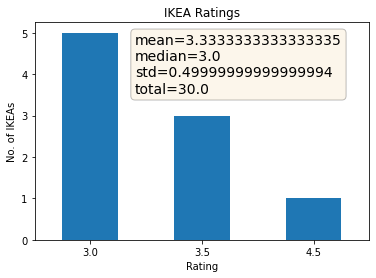

In [30]:
plot_data(df_IKEA_businesses, column="stars", plot_type='bar', title="IKEA Ratings",
                  x_label="Rating", y_label="No. of IKEAs", show_total=True,
                  show_range=False, y_scale='linear')

# find users who reviewed IKEA businesses

In [31]:
filename = path_to_jsons + "yelp_academic_dataset_review.json"
IKEA_users = []
IKEA_reviews = []
with tqdm(total=os.path.getsize(filename)) as pbar:
    with open(filename) as f:
        set_ids_to_check = set(df_IKEA_businesses.business_id)
        state_of_business = dict(zip(df_IKEA_businesses.business_id, df_IKEA_businesses.state))
        for line in f:
            pbar.update(len(line))
            review = json.loads(line)
            if review["business_id"] in set_ids_to_check:
                IKEA_users.append({"user_id": review["user_id"], 
                                   "state": state_of_business[review["business_id"]]
                                  })
                IKEA_reviews.append(review)

df_IKEA_reviews = pd.DataFrame(IKEA_reviews)
del IKEA_reviews
df_IKEA_reviews.to_pickle("df_IKEA_reviews.pkl")

  0%|          | 0/6936678061 [00:00<?, ?it/s]

In [32]:
df_IKEA_users = pd.DataFrame(IKEA_users)
del IKEA_users

remove duplicates, keep the first

In [33]:
mask = df_IKEA_users.duplicated(['user_id'], keep="first")
df_IKEA_users = df_IKEA_users[~mask]

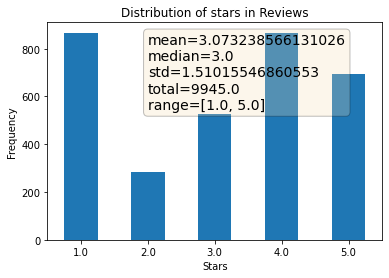

In [34]:
plot_data(df_IKEA_reviews, column='stars', plot_type='bar', title='Distribution of stars in Reviews', x_label='Stars', y_label='Frequency', show_total=True, show_range=True, y_scale='linear')

In [ ]:
df_IKEA_reviews

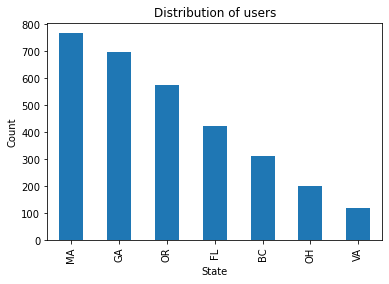

In [35]:
ax = df_IKEA_users['state'].value_counts().plot(kind='bar');
ax.set_xlabel("State");
ax.set_ylabel("Count");
ax.set_title("Distribution of users");

In [36]:
df_IKEA_users = (df_IKEA_users
 .assign(west= df_IKEA_users["state"].isin(["OR","BC"]))
)

In [37]:
(df_IKEA_users
.query('west in [True]')
)

,user_id,state,west
449,9X9pCM6ScH-jgsloaG5_kA,BC,True
450,srob2s0_tZBtASKXtPOheQ,BC,True
457,B6OB8dk5P5LmUEoBjvBFTw,BC,True
461,VYyzB5HEdftyT8xgcEhhpA,BC,True
464,rECd5j9IezBxEfwKWdMPKg,BC,True
...,...,...,...
2902,ZP137_qhoacFhgnI--o49A,OR,True
2903,pbzeNgmK2qPhkZQ-M-7iCQ,OR,True
2904,QlzCRfJbsaggG6FGrIAoTQ,OR,True
2905,wTRglO7YpZ3Zw4zV2-kB0Q,OR,True


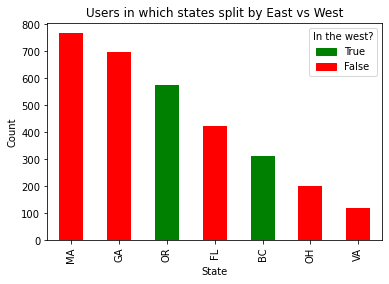

In [38]:
colours = {True: 'green', False: 'red'}
counts = df_IKEA_users.groupby(['state', 'west']).size().reset_index(name='counts')
counts.sort_values(["counts"], inplace=True, ascending=False)
ax = counts.plot(x='state', y='counts', kind ='bar', color=counts["west"].replace(colours))
labels = list(colours.keys())
handles = [plt.Rectangle((0,0),1,1, color=colours[label]) for label in labels]
ax.legend(handles, labels, title='In the west?')
ax.set_xlabel("State");
ax.set_ylabel("Count");
ax.set_title("Users in which states split by East vs West");

In [39]:
counts

,state,west,counts
3,MA,False,767
2,GA,False,696
5,OR,True,574
1,FL,False,425
0,BC,True,311
4,OH,False,201
6,VA,False,118


In [40]:
df_IKEA_users.to_pickle("df_IKEA_users.pkl")
df_IKEA_users.tail()

,user_id,state,west
3231,WDL_Lyom1Pn6JLWAghsJZQ,VA,False
3232,diMecfnNWdx_vhcam3_jeA,VA,False
3233,ZXfHVOPVIHEAbVMl0kTV6A,OH,False
3234,L3lpkRQ0nH4VIclkEr9cnw,VA,False
3235,2XcrMwGuefn4j_IDAbzN7Q,VA,False


# get all the IKEA user ids to find friends

In [41]:
df_IKEA_users.loc[df_IKEA_users['user_id'] == "9X9pCM6ScH-jgsloaG5_kA"]["state"].values[0]

'BC'

In [42]:
pickle_name = "df_IKEA_users_wth_friends.pkl"
filename = path_to_jsons + "yelp_academic_dataset_user.json"
total_no_friends = 0
total_userids = 0
try:
    df_IKEA_users_wth_friends = pd.read_pickle(pickle_name)
except (FileNotFoundError) as e:
    IKEA_users_wth_friends = []
    with tqdm(total=os.path.getsize(filename)) as pbar:
        with open(filename) as f:
            set_ids_to_check = set(df_IKEA_users.user_id)
            for line in f:
                pbar.update(len(line))
                user = json.loads(line)
                if user["user_id"] in set_ids_to_check:
                    friends_who_reviewed = set()
                    for friend in user["friends"].split(","):
                        friend = friend.strip()
                        if friend:
                            if friend in set_ids_to_check:
                                friends_who_reviewed.add(friend)
                    if friends_who_reviewed:
                        user["friends"] = ",".join(list(friends_who_reviewed))
                        user["west"] = df_IKEA_users.loc[df_IKEA_users['user_id'] == user["user_id"]]["west"].any()
                        user["state"] = df_IKEA_users.loc[df_IKEA_users['user_id'] == user["user_id"]]["state"].values[0]
                        total_userids += 1
                        IKEA_users_wth_friends.append(user)
                    else:
                        total_no_friends += 1
    df_IKEA_users_wth_friends = pd.DataFrame(IKEA_users_wth_friends)
    del IKEA_users_wth_friends
    df_IKEA_users_wth_friends.to_pickle(pickle_name)
    
print("total_userids", total_userids)
print("total_no_friends", total_no_friends)
print("shape", df_IKEA_users.shape)

total_userids 0
total_no_friends 0
shape (3092, 3)


/tmp/ipykernel_216545/3935632007.py:1: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie([total_userids, total_no_friends], labels=["With Friends", "No friends"], autopct='%.2f');


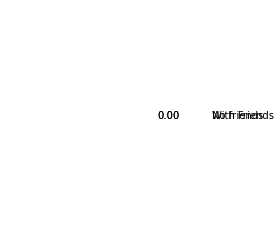

In [43]:
plt.pie([total_userids, total_no_friends], labels=["With Friends", "No friends"], autopct='%.2f');

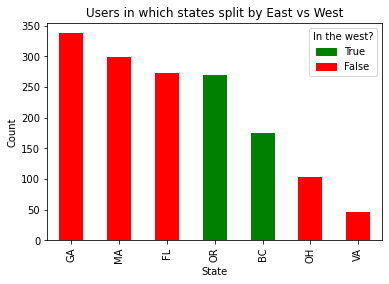

In [44]:
colours = {True: 'green', False: 'red'}
counts = df_IKEA_users_wth_friends.groupby(['state', 'west']).size().reset_index(name='counts')
counts.sort_values(["counts"], inplace=True, ascending=False)
ax = counts.plot(x='state', y='counts', kind ='bar', color=counts["west"].replace(colours))
labels = list(colours.keys())
handles = [plt.Rectangle((0,0),1,1, color=colours[label]) for label in labels]
ax.legend(handles, labels, title='In the west?')
ax.set_xlabel("State");
ax.set_ylabel("Count");
ax.set_title("Users in which states split by East vs West");

In [45]:
counts

,state,west,counts
2,GA,False,338
3,MA,False,299
1,FL,False,273
5,OR,True,269
0,BC,True,175
4,OH,False,103
6,VA,False,47


In [46]:
df_IKEA_users_wth_friends['friends_count'] = df_IKEA_users_wth_friends['friends'].apply(lambda x: len(x.split(",")))

In [47]:
df_IKEA_users_wth_friends.sort_values(["friends_count"], ascending=[False]).head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,west,state,friends_count
6,rcU7ysY41qGppbw4pQgjqg,Damien,1989,2007-06-30 12:28:20,14766,12544,10621,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","PQOHkTVWUoAxAkiUa3SRMg,tR8kf3Ae_ng-GxUdfpaiKw,...",1031,...,89,1022,3380,1410,1410,440,248,False,MA,190
916,hdzTAN8DGJKRddkZ8279JQ,Andi,989,2012-01-01 16:38:21,17505,5739,12959,"2014,2015,2016,2017,2018,2019,20,20","0aBTYXlP3z5nJ7okTARj8A,cqoSx4ITtvkYmWaL6gf0YQ,...",1360,...,3,430,2858,673,673,300,266,False,FL,186
1183,JjXuiru1_ONzDkYVrHN0aw,Richard,1303,2009-08-23 13:03:27,157354,115844,149659,"2011,2012,2013,2014,2015,2016,2017,2018,2019,2...","8lH88XdzbQKTFg9WQZeuCw,4PT3KhshJdbGEuMY5modzg,...",3009,...,2412,13248,90858,46858,46858,15225,53854,False,GA,167
1143,Pf7FI0OukC_CEcCz0ZxoUw,Don,2377,2007-07-10 21:19:17,26866,16235,18853,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","MzZd8SSWlXVfvJH3g68daQ,MoCD_-Eh_j6-dI0V57hG9g,...",958,...,140,1383,4507,2799,2799,1017,260,True,OR,164
25,j14WgRoU_-2ZE1aw1dXrJg,Daniel,3978,2009-01-25 04:35:42,34847,10674,22582,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","8lH88XdzbQKTFg9WQZeuCw,4PT3KhshJdbGEuMY5modzg,...",2938,...,245,1778,6538,2992,2992,1480,1682,False,GA,164


In [49]:
print(df_IKEA_users_wth_friends.sample(1).T.to_string())

                                                                                    1252
user_id                                                           N4mIzFm7Qs9yKcRFXg4-1g
name                                                                             Scottie
review_count                                                                         357
yelping_since                                                        2012-05-25 13:01:18
useful                                                                               836
funny                                                                                434
cool                                                                                 198
elite                                                      2013,2014,2015,2016,2017,2018
friends             MuGxIIrcGJ7FnxU7kTPNBw,v0KmYNybWmLXDZdL5BcKug,DxeNa6k3TEekeiF4wM-C9w
fans                                                                                  30
average_stars        

## lets see the distribution of friend count


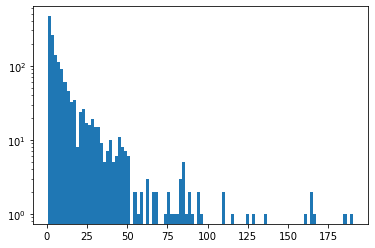

In [42]:
plt.hist(df_IKEA_users_wth_friends['friends_count'], log=True, bins=100);

## and see distribution of review_count

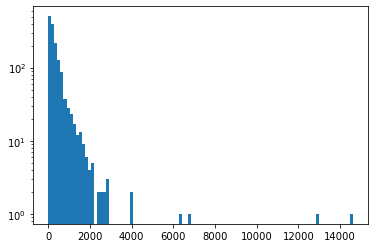

In [43]:
plt.hist(df_IKEA_users_wth_friends['review_count'], log=True, bins=100);

# create csv source-target of friendships

In [44]:
total_lines = 0
filename = "IKEA.csv"
if not os.path.isfile(filename):
    with tqdm(total=len(df_IKEA_users_wth_friends)) as pbar:
        with open(filename, "w") as f:
            f.write("source,target\n")
            for index, row in df_IKEA_users_wth_friends.iterrows():
                pbar.update(1)
                for friend in row['friends'].split(","):
                    line = "{},{}\n".format(row["user_id"], friend)
                    f.write(line)
                    total_lines += 1

print("total_lines", total_lines)

  0%|          | 0/1504 [00:00<?, ?it/s]

total_lines 17404


# create users csv for R

In [45]:
df_IKEA_users_wth_friends.to_csv("df_IKEA_users_wth_friends.csv")

# networkx read in IKEA for analysis


In [19]:
import networkx as nx
import operator
import datetime
from time import gmtime, strftime

#Document
#https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html
filename = "IKEA.csv"
with open(filename, 'rb') as fh:
    next(fh, '')   # skip a line
    G = nx.read_edgelist(fh, delimiter=',')


## also create adjacency matrix for R

In [48]:
nx.to_pandas_adjacency(G).to_csv("IKEA_adjacency.csv")

# degree chart

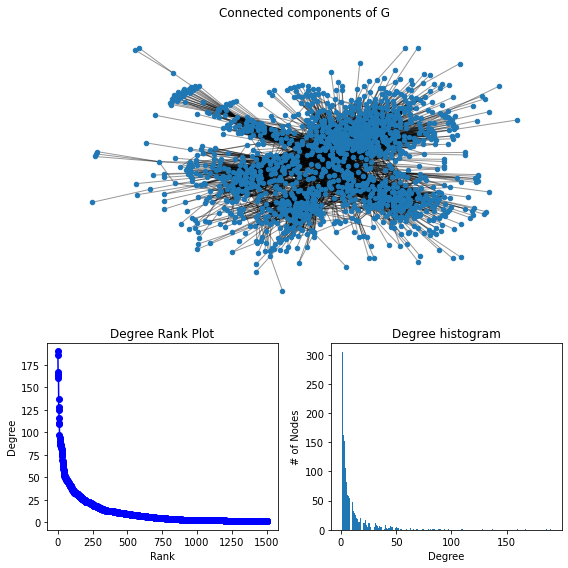

In [21]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
value, counts = np.unique(degree_sequence, return_counts=True)
ax2.bar(value, counts)
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [ ]:
# GO TO other notebook 